# Modelagem de dados para quatro atividades enzimáticas: fpase, cmcase, beta-glicosidase e xilanase


## Descrição do que foi feito neste notebook:

- 

## Importação de módulos utilizandos durante todo o processamento

In [1]:
#importação de módulos
#@import
import pandas as pd
import numpy as np
import time

#Para plotagens
import matplotlib.pyplot as plt
import seaborn as sns

#Filtro Digital de Savitzky-Golay para suavização dos dados
from scipy.signal import savgol_filter

#pré-processamento:

#Transformação nos dados
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, scale, LabelEncoder
#Seleção de atributos
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectPercentile

#particionamento de base de dados para treinamento, validação e teste
from sklearn.model_selection import train_test_split

#algoritmos para o aprendizado:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor

#Métricas para avaliação dos algoritmos de aprendizado
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## FUNÇÕES GERAIS

In [2]:
#@fglobal

### Funções para validação dos modelos multivariados

In [2]:
#@fvalidações
#RMSE
def rmse(ref,pred):
    #recebe como entrada dois vetores dos valores de referência e preditos
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    n=len(ref) #total de amostras
    mse = 0
    for i in range(n):
        mse +=(ref[i]-pred[i])**2
    mse=mse/n
    rmse=np.sqrt(mse)
    return rmse

#bias
def bias(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    b=0
    n = len(ref)
    for r, p in zip(ref, pred):
        b += (r-p)
    return (b/n)
    
#SEP
def sep(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    b = bias(ref,pred)
    sep = 0
    n = len(ref)
    for i in range(n):    
        sep +=(ref[i]-pred[i]-b)**2
    sep = np.sqrt(sep/(n-1))
    return sep
    
#RPIQ
def rpiq(ref, pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    q1 = ref.quantile(0.25)
    q3 = ref.quantile(0.75)
    iq=q3-q1
    rpiq = iq/rmse(ref, pred)
    return rpiq
#RPD
def rpd(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    rpd = np.std(ref)/rmse(ref,pred)
    return rpd

#RER
def rer(ref,pred):
    ref = pd.Series(ref)
    pred=pd.Series(pred)
    rer = (np.max(ref) -np.min(ref) )/sep(ref,pred)
    return rer

#R2
def getr2(ref,pred):
    r2=r2_score(ref,pred)
    return r2
#MSE
def getmse(ref,pred):
    mse = mean_squared_error(ref,pred)
    return mse
#RMSE forma simples de calcular
def getrmse(ref,pred):
    rmse = np.sqrt(mean_squared_error(ref,pred))
    return rmse

### Funções de pré-processamento

In [3]:
#funções gerais de pré-processamento de spectros
#@fspec
#MSC(Multiplicative scatter correction)COrreção da dispersão multiplicativa
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

#Variável normal padrão (SNV) Standard Normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

### Função teste para correção de espectros

In [4]:
#@ftestes
def executePreSpec(dados,wint,wtxt):
    x = dados.loc[:,wtxt].values
    w = wint
    
    Xmsc = msc(x)[0] # Take the first element of the output tuple
    Xsnv = snv(x)
    ## Plot spectra
    plt.figure(figsize=(8,9))
    with plt.style.context(('ggplot')):
        ax1 = plt.subplot(311)
        plt.plot(w, x.T)
        plt.title('Original data')
        ax2 = plt.subplot(312)
        plt.plot(w, Xmsc.T)
        plt.ylabel('Absorbance spectra')
        plt.title('MSC')
        ax2 = plt.subplot(313)
        plt.plot(w, Xsnv.T)
        plt.xlabel('Wavelength (nm)')
        plt.title('SNV')
        plt.show()

### Funções para plotar resultados

In [5]:
#@grafResiduos
def graficoResiduos(modelo, treino_teste, y_c, y_cv,y_p):
    #gráfico de resíduos: 
    res_c = treino_teste[2] - y_c #resíduos da calibração
    res_cv = treino_teste[2] - y_cv #residuos da validação
    res_p = treino_teste[3] - y_p #resíduos da predição
    residuos = [res_c, res_cv, res_p]
    ys = [y_c, y_cv, y_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    fig = plt.figure(figsize=(20,20))
    plt.subplots_adjust(hspace = 0.3, wspace=0.2)
    for i,res, m in zip([0,1,2],residuos, modelos):   
        ig = i+1
        for cor,j in zip(cores_ae,[0,1,2,3]):
            ax = fig.add_subplot(4,3,ig)
            ax = sns.residplot(res.iloc[:,j],ys[i][:,j],  color=cor, robust=True,label=var_ae[j])
            ax.set_title(modelo+':Resíduos('+m+')')
            ax.set_xlabel('Preditos')
            ax.set_ylabel('Resíduos')
            plt.legend(loc='best')
            ig+=3

In [6]:
#@grafHistogramas
def graficoHist(modelo, treino_teste, y_c, y_cv,y_p):
    res_c = treino_teste[2] - y_c #resíduos da calibração
    res_cv = treino_teste[2] - y_cv #residuos da validação
    res_p = treino_teste[3] - y_p #resíduos da predição
    #histograma dos resíduos para verificar se segue uma distribuição normal
    #gráfico de resíduos: histograma
    residuos = [res_c, res_cv, res_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    for i,res, m in zip([0,1,2],residuos, modelos):   
        fig = plt.figure(figsize=(20,5))
        plt.subplots_adjust(hspace = 0.5, wspace=0.1)

        for cor,j in zip(cores_ae,[0,1,2,3]):
            ax = fig.add_subplot(1,4,j+1)
            ax = sns.distplot(res.iloc[:,j], color=cores_ae[j], kde=False, label=var_ae[j]);
            ax.set_title(modelo+' :Histograma dos resíduos('+m+')')

In [7]:
#gráfico: reais  x preditos - separando calibração validação predição
#@grafreaispred
def graficoReaisPreditosSep(modelo, treino_teste, y_c, y_cv,y_p):
    res_c = treino_teste[2] #variável resposta da calibração
    res_cv = treino_teste[2] #variável resposta da validação
    res_p = treino_teste[3]#variável resposta da predição
    reais= [res_c, res_cv, res_p]
    ys = [y_c, y_cv, y_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    mark=['x','1','+']
    fig = plt.figure(figsize=(20,20))
    plt.subplots_adjust(hspace = 0.3, wspace=0.2)
    for i,re, m in zip([0,1,2],reais, modelos):   
        ig = i+1
        for cor,j in zip(cores_ae,[0,1,2,3]):
            ax = fig.add_subplot(4,3,ig)
            ax.scatter(re.iloc[:,j], ys[i][:,j],marker=mark[i],c=cores[i], edgecolors='k', label=var_ae[j]+'\n'+m)
            ax.plot(ys[i][:,j], ys[i][:,j], color=cores[i])
            
            ax.set_title(modelo)
            ax.set_xlabel('Reais')
            ax.set_ylabel('Preditos')
            plt.legend(loc='best')
            ig+=3

In [8]:
#gráfico: reais  x preditos - juntando cal, val e predição
#@grafreaispred
def graficoReaisPreditos(modelo, treino_teste, y_c, y_cv,y_p):
    res_c = treino_teste[2] #variável resposta da calibração
    res_cv = treino_teste[2] #variável resposta da validação
    res_p = treino_teste[3]#variável resposta da predição
    reais= [res_c, res_cv, res_p]
    ys = [y_c, y_cv, y_p]
    modelos = ['cal','val','pred']
    cores = ['b','r','k']
    cores_ae=['b','g','r','y']
    mark=['x','1','+']
    fig = plt.figure(figsize=(10,30))
    plt.subplots_adjust(hspace = 0.3, wspace=0.2)
    
    for i in range(4):
        for j in range(3):
            ax = fig.add_subplot(4,1,i+1)
            ax.scatter(reais[j].iloc[:,i], ys[j][:,i],c=cores[j],marker=mark[j],label=modelos[j])
            if j == 0:
                ax.plot(ys[j][:,i], ys[j][:,i], color=cores[j], label=modelos[j])        
        ax.set_title(modelo+'-->'+var_ae[i])
        ax.set_xlabel('Reais')
        ax.set_ylabel('Preditos')
        plt.legend(loc='best')
    

In [11]:
#@grafTreinamento
def graficoTreinamento(modelo, y_treino, y_c, y_cv):
    ###################################################################
    #Gráficos de treinamento e validação cruzada para todas as atividades
    #cria um data frame com os valores reais e preditos na calibração e validação
    df_cv = {}
    for valor in var_ae:
        df_cv[valor] = []
    i=0
    for valor in var_ae:
        df = pd.DataFrame(columns=['reais','cal','val'], index=y_treino.index)
        df['reais'] = y_treino[valor]
        df['cal'] = pd.DataFrame(y_c[:,i],index= y_treino.index)
        df['val'] = pd.DataFrame(y_cv[:,i],index= y_treino.index)
        i +=1
        df_cv[valor] = df.copy()
    #cria data frame com os valores dos intervalos de medições
    df_cv_inter ={}
    for valor in var_ae:
        df_cv_inter[valor] = []
    for valor in var_ae:
        df_cv_inter[valor] = df_cv[valor].copy()
        df_cv_inter[valor]['inter'] = dados.loc[:,'inter']
    #ordena valores pelo intervalo
    df_ord_treino = {}
    for valor in var_ae:
        df_ord_treino[valor] = []
    for valor in var_ae:
        df_ord_treino[valor] = df_cv_inter[valor].sort_values(['inter'])
    x = list(df_ord_treino['xilanase']['inter'])

    #calculando a média para cada ponto
    df_treino_media = {}
    for valor in var_ae:
        df_treino_media[valor] = []
    for valor in var_ae:
        df_treino_media[valor] = df_ord_treino[valor].groupby('inter').mean()

    x = list(df_treino_media['xilanase'].index)
    var = ['reais', 'cal','val']
    tipo = ['ko-.', 'bo-.','ro-.']
    tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
    fig = plt.figure(figsize=(15,5))
    j=1
    plt.subplots_adjust(hspace = 0.7, wspace=0.5)
    for valor in var_ae:
        ax = fig.add_subplot(2,2,j)
        for i in range(3):
            ax.plot(x,df_treino_media[valor][var[i]], tipo[i], label=var[i])
            ax.legend(loc=2)
            ax.set_title('Calibração e validação cruzada:'+modelo+': '+valor)
            ax.set_xlabel('Tempo de fermentação')
            ax.set_ylabel('Atividade enzimática') 
            ax.set_xticks(x)
        j+=1

In [12]:
#@grafTeste (predição )
def graficoTeste(modelo, y_teste, y_p):
    ###################################################################
    #para todas as atividades
    #cria um data frame com os valores reais e preditos para os dados de teste
    df_pred = {}
    for valor in var_ae:
        df_pred[valor] = []
    i=0
    for valor in var_ae:
        df =pd.DataFrame(columns=['reais','preditos'], index= y_teste.index)
        df['reais'] = y_teste[valor]
        df['preditos'] = pd.DataFrame(y_p[:,i],index= y_teste.index)
        i +=1
        df_pred[valor] = df.copy()
        
    #cria data frame com os valores dos intervalos de medições
    df_pred_inter = {}
    for valor in var_ae:
        df_pred_inter[valor] = []
    for valor in var_ae:
        df_pred_inter[valor] = df_pred[valor].copy()
        df_pred_inter[valor]['inter'] = dados.loc[:,'inter']

    #ordena valores pelo intervalo
    df_ord_teste = {}
    for valor in var_ae:
        df_ord_teste[valor] = []
    for valor in var_ae:
        df_ord_teste[valor] = df_pred_inter[valor].sort_values(['inter'])

    #calculando a média para cada ponto
    df_teste_media = {}
    for valor in var_ae:
        df_teste_media[valor] = []
    for valor in var_ae:
        df_teste_media[valor] = df_ord_teste[valor].groupby('inter').mean()

    x = list(df_teste_media['xilanase'].index)
    var = ['reais', 'preditos']
    tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
    j = 0    
    fig = plt.figure(figsize=(15,5))
    plt.subplots_adjust(hspace = 0.7, wspace=0.5)
    for valor in var_ae:
        ax = fig.add_subplot(2,2,j+1)
        ax.plot(x,df_teste_media[valor][var[0]], 'ko-.', label=var[0])
        ax.plot(x,df_teste_media[valor][var[1]], tipoAE[j], label=var[1])
        j +=1
        ax.legend(loc=2)
        ax.set_title('Validação externa: Modelo '+modelo+':'+valor)
        ax.set_xlabel('Tempo de fermentação')
        ax.set_ylabel('Atividade enzimática') 
        ax.set_xticks(x)

### Função para calcular intervalo de confiança para a média dos modelos criados:

In [13]:
#@interConfiança
#para intervalo de confiança = 95%  Z = 1,96
# a proporção de acertos do modelo será de p +- (valor calculado para intervalo de confiança da proporção de acerto)
# seja n o número amostras (neste caso o número de modelos criados, exemplo 40)
#P(a) = o resultado da proporção de acerto
#P(e) = proporção de erro
#p =- intervalo de confiança
#ic = z*raizquadrada((pa*(1-pa))/n)
#exemplo:
def calculaIntConf(n,pa):
    z = 1.96
    ic = z*(np.sqrt((pa*(1-pa))/n))
    ic_min = p - ic
    ic_max = pa + ic
    return ic_min, ic_max

## Base de dados

In [14]:
#@data
#Escolha da base de dados

In [14]:
#base de dados contendo todos os dados
dados= pd.read_excel('A_dados.xlsx',sheet_name='todos')
dados_back = dados.copy()

In [28]:
#@backupdata
dados = dados_back.copy() #backup da base para uso posterior rápido

In [29]:
#@dadosshape
dados.shape #tamanho da base dados

(1451, 713)

In [30]:
#Separar somente as amostras que contenham todas as atividades enzimáticas
dados = dados.loc[(dados['betaglicosidase'].notnull()) 
                         & (dados['cmcase'].notnull()) 
                         & (dados['fpase'].notnull())
                         &(dados['xilanase'].notnull())]
resultados = '\nTotal geral de amostras com todas as atividades enzimáticas:'+str(dados.shape[0])
print(resultados)


Total geral de amostras com todas as atividades enzimáticas:938


In [353]:
#se precisar eliminar colunas com dados nulos
dadosb=dados.dropna(axis=1)

In [400]:
#escolha a base de dados que quer trabalhar por extrato enzimático
#dados = pd.read_excel('A_dados.xlsx',sheet_name='celluclast')
#dados = pd.read_excel('A_dados.xlsx',sheet_name='bio')
#dados = pd.read_excel('A_dados.xlsx',sheet_name='celic')

dados1 = dados[(dados['eenz'] == 'celluclast')]
dados2 = dados[(dados['eenz'] == 'eeta')]
dados3 = dados[(dados['eenz'] == 'ctec2')]
dados4 = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='biof')]

In [404]:
dados4.shape

(81, 713)

In [259]:
dados = dados[(dados['eenz'] == 'eeta')] #base de dados do extrato EETA exp 1
dados.shape

(0, 713)

In [11]:
dados = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='biof')] #base de dados do EETA somente da fermentação

In [2446]:
dadosB1 = dados[(dados['experimento']=='biof')]
dadosB1.shape
#dadosB = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='bioB')] #fermentação em bior 2
#dadosE = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='bioE')] #fermentação em erlemeyer(paralelo a bior2)

(81, 713)

In [1235]:
dadosB2 = dados[dados['experimento']=='bioB']# eeta de fermentação em bior exp 2
dadosB2.shape

(21, 713)

In [1236]:
dadosE = dados[dados['experimento']=='bioE']# eeta de fermentação em erlemeyer exp2 
dadosE.shape

(24, 713)

In [2447]:
dadosD1= dados[dados['experimento']=='biod1']# eeta de desnaturação 1 exp 1
dadosD1.shape

(33, 713)

In [1238]:
dadosD2= dados[dados['experimento']=='biod2']# eeta de desnaturação 2 exp 2
dadosD2.shape

(33, 713)

In [405]:
frames = [dados1, dados3,dados4]
dados = pd.concat(frames)

In [317]:
dados = dados1.copy()

In [406]:
dados.shape

(1340, 713)

In [ ]:
#Separar somente as amostras que contenham betaglicosidase
dados = dados.loc[(dados['betaglicosidase'].notnull()) ]
resultados = '\nTotal geral de amostras para betaglicosidase:'+str(dados.shape[0])

In [ ]:
#Separar somente as amostras que contenham cmcase
dados = dados.loc[(dados['cmcase'].notnull()) ]
resultados = '\nTotal geral de amostras para cmcase:'+str(dados.shape[0])

In [ ]:
#Separar somente as amostras que contenham fpase
dados = dados.loc[(dados['fpase'].notnull()) ]
resultados = '\nTotal geral de amostras para fpase:'+str(dados.shape[0])

In [ ]:
#Separar somente as amostras que contenham xilanase
dados = dados.loc[(dados['xilanase'].notnull()) ]
resultados = '\nTotal geral de amostras para xilanase:'+str(dados.shape[0])

## Estatística básica do conjunto de dados: ativbidade enzimática

In [17]:
#@statistic

In [18]:
dados['betaglicosidase'].describe()

count     938.000000
mean      219.174475
std       396.311596
min         0.030827
25%        45.729072
50%       130.137430
75%       210.680362
max      2918.568120
Name: betaglicosidase, dtype: float64

In [19]:
dados['cmcase'].describe()

count    938.000000
mean      77.413168
std       45.775948
min        0.011206
25%       64.645518
50%       77.500219
75%       92.510043
max      287.959991
Name: cmcase, dtype: float64

In [20]:
dados['fpase'].describe()

count    938.000000
mean      25.262841
std       21.514680
min        0.004200
25%       13.838248
50%       20.473927
75%       35.779999
max      163.328003
Name: fpase, dtype: float64

In [21]:
dados['xilanase'].describe()

count     938.000000
mean      441.624242
std       427.624840
min         0.072595
25%       169.933631
50%       349.312036
75%       667.230169
max      3143.389890
Name: xilanase, dtype: float64

In [484]:
#verifica quantos são os valores nulos no conjunto de dados por coluna
#dados.isnull().sum()

## imprimindo os espectros:

In [22]:
#@plotscpec
#criando vetores com os nomes dos atributos apenas para plotagem

var_abs_int = np.arange(1100,2496,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']
var_ae=['betaglicosidase','cmcase','fpase','xilanase']

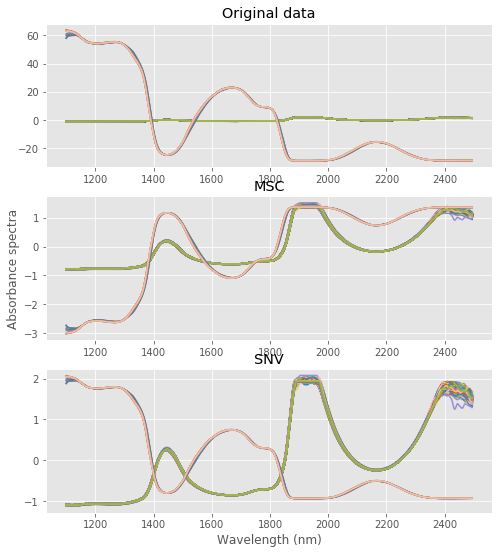

In [23]:
#teste das correções dos espectros:
#@testescorreções
teste = dados.copy()
executePreSpec(teste,var_abs_int,var_abs_txt)

In [31]:
X=dados.loc[:,var_abs_txt]
xT= np.transpose(X)
len(X.columns)

698

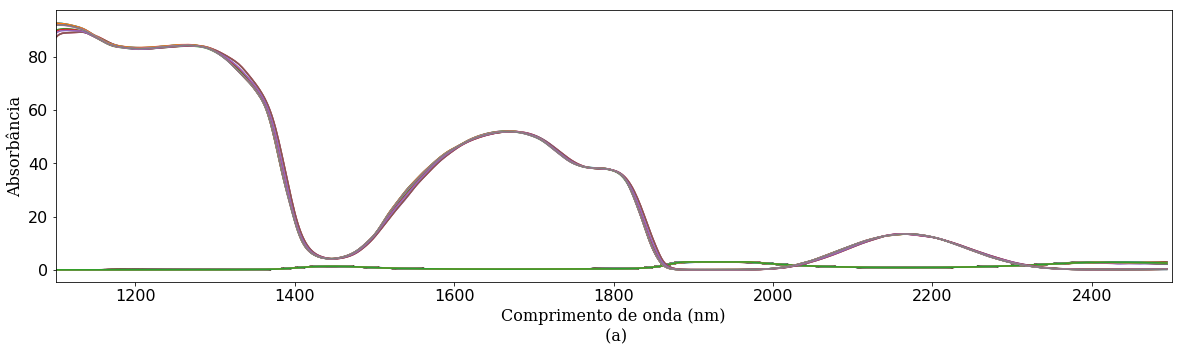

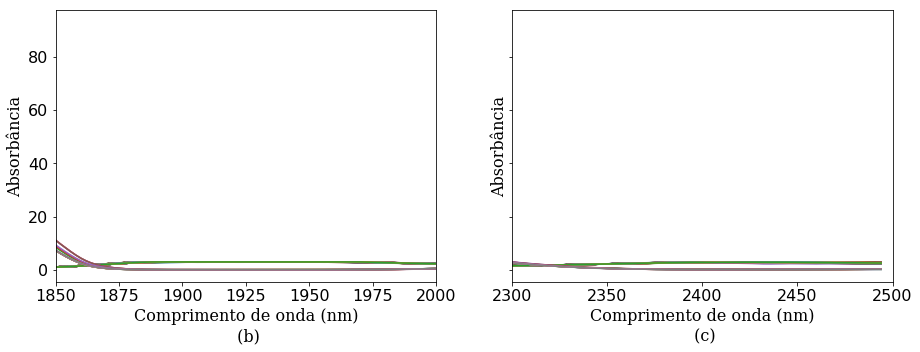

In [32]:
#gráfico de dispersão 3 em um

fonte = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
figuras = ['(a)','(b)','(c)']
limites = [[1100,2500],[1850,2000], [2300,2500]]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.subplots_adjust(hspace = 0.5, wspace=0.1)
ax.plot(var_abs_int, xT)
ax.grid(False)
ax.set_xlabel('Comprimento de onda (nm)\n (a)', fontdict=fonte)
ax.set_ylabel('Absorbância', fontdict=fonte)
ax.set_xlim(limites[0][0],limites[0][1])
ax.tick_params(labelsize=16)

_, [ax1,ax2] = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.plot(var_abs_int, xT)
ax1.grid(False)
ax1.set_xlabel('Comprimento de onda (nm)\n (b)', fontdict=fonte)
ax1.set_ylabel('Absorbância', fontdict=fonte)
ax1.set_xlim(limites[1][0],limites[1][1])
ax1.tick_params(labelsize=16)

ax2.plot(var_abs_int, xT)
ax2.grid(False)
ax2.set_xlabel('Comprimento de onda (nm)\n (c)', fontdict=fonte)
ax2.set_ylabel('Absorbância', fontdict=fonte)
ax2.set_xlim(limites[2][0],limites[2][1])
ax2.tick_params(labelsize=16)

plt.show()


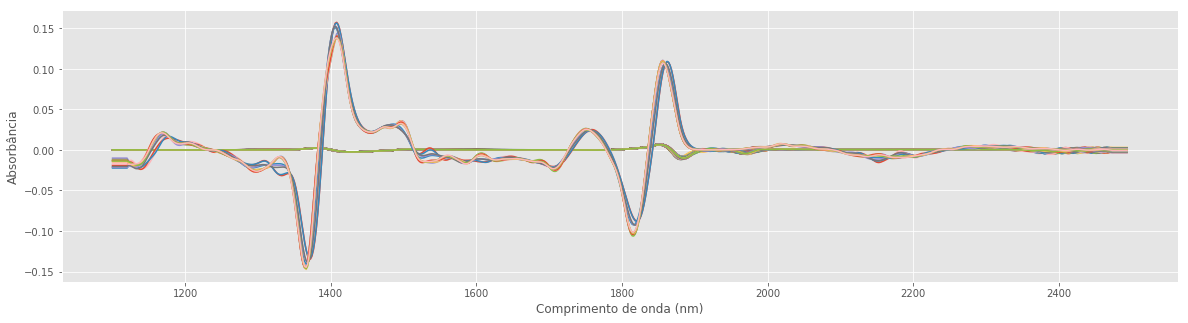

In [33]:
#Aplicando 2 derivada para impressão dos espectros:
X=dados.loc[:,'1100nm':'2494nm']
wl = np.arange(1100,2495,2)
X2 = savgol_filter(X,21,polyorder=2, deriv=2)
# Imprimendo gráfico para segunda derivada
plt.figure(figsize=(20,5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X2.T)
    plt.xlabel('Comprimento de onda (nm)')
    plt.ylabel('Absorbância')
    plt.show()


In [53]:
#dados_bio1=dados[dados.loc[:,'experimento'] != 'biof']
#seleção de dados apenas da desnaturação

# Seleção de atributos relevantes

In [19]:
#@seleção de atributos
#1ºDefinimos os atributos importantes para determinação da atividade específica e veremos se utilizar todos os espectros ou os selecionados faz diferença no desempenho

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectPercentile, mutual_info_classif, chi2

In [34]:
#denindo as variáveis iniciais para o pré-processamento
var_ae=['betaglicosidase','cmcase','fpase','xilanase']

#criando um vetor com os nomes das absorbâncias para seleção posterior
var_abs_int = np.arange(1100,2495,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']

In [35]:
#Definindo os dataFrames iniciais para começar o processamento da seleção de atributos
#Separando a matriz de dados independentes df_y, da de dados dependentes df_x
df_x = dados.loc[:,var_abs_txt] #absorbâncias
df_y = dados.loc[:,var_ae]#AE

In [286]:
df_x.head(5)

1100nm    1102nm    1104nm    1106nm    1108nm    1110nm    1112nm  \
0  0.033690  0.034025  0.034302  0.034534  0.034730  0.034908  0.035092   
1  0.034158  0.033989  0.033937  0.034027  0.034259  0.034608  0.035037   
2  0.033267  0.033650  0.033960  0.034240  0.034516  0.034807  0.035128   
3  0.033680  0.033531  0.033564  0.033741  0.034018  0.034357  0.034727   
4  0.033632  0.033577  0.033613  0.033735  0.033932  0.034204  0.034556   

     1114nm    1116nm    1118nm  ...    2476nm    2478nm    2480nm    2482nm  \
0  0.035302  0.035555  0.035871  ...  2.734445  2.711175  2.684079  2.652157   
1  0.035511  0.036002  0.036483  ...  2.641607  2.628135  2.613031  2.594702   
2  0.035488  0.035893  0.036339  ...  2.617225  2.625774  2.634237  2.642206   
3  0.035112  0.035514  0.035944  ...  2.612468  2.614019  2.622193  2.632400   
4  0.034982  0.035460  0.035966  ...  2.632120  2.618624  2.606181  2.595136   

     2484nm    2486nm    2488nm    2490nm    2492nm    2494nm  
0  2.616421  2.580742  2.550500  2.529863  2.520123  2.519599  
1  2.573957  2.553411  2.535537  2.520982  2.508918  2.498570  
2  2.647367  2.647153  2.641267  2.632092  2.622844  2.615529  
3  2.638570  2.635498  2.621143  2.596599  2.565386  2.533125  
4  2.584422  2.572338  2.558169  2.542595  2.527246  2.514123  

[5 rows x 698 columns]

In [243]:
df_y.head(5)

betaglicosidase      cmcase      fpase   xilanase
0       462.495795  114.800334  50.343581  575.54899
1       462.495795  114.800334  50.343581  575.54899
2       462.495795  114.800334  50.343581  575.54899
3       929.796742   90.505314  57.640572  484.13796
4       929.796742   90.505314  57.640572  484.13796

In [36]:
#verificando a correlação entre os dados
dados.corr()

1100nm    1102nm    1104nm    1106nm    1108nm    1110nm  \
1100nm           1.000000  0.999994  0.999983  0.999972  0.999962  0.999955   
1102nm           0.999994  1.000000  0.999997  0.999992  0.999987  0.999982   
1104nm           0.999983  0.999997  1.000000  0.999999  0.999996  0.999993   
1106nm           0.999972  0.999992  0.999999  1.000000  0.999999  0.999998   
1108nm           0.999962  0.999987  0.999996  0.999999  1.000000  1.000000   
1110nm           0.999955  0.999982  0.999993  0.999998  1.000000  1.000000   
1112nm           0.999948  0.999977  0.999990  0.999996  0.999999  1.000000   
1114nm           0.999941  0.999973  0.999988  0.999994  0.999998  0.999999   
1116nm           0.999935  0.999969  0.999985  0.999992  0.999996  0.999998   
1118nm           0.999928  0.999964  0.999981  0.999990  0.999994  0.999997   
1120nm           0.999920  0.999958  0.999977  0.999987  0.999992  0.999995   
1122nm           0.999911  0.999951  0.999972  0.999983  0.999989  0.999992   
1124nm           0.999900  0.999943  0.999965  0.999978  0.999985  0.999989   
1126nm           0.999888  0.999934  0.999958  0.999971  0.999979  0.999984   
1128nm           0.999874  0.999923  0.999949  0.999964  0.999973  0.999979   
1130nm           0.999860  0.999912  0.999940  0.999956  0.999966  0.999973   
1132nm           0.999845  0.999900  0.999930  0.999948  0.999959  0.999966   
1134nm           0.999830  0.999887  0.999920  0.999939  0.999951  0.999959   
1136nm           0.999815  0.999875  0.999909  0.999930  0.999942  0.999951   
1138nm           0.999799  0.999862  0.999898  0.999920  0.999934  0.999943   
1140nm           0.999784  0.999850  0.999887  0.999910  0.999925  0.999935   
1142nm           0.999768  0.999836  0.999876  0.999900  0.999915  0.999926   
1144nm           0.999751  0.999822  0.999863  0.999889  0.999905  0.999916   
1146nm           0.999734  0.999808  0.999851  0.999877  0.999894  0.999906   
1148nm           0.999719  0.999794  0.999839  0.999867  0.999885  0.999897   
1150nm           0.999705  0.999783  0.999829  0.999857  0.999876  0.999888   
1152nm           0.999693  0.999772  0.999819  0.999848  0.999868  0.999881   
1154nm           0.999682  0.999763  0.999811  0.999841  0.999860  0.999874   
1156nm           0.999672  0.999754  0.999803  0.999834  0.999854  0.999868   
1158nm           0.999665  0.999748  0.999797  0.999828  0.999849  0.999863   
...                   ...       ...       ...       ...       ...       ...   
2452nm          -0.973949 -0.973995 -0.974019 -0.974032 -0.974040 -0.974045   
2454nm          -0.973852 -0.973899 -0.973923 -0.973937 -0.973945 -0.973950   
2456nm          -0.973620 -0.973667 -0.973692 -0.973706 -0.973714 -0.973719   
2458nm          -0.973276 -0.973323 -0.973349 -0.973362 -0.973371 -0.973376   
2460nm          -0.972905 -0.972953 -0.972978 -0.972992 -0.973001 -0.973006   
2462nm          -0.972557 -0.972606 -0.972632 -0.972647 -0.972656 -0.972661   
2464nm          -0.972200 -0.972252 -0.972279 -0.972295 -0.972304 -0.972310   
2466nm          -0.971747 -0.971800 -0.971829 -0.971846 -0.971856 -0.971862   
2468nm          -0.971130 -0.971184 -0.971214 -0.971231 -0.971242 -0.971249   
2470nm          -0.970416 -0.970472 -0.970502 -0.970520 -0.970531 -0.970538   
2472nm          -0.969789 -0.969844 -0.969875 -0.969893 -0.969904 -0.969912   
2474nm          -0.969327 -0.969382 -0.969412 -0.969429 -0.969440 -0.969447   
2476nm          -0.968939 -0.968991 -0.969020 -0.969036 -0.969045 -0.969052   
2478nm          -0.968564 -0.968613 -0.968639 -0.968654 -0.968662 -0.968668   
2480nm          -0.968266 -0.968312 -0.968336 -0.968349 -0.968357 -0.968362   
2482nm          -0.968105 -0.968150 -0.968173 -0.968185 -0.968192 -0.968197   
2484nm          -0.968090 -0.968134 -0.968156 -0.968169 -0.968176 -0.968180   
2486nm          -0.968197 -0.968241 -0.968263 -0.968275 -0.968282 -0.968286   
2488nm          -0.968363 -0.968406 -0.968428 -0.968440 -0.968446 -0.

In [ ]:
#imprimir matriz de correlação entre todas as vaiáveis
'''import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(dados.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis da base de dados')
plt.show()'''

In [37]:
#para cada modelo poderá ser escolhida um conjunto de featues importantes
#exemplo:
# Criando conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_x,df_y, random_state=42)
# Treinando modelo
model  = LinearRegression()
model.fit(X_train, y_train)
# Mostrando importância de cada feature
#model.feature_importances_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [38]:
#separando o conjunto de dados em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(df_x,df_y,test_size=0.25, random_state=0)

# Imprime o tamanho das bases geradas
print('Particionamento para treinamento e teste:\n','X_treino:',x_treino.shape,'Y_treino:',y_treino.shape,'X_teste:', x_teste.shape,'Y_teste:', y_teste.shape)

Particionamento para treinamento e teste:
 X_treino: (703, 698) Y_treino: (703, 4) X_teste: (235, 698) Y_teste: (235, 4)


## Seleção de variáveis: método: mutua info regression:

In [39]:
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
sel_mi={}
for valor in var_ae:
    sel_mi[valor] = mutual_info_regression(x_treino,y_treino.loc[:,valor])

In [40]:
sel_mi_graph = {}
for valor in var_ae:
    sel_mi_graph[valor] = pd.Series(sel_mi[valor])

In [41]:
for valor in var_ae:
    sel_mi_graph[valor].index = x_treino.columns
    sel_mi_graph[valor] = sel_mi_graph[valor].sort_values(ascending=False)

In [42]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
cores = list(colors.keys())

In [1398]:
#enzima = 'betaglicosidase'
#print('\n Variáveis mais importantes para %s:'%enzima)
#inicio = sel_mi_graph[enzima][sel_mi_graph[enzima]>.8][:20]
#fim = sel_mi_graph[enzima][sel_mi_graph[enzima]<.3][-50:-20]
#juntos = inicio.append(fim)
#juntos[:].plot.bar(figsize=(22,5),color=cores[52:53])


 Variáveis mais importantes para betaglicosidase:
--------------------------------------


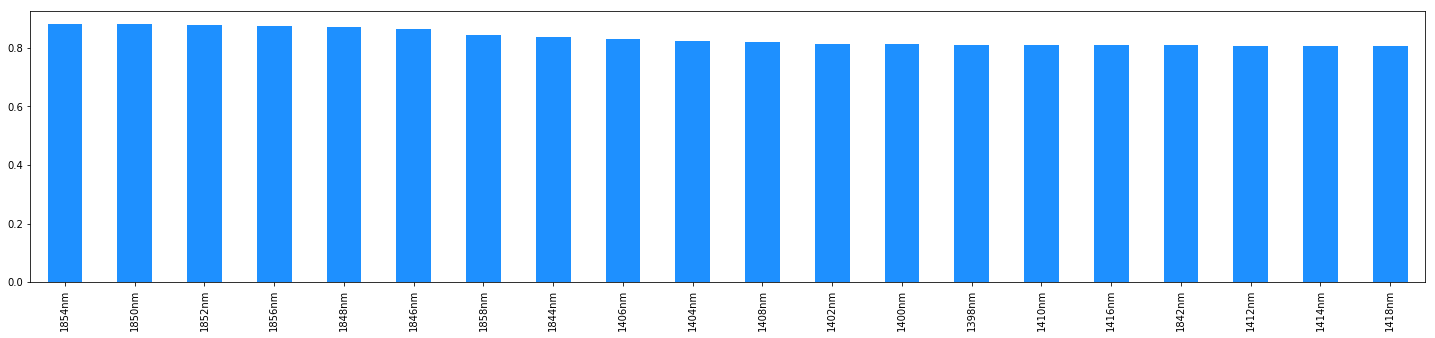

In [43]:
enzima = 'betaglicosidase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:20].plot.bar(figsize=(25,5),color=cores[52:53])
print('--------------------------------------')

In [44]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.5]
print(temp)
#Lista das variáveis menos importantes
temp.sort_values()[:50].index
print('Total de variáveis menos importantes:(correlação <.5):', len(temp))
tempMais=sel_mi_graph[enzima][sel_mi_graph[enzima]>.5]
print('Mais importantes: ', len(tempMais))


 Variáveis MENOS importantes para betaglicosidase:
2098nm    0.499658
2096nm    0.498166
2258nm    0.495446
2102nm    0.495194
1554nm    0.494600
1556nm    0.493896
2078nm    0.492994
1452nm    0.491706
2288nm    0.491580
1818nm    0.489366
2082nm    0.489120
2242nm    0.487937
2094nm    0.487476
2088nm    0.486619
2268nm    0.485196
2092nm    0.484367
2080nm    0.483627
1558nm    0.482402
2236nm    0.478893
2270nm    0.478364
2104nm    0.478140
2090nm    0.478124
1872nm    0.476534
1560nm    0.472173
2272nm    0.471982
2238nm    0.469662
2234nm    0.468252
1816nm    0.468166
2274nm    0.466237
1572nm    0.465490
            ...   
1904nm    0.076898
1914nm    0.076198
2362nm    0.071148
1958nm    0.070960
1956nm    0.069745
1980nm    0.065270
1944nm    0.062838
1916nm    0.062232
1972nm    0.061225
1960nm    0.061202
2374nm    0.059694
1924nm    0.059263
1942nm    0.057150
1926nm    0.056089
1928nm    0.054908
1950nm    0.054827
1920nm    0.054798
1934nm    0.054765
1918nm    0.05474

In [45]:
tempMais =tempMais[:20]

In [83]:
tempMais.sort_index()

1396nm    0.806663
1398nm    0.812113
1400nm    0.817569
1402nm    0.813612
1404nm    0.825442
1406nm    0.830698
1408nm    0.820297
1410nm    0.807202
1412nm    0.801159
1414nm    0.802987
1416nm    0.806282
1842nm    0.811006
1844nm    0.839974
1846nm    0.869802
1848nm    0.871159
1850nm    0.880458
1852nm    0.878039
1854nm    0.882168
1856nm    0.874932
1858nm    0.844794
dtype: float64


 Variáveis MENOS importantes para betaglicosidase:


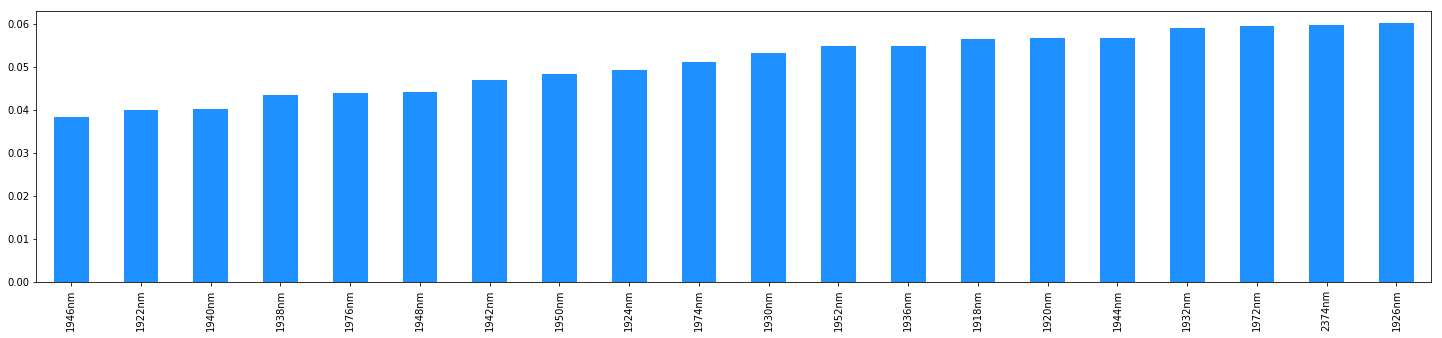

In [84]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:20].plot.bar(figsize=(25,5),color=cores[52:53])

In [85]:
menos = temp.sort_values()[:20]

In [86]:
menos.sort_index()

1918nm    0.056467
1920nm    0.056589
1922nm    0.039949
1924nm    0.049325
1926nm    0.060017
1930nm    0.053193
1932nm    0.059072
1936nm    0.054900
1938nm    0.043417
1940nm    0.040190
1942nm    0.046957
1944nm    0.056681
1946nm    0.038438
1948nm    0.044095
1950nm    0.048214
1952nm    0.054881
1972nm    0.059539
1974nm    0.051025
1976nm    0.044005
2374nm    0.059717
dtype: float64


 Variáveis mais importantes para cmcase:
--------------------------------------


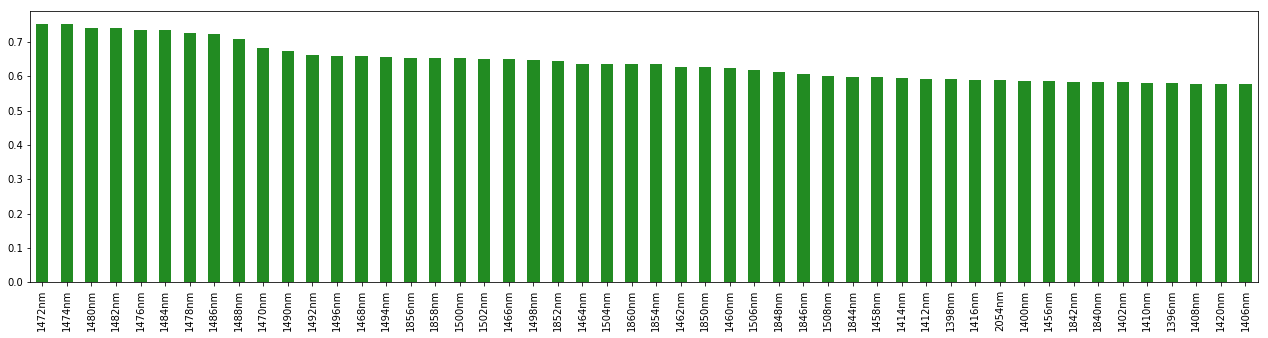

In [135]:
enzima = 'cmcase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:50].plot.bar(figsize=(22,5),color=cores[55:56])
print('--------------------------------------')
mais = sel_mi_graph[enzima]

In [136]:
mais=sel_mi_graph[enzima][sel_mi_graph[enzima]>.5]
menos=sel_mi_graph[enzima][sel_mi_graph[enzima]<.5]
print('Cmc: mais:', len(mais),'menos:',len(menos))

Cmc: mais: 132 menos: 566


In [137]:
mais[:20].sort_index()

1466nm    0.648464
1468nm    0.658241
1470nm    0.681719
1472nm    0.752874
1474nm    0.750314
1476nm    0.733924
1478nm    0.725655
1480nm    0.740171
1482nm    0.739572
1484nm    0.733157
1486nm    0.721727
1488nm    0.708094
1490nm    0.673948
1492nm    0.661913
1494nm    0.656885
1496nm    0.659335
1500nm    0.652209
1502nm    0.650597
1856nm    0.653324
1858nm    0.652945
dtype: float64

In [138]:
menos=menos.sort_values()[:20]

In [139]:
menos.sort_index()

1916nm    0.062937
1918nm    0.055120
1920nm    0.059318
1922nm    0.046420
1924nm    0.062279
1926nm    0.061987
1928nm    0.044231
1930nm    0.061243
1934nm    0.062510
1936nm    0.057576
1938nm    0.059509
1940nm    0.053258
1942nm    0.067136
1944nm    0.054028
1946nm    0.038953
1950nm    0.051721
1970nm    0.062003
1976nm    0.064802
1978nm    0.056325
2366nm    0.063663
dtype: float64

In [140]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.5]
#Lista das variáveis menos importantes



 Variáveis MENOS importantes para cmcase:



 Variáveis MENOS importantes para cmcase:


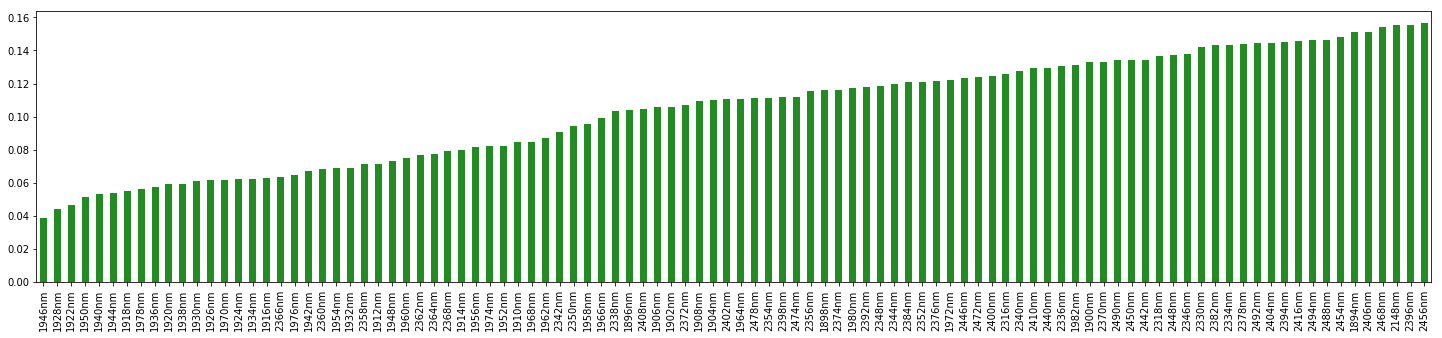

In [141]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:100].plot.bar(figsize=(25,5),color=cores[55:56])


 Variáveis mais importantes para fpase:
--------------------------------------


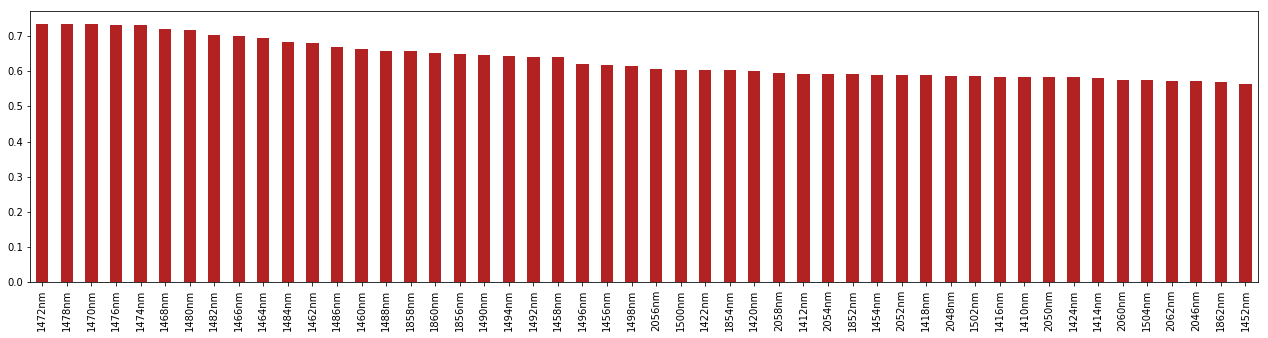

In [142]:
enzima = 'fpase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:50].plot.bar(figsize=(22,5),color=cores[53:54])
print('--------------------------------------')
mais = sel_mi_graph[enzima][:50]

In [143]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
menos = temp
temp.sort_values()[:50].index


 Variáveis MENOS importantes para fpase:


Index(['1974nm', '1970nm', '1968nm', '2474nm', '2384nm', '2368nm', '1976nm',
       '1932nm', '2398nm', '1950nm', '2370nm', '1914nm', '1972nm', '1918nm',
       '2378nm', '1944nm', '1948nm', '1946nm', '1920nm', '1952nm', '1924nm',
       '1928nm', '1916nm', '2376nm', '1926nm', '1934nm', '1936nm', '1956nm',
       '1930nm', '2380nm', '2362nm', '1922nm', '2374nm', '1958nm', '1938nm',
       '1942nm', '1962nm', '1954nm', '2476nm', '2442nm', '1960nm', '2402nm',
       '2386nm', '2372nm', '2394nm', '1898nm', '1910nm', '1940nm', '1904nm',
       '1912nm'],
      dtype='object')

In [144]:
mais[:20].sort_index()
#fpase

1460nm    0.661921
1462nm    0.679802
1464nm    0.695313
1466nm    0.701198
1468nm    0.719355
1470nm    0.732637
1472nm    0.735143
1474nm    0.730203
1476nm    0.730554
1478nm    0.734256
1480nm    0.718004
1482nm    0.703268
1484nm    0.683299
1486nm    0.668279
1488nm    0.658122
1490nm    0.646374
1494nm    0.642723
1856nm    0.648996
1858nm    0.657975
1860nm    0.650953
dtype: float64

In [145]:
menos=menos.sort_values()[:20]
menos.sort_index()

1914nm    0.068909
1918nm    0.069831
1920nm    0.071042
1932nm    0.065978
1944nm    0.070202
1946nm    0.070864
1948nm    0.070665
1950nm    0.067804
1952nm    0.071893
1968nm    0.042551
1970nm    0.040830
1972nm    0.069433
1974nm    0.036001
1976nm    0.063806
2368nm    0.062004
2370nm    0.068810
2378nm    0.069962
2384nm    0.058679
2398nm    0.066869
2474nm    0.050865
dtype: float64


 Variáveis MENOS importantes para fpase:


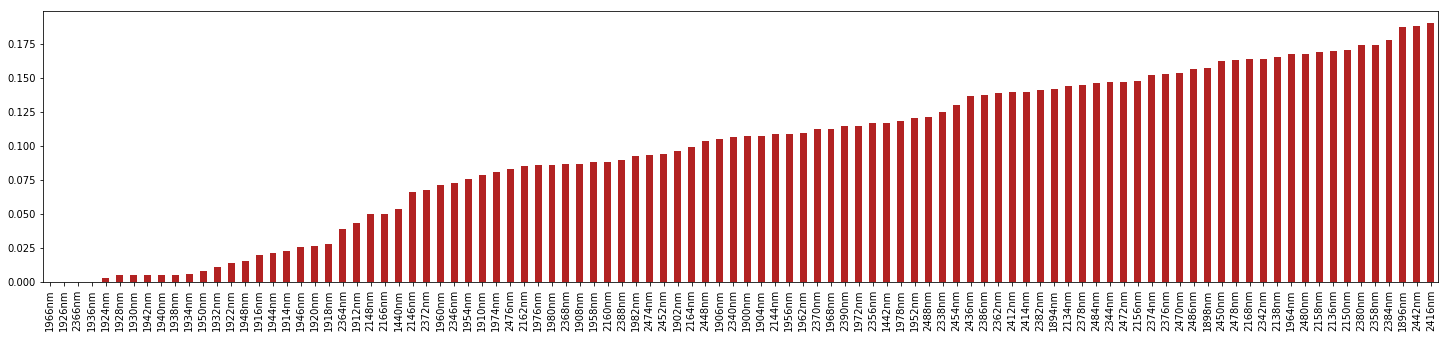

In [41]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:100].plot.bar(figsize=(25,5),color=cores[53:54])


 Variáveis mais importantes para xilanase:
--------------------------------------


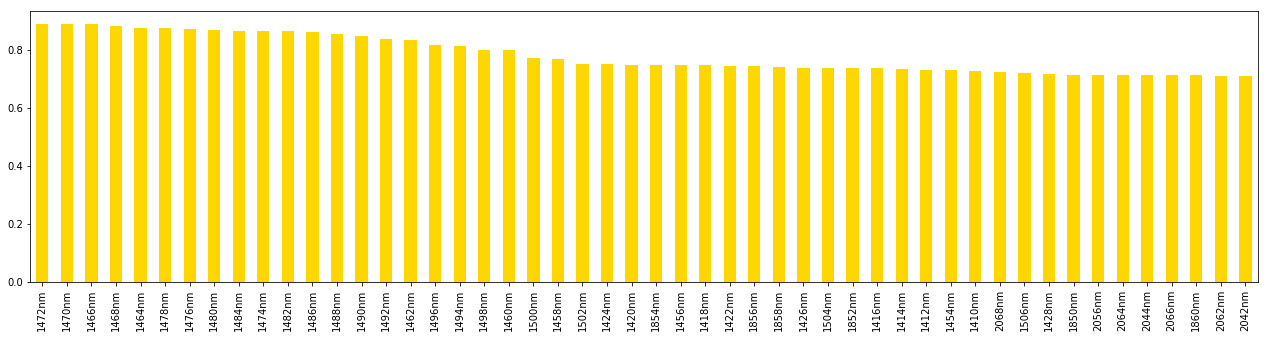

In [146]:
enzima = 'xilanase'
print('\n Variáveis mais importantes para %s:'%enzima)
sel_mi_graph[enzima][:50].plot.bar(figsize=(22,5),color=cores[59:60])
print('--------------------------------------')

In [152]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:50].index



 Variáveis MENOS importantes para xilanase:


Index(['1968nm', '1932nm', '2362nm', '1934nm', '1938nm', '1940nm', '1942nm',
       '2346nm', '1930nm', '1936nm', '2344nm', '1916nm', '1972nm', '1944nm',
       '2356nm', '1956nm', '1928nm', '1922nm', '1924nm', '1926nm', '1970nm',
       '1918nm', '2376nm', '1948nm', '1946nm', '2378nm', '2364nm', '1958nm',
       '1950nm', '1954nm', '1920nm', '2360nm', '2350nm', '1976nm', '1914nm',
       '1960nm', '1912nm', '1308nm', '2382nm', '1966nm', '1306nm', '1322nm',
       '2398nm', '2372nm', '1312nm', '1304nm', '1310nm', '1320nm', '1314nm',
       '1952nm'],
      dtype='object')

In [150]:
mais = sel_mi_graph[enzima][:20]
mais.sort_index()

1460nm    0.797885
1462nm    0.834778
1464nm    0.875199
1466nm    0.886867
1468nm    0.880083
1470nm    0.888041
1472nm    0.889739
1474nm    0.865718
1476nm    0.871688
1478nm    0.873188
1480nm    0.866267
1482nm    0.864765
1484nm    0.865906
1486nm    0.860890
1488nm    0.853000
1490nm    0.848309
1492nm    0.837434
1494nm    0.813828
1496nm    0.816441
1498nm    0.800433
dtype: float64

In [154]:
menos = sel_mi_graph[enzima][sel_mi_graph[enzima]<.3][:20]

In [159]:
menos=menos.sort_values()
menos.sort_index()

1374nm    0.292285
1604nm    0.299974
1606nm    0.294752
1608nm    0.297663
1610nm    0.296935
1612nm    0.294867
1614nm    0.295552
1616nm    0.291861
1618nm    0.286741
1620nm    0.285912
1622nm    0.289610
1624nm    0.288012
1626nm    0.285817
1628nm    0.287364
1630nm    0.285395
1632nm    0.284466
1634nm    0.283428
1636nm    0.281662
1810nm    0.294155
2136nm    0.293733
dtype: float64


 Variáveis MENOS importantes para xilanase:


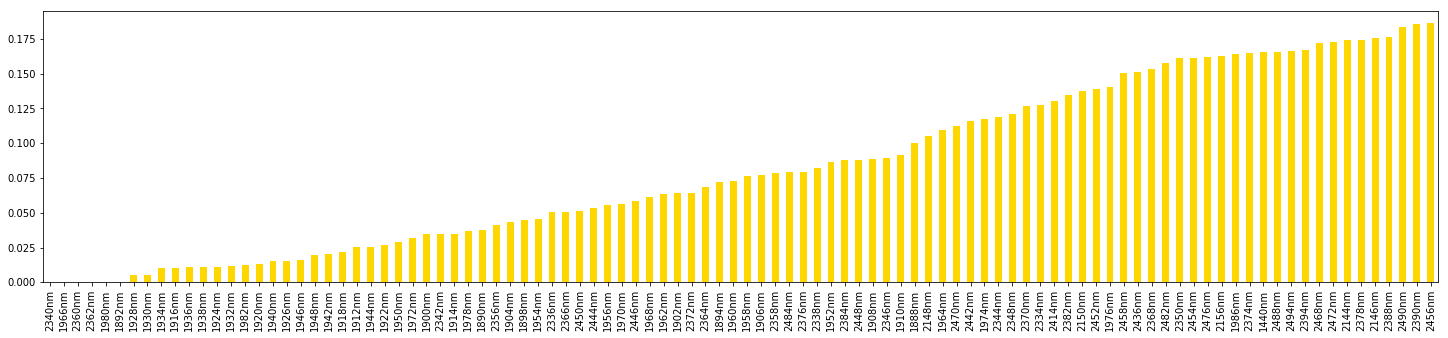

In [44]:
print('\n Variáveis MENOS importantes para %s:'%enzima)
temp=sel_mi_graph[enzima][sel_mi_graph[enzima]<.3]
#Lista das variáveis menos importantes
temp.sort_values()[:100].plot.bar(figsize=(25,5),color=cores[59:60])

In [46]:
#verificando o total de variáveis com correlação maior que 0.8 para cada atividade enzimática
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
total={'betaglicosidase':0,'cmcase':0,'fpase':0,'xilanase':0}
for valor in var_ae:
    total[valor]=len(sel_mi_graph[valor][sel_mi_graph[valor]>.7])
print('Total de variáveis com correlação superior a .8 para cada enzima\n')
for valor in var_ae:
    print(valor,':',total[valor])    

Total de variáveis com correlação superior a .8 para cada enzima

betaglicosidase : 308
cmcase : 105
fpase : 306
xilanase : 277


In [47]:
#verificando o total de variáveis que mais se correlacionam com  cada atividade enzimática
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
total={'betaglicosidase':0,'cmcase':0,'fpase':0,'xilanase':0}
corr = [0.95,0.7,.95,0.85]
for valor,i in zip(var_ae,[0,1,2,3]):
    total[valor]=len(sel_mi_graph[valor][sel_mi_graph[valor]>corr[i]])
print('Total de variáveis com correlação alta para cada enzima\n')
for valor in var_ae:
    print(valor,':',total[valor])     

Total de variáveis com correlação alta para cada enzima

betaglicosidase : 115
cmcase : 105
fpase : 163
xilanase : 169


In [ ]:
'''
#Exibindo as variáveis mais significativas 
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
corr = [1,0.7,1,0.85]
for valor,i in zip(var_ae,[0,1,2,3]):
    print('\nAtributos + significativos para:',valor)
    print(sel_mi_graph[valor][sel_mi_graph[valor]>corr[i]].index[:30])
'''

In [48]:
#Considerando o total de cada atividade, as variáveis mais significativas de cada atividade foram anexadas para depois remover as repetições
sel_ = {}
for valor in var_ae:
    sel_[valor] = list(sel_mi_graph[valor].index)
sel_2 = []
for valor in var_ae:
    sel_2 += sel_[valor][:total[valor]]
#elimina repetições:
sel_2 = list(set(sel_2))

print('Total de variáveis significativas sem repetição:',len(sel_2))

Total de variáveis significativas sem repetição: 244


In [49]:
#ordena as variáveis por nome
sel_2.sort()
print('Variáveis mais sigificativas:',sel_2)


Variáveis mais sigificativas: ['1128nm', '1130nm', '1132nm', '1134nm', '1136nm', '1138nm', '1142nm', '1144nm', '1146nm', '1148nm', '1150nm', '1152nm', '1154nm', '1168nm', '1170nm', '1176nm', '1178nm', '1180nm', '1182nm', '1184nm', '1274nm', '1276nm', '1278nm', '1284nm', '1326nm', '1328nm', '1330nm', '1332nm', '1334nm', '1336nm', '1338nm', '1340nm', '1342nm', '1344nm', '1346nm', '1348nm', '1350nm', '1352nm', '1354nm', '1356nm', '1358nm', '1360nm', '1362nm', '1364nm', '1366nm', '1368nm', '1370nm', '1372nm', '1374nm', '1376nm', '1378nm', '1380nm', '1382nm', '1384nm', '1386nm', '1388nm', '1390nm', '1392nm', '1394nm', '1396nm', '1398nm', '1400nm', '1402nm', '1404nm', '1406nm', '1408nm', '1410nm', '1412nm', '1414nm', '1416nm', '1418nm', '1420nm', '1422nm', '1424nm', '1426nm', '1428nm', '1456nm', '1458nm', '1460nm', '1462nm', '1464nm', '1466nm', '1468nm', '1470nm', '1472nm', '1474nm', '1476nm', '1478nm', '1480nm', '1482nm', '1484nm', '1486nm', '1488nm', '1490nm', '1492nm', '1494nm', '1496nm',

In [50]:
#renomear as absorbâncias
var_abs_txt = sel_2.copy()

# Outliers

* Após verificar as variáveis mais importantes, vamos utilizá-las para conferir possíveis outliers

In [1650]:
#2
#Ouliers: realizar teste com o arquivo D_outliers, nesse mesmo diretório

In [ ]:
#amostras 28,30 e 62 que representam os pontos 
amostra: descrição exper  temperatura tempoRetirada
28 : bio_p3_t1_2   biof    30    72
30 : bio_p3_t2_1   biof    30    72
62 : bio_p6_t3_3   biof    30    144

In [1671]:
#Resetando o índice dos dados:
dados=dados.reset_index(drop=True)
dados.index

RangeIndex(start=0, stop=81, step=1)

In [2399]:
dados_com_outliers = dados_back.copy()

In [1545]:
dados = dados_com_outliers.copy()

In [1546]:
dados = dados[(dados['eenz'] == 'eeta')&(dados['experimento']=='biof')]

In [1662]:
outliers = [28,30,62]
#removendo as amostras consideradas outliers (testar os algoritmos sem remover outlier e após remover)
dados = dados.drop(outliers)

In [1663]:
dados.shape

(78, 713)

# Definição das variáveis

**variáveis para os processamentos: (antes ou após remoção de outliers, com ou sem seleção de atributos:**

In [245]:
#@var_abs_txt
#@var_abs_int
# Opções de definição da variável das absorbâncias

In [46]:
#opção 1: Escolha de todos os valores de absorbância (sem nenhuma selação de atributos)
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
#criando vetores com os nomes dos atributos

#criando um vetor com os nomes das absorbâncias para selação posterior
var_abs_int = np.arange(1100,2496,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']

In [296]:
#opção 2: Escolha de algumas absorbâncias e exclusão de outras - duas faixas excluídas (apenas observando os ruídos graficamente)
#variáveis após excluir algumas bandas do espectro
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
#criando vetores com os nomes dos atributos

abs1 = np.arange(1100,1875,2)
abs2 = np.arange(1974,2351,2)
var_abs_int = np.concatenate((abs1,abs2),axis=0)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']


In [291]:
#opção 3: Exclusão da faixa final de ruido, a partir da abs 2350
#variáveis após excluir algumas bandas do espectro
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
#criando vetores com os nomes dos atributos

var_abs_int = np.arange(1100,2351,2)
var_abs_txt=[]
for valor in var_abs_int:
    var_abs_txt += [str(valor)+'nm']

In [211]:
#opção 4: Definição das absorbâncias através da seleção de atributos feita previamente
var_abs_txt = sel_2.copy()
var_ae=['betaglicosidase','cmcase','fpase','xilanase']
var_abs_int=[]
for valor in var_abs_txt:
    var_abs_int += [int(valor[:4])]

NameError: name 'sel_2' is not defined

In [47]:
#Variável para trabalhar no pré-processamento dos espectros
preProc = {0:'Pré-proc: 0--> Sem pré-processamento', 
           1:'Pré-proc: 1--> Padronização', 
           2:'Pré-proc: 2--> Suavização(SavGol) - Par:3,1,1', 
           3:'Pré-proc: 3--> Suavização(SavGol) - Par:3,2,1',
           4:'Pré-proc: 4--> Suavização(SavGol) - Par:5,1,1',
           5:'Pré-proc: 5--> Suavização(SavGol) - Par:5,2,1',
           6:'Pré-proc: 6--> Suavização(SavGol) - Par:3,2,2',
           7:'Pré-proc: 7--> Suavização(SavGol) - Par:5,2,2',
           8:'Pré-proc: 8--> Suavização(SavGol) - Par:3,1,1 --> Padronização',
           9:'Pré-proc: 9--> Padronização --> Suavização(SavGol) - Par:3,1,1',
           10:'Pré-proc: 10--> MSC',
           11:'Pré-proc: 11--> SNV'}

## Definindo x e y

In [396]:
#escolhendo a base de dados
#dados = dados1.copy() #celluclast
#dados = dados2.copy()#EETA
dados = dados3.copy()#CELIC
#dados = dados4.copy()#eeta biof

In [48]:
#@dfxy
#Definindo os dataFrames iniciais a partir da base de dados escolhida e pré-processada
df_x = dados.loc[:,var_abs_txt] #absorbâncias
df_y = dados.loc[:,var_ae]#AE

In [408]:
df_x.shape

(1340, 698)

In [118]:
#se precisar eliminar colunas com dados nulos
#dadosb=dados.dropna(axis=1)


# Análise incial da base de dados e de seu conteúdo através de PCA

In [49]:
#@pca
#utilizar o PCA para reduzir as dimensões e poder analisar os dados
#Para utilizar o PCA é necessário realizar a normalização dos dados (tornar a variância unitária)
#pré-processamento
scaler = StandardScaler()
scaler.fit(df_x)
df_x_scaler = scaler.transform(df_x)
pca = PCA(n_components=10)
#treinar o pca com os dados padronizados
pca.fit(df_x_scaler)
#Após treinar o pca, agora posso transformar os dados
x_pca = pca.transform(df_x_scaler)
print('Dados originais:',df_x.shape,'Pós PCA:', x_pca.shape)

Dados originais: (938, 698) Pós PCA: (938, 10)


In [ ]:
#Formatação de fonte nos gráficos
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#fig.tight_layout() #melhorando a visualziação dos gráficos sobrepostos mas muda a fonte
#plt.subplots_adjust(hspace = .5)#ajusta altura entre um gráfico e outro

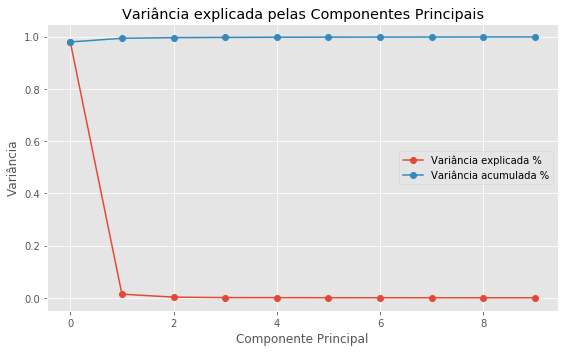

In [50]:
#Exibindo a variância explicada pelas componentes principais
variancia_explicada = pca.explained_variance_ratio_[:10]
# Explicação da variância pelas componentes principais
with plt.style.context(('ggplot')):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig.set_tight_layout(True)

    ax1.plot(variancia_explicada,'-o', label="Variância explicada %")
    ax1.plot(np.cumsum(variancia_explicada),'-o', label = 'Variância acumulada %')
    ax1.set_xlabel("Componente Principal")
    ax1.set_ylabel("Variância")

    ax1.set_title('Variância explicada pelas Componentes Principais')    
    plt.legend()
    plt.show()  

Text(0, 0.5, 'Variância')

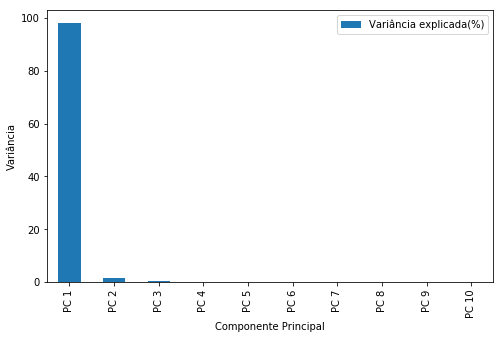

In [51]:
perc = pca.explained_variance_ratio_ * 100
perc = pd.DataFrame(perc, columns=['Variância explicada(%)'], index=['PC %s' % pc for pc in np.arange(len(perc)) + 1])
ax = perc.plot(kind='bar', figsize=(8,5))
ax.set_xlabel("Componente Principal")
ax.set_ylabel("Variância")

    

In [52]:
texto = ''
perc['Variância acumulada(%)'] = np.cumsum(pca.explained_variance_ratio_[:10])
perc


Variância explicada(%)  Variância acumulada(%)
PC 1                97.970918                0.979709
PC 2                 1.393188                0.993641
PC 3                 0.260494                0.996246
PC 4                 0.081176                0.997058
PC 5                 0.065242                0.997710
PC 6                 0.033772                0.998048
PC 7                 0.025314                0.998301
PC 8                 0.022080                0.998522
PC 9                 0.019240                0.998714
PC 10                0.016699                0.998881

In [53]:
loadings = pd.DataFrame(pca.components_.T)
loadings.index = ['A %s' % pc for pc in loadings.index + 1]
loadings.columns = ['PC %s' % pc for pc in loadings.columns + 1]
PCs = np.dot(loadings.values.T, df_x.T)
marker = dict(linestyle='none', marker='o', markersize=7, color='blue', alpha=0.5)


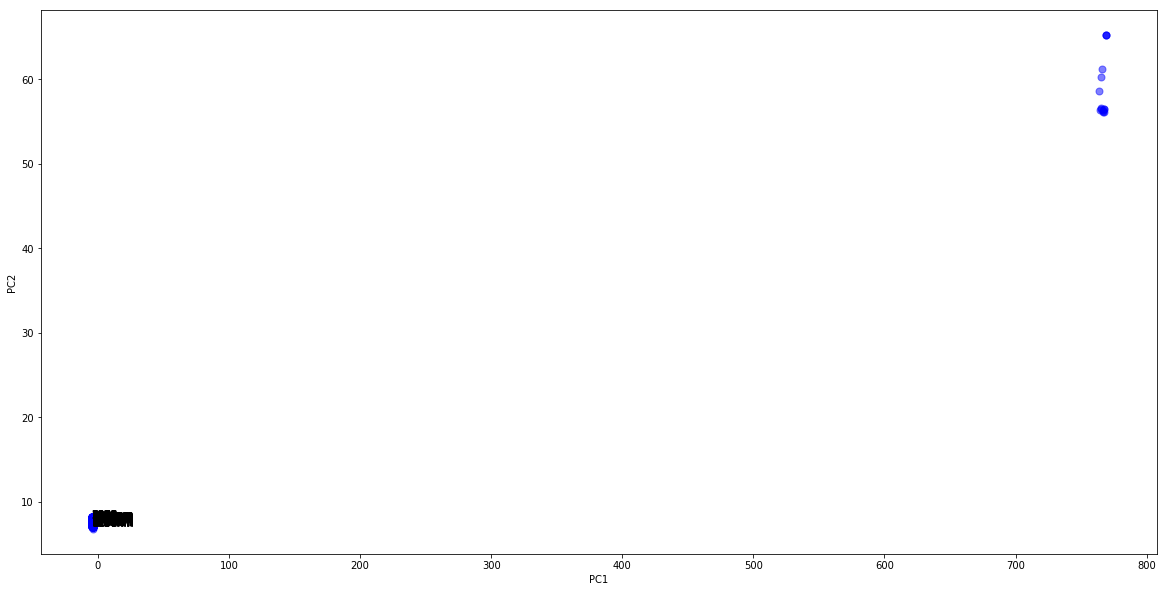

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(PCs[0], PCs[1], label="Scores", **marker)

ax.set_xlabel("PC1")

ax.set_ylabel("PC2")

text = [ax.text(x, y, t) for x, y, t in
        zip(PCs[0], PCs[1], df_x.columns)]

In [204]:
PCs.shape, df_x.shape, loadings.shape

((7, 938), (938, 698), (698, 7))

In [55]:
#dataframes separados por intervalo de tempo, temperatura, experimento e ae
#servirão para fazer análises gráficas com PCA
temp_yinter = dados.loc[:,'inter']
temp_ye = dados.loc[:,'eenz']
temp_yt = dados.loc[:,'temp']
temp_yex = dados.loc[:,'experimento']
temp_ybeta = dados.loc[:,'betaglicosidase']
temp_ycmc = dados.loc[:,'cmcase']
temp_yfpase = dados.loc[:,'fpase']
temp_yxil = dados.loc[:,'xilanase']

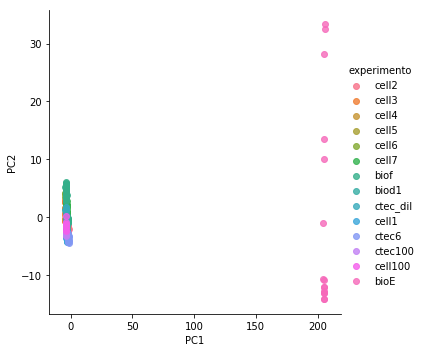

In [56]:
#configurando paleta de cores
palettes = ["deep", "muted", "pastel", "bright", "dark", "colorblind"]
#Desenhando o gráfico dos scores da PC1 com PC2 diferenciando por experimento
dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,1],temp_yex), columns=["PC1", "PC2", "experimento"])
sns.lmplot("PC1", "PC2", dados_plot, hue="experimento", fit_reg=False)
plt.rcParams['figure.figsize']=(20,10)

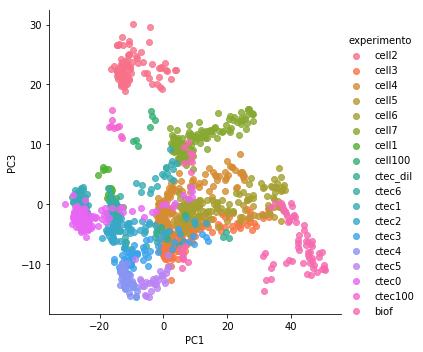

In [429]:
dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,2],temp_yex), columns=["PC1", "PC3", "experimento"])
sns.lmplot("PC1", "PC3", dados_plot, hue="experimento", fit_reg=False)
plt.rcParams['figure.figsize']=(20,10)

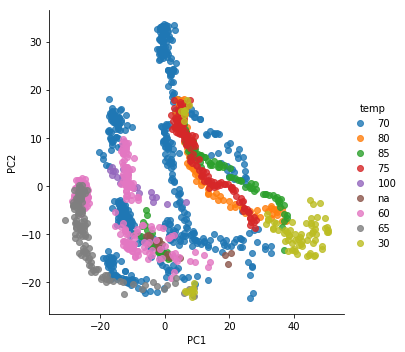

In [430]:
dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,1],temp_yt), columns=["PC1", "PC2", "temp"])
sns.lmplot("PC1", "PC2", dados_plot, hue="temp", fit_reg=False)
plt.rcParams['figure.figsize']=(20,10)

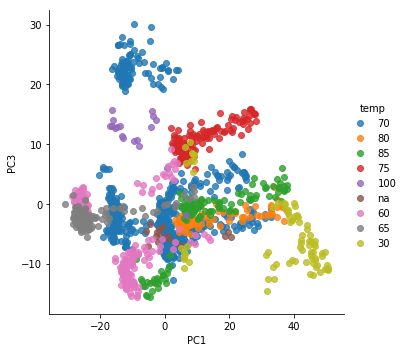

In [431]:
dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,2],temp_yt), columns=["PC1", "PC3", "temp"])
sns.lmplot("PC1", "PC3", dados_plot, hue="temp", fit_reg=False)
plt.rcParams['figure.figsize']=(20,10)

In [132]:
#Como selecionar amostras partindo dos gráficos gerados.
#assim dá pra separar as amostras em função da apresentação dada
#exemplo: biof = dados_plot[(dados_plot['PC2'] >-10) ]

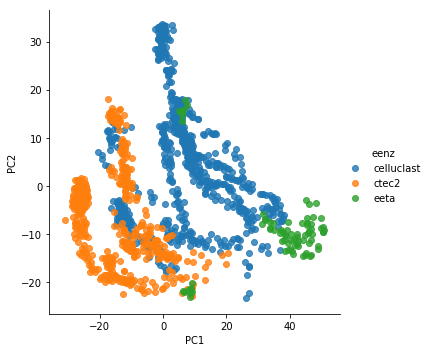

In [433]:
#Desenhando o gráfico dos scores da PC1 com PC2 diferenciando por tempo de fermentação ou desnaturação
dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,1],temp_ye), columns=["PC1", "PC2", "eenz"])
sns.lmplot("PC1", "PC2", dados_plot, hue="eenz", fit_reg=False)
plt.rcParams['figure.figsize']=(15,10)



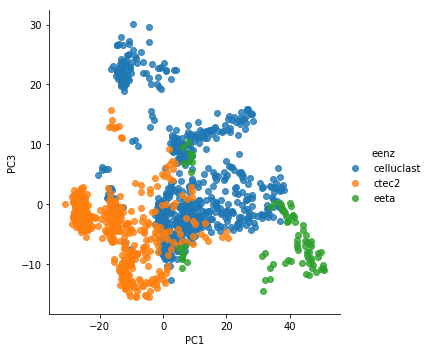

In [434]:

dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,2],temp_ye), columns=["PC1", "PC3", "eenz"])
sns.lmplot("PC1", "PC3", dados_plot, hue="eenz", fit_reg=False)
plt.rcParams['figure.figsize']=(15,10)

In [ ]:
dados_plot = pd.DataFrame(zip(x_pca[:,0],x_pca[:,1],temp_yinter), columns=["PC1", "PC2", "inter"])
sns.lmplot("PC1", "PC2", dados_plot, hue="inter", fit_reg=False)
plt.rcParams['figure.figsize']=(15,10)


In [ ]:
#Após separação de dados dará para selecionar algum conjunto de dados com características comuns

In [283]:
#verifica quais dados estão separados no biof
#biof = dados_plot[(dados_plot['PC2'] >-10) & (dados_plot['PC1']<0)  ]

In [284]:
#biof = dados.iloc[list(biof.index)]

In [1095]:
#Separa os dados do experimento da fermentação e da desnaturação

#biod = dados[ dados['experimento'] == 'biod1']
#biof = dados[ dados['experimento'] == 'biof']
#bioe = dados[ dados['experimento'] == 'bioE']

In [1097]:
#biod.shape, biof.shape, bioe.shape

((33, 713), (81, 713), (24, 713))

In [146]:
#Definindo os dataFrames iniciais a partir da base de dados escolhida e pré-processada
df_x = dados.loc[:,var_abs_txt] #absorbâncias
df_y = dados.loc[:,var_ae]#AE

# Função de pré-processamento

In [15]:
#@preproc
def executaPreproc(preproc, padroniza = False,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = train_test_split(df_x,df_y,test_size=0.25, random_state=IC)
    
    #parâmetros para savgol: janela,grau do polinômio,derivada
    par = [3,1,1]
    #sem pré-processamento preproc=0
    if preproc == 1:       #preproc=1: padronização (z=(xi-m)/s) SNV
        if padroniza: #padroniza y
            y_treino = StandardScaler().fit_transform(y_treino.values)#treino
            y_teste = StandardScaler().fit_transform(y_teste.values)#teste
            
        x_treino = StandardScaler().fit_transform(x_treino.values)#treino
        x_teste = StandardScaler().fit_transform(x_teste.values)#teste        
    elif preproc in range(2,8):
        if preproc == 2: #SG:3,1,1
            par=[3,1,1]
        elif preproc == 3:
            par=[3,2,1]
        elif preproc == 4:
            par=[5,1,1]
        elif preproc == 5:
            par=[5,2,1]
        elif preproc == 6:
            par=[3,2,2]
        elif preproc == 7:
            par=[5,2,2]
        x_treino = savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2]) #treino
        x_teste = savgol_filter(x_teste, par[0], polyorder = par[1], deriv=par[2]) #teste        
    elif preproc == 8:
        x_treino = savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2]) #treino
        x_teste = savgol_filter(x_teste, par[0], polyorder = par[1], deriv=par[2]) #teste
        x_treino = StandardScaler().fit_transform(x_treino[:,:])#treino
        x_teste = StandardScaler().fit_transform(x_teste[:,:])#teste
    elif preproc == 9:
        x_treino = StandardScaler().fit_transform(x_treino.values)#treino
        x_teste = StandardScaler().fit_transform(x_teste.values)#teste
        x_treino = savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2]) #treino
        x_teste = savgol_filter(x_teste, par[0], polyorder = par[1], deriv=par[2]) #teste
    elif preproc == 10:
        x_treino = msc(x_treino.values)[0]
        x_teste = msc(x_teste.values)[0]
    elif preproc == 11:
        x_treino = snv(x_treino.values)
        x_teste = snv(x_teste.values)
    return (x_treino, x_teste, y_treino, y_teste)

In [16]:
def executaPreprocSimples(preproc,x):
    #parâmetros para savgol: janela,grau do polinômio,derivada
    par = [3,1,1]
    if preproc == 1:       
        x = StandardScaler().fit_transform(x.values)      
    elif preproc in range(2,8):
        if preproc == 2:
            par=[3,1,1]
        elif preproc == 3:
            par=[3,2,1]
        elif preproc == 4:
            par=[5,1,1]
        elif preproc == 5:
            par=[5,2,1]
        elif preproc == 6:
            par=[3,2,2]
        elif preproc == 7:
            par=[5,2,2]
        x= savgol_filter(x_treino, par[0], polyorder = par[1], deriv=par[2])          
    elif preproc == 8:
        x = savgol_filter(x, par[0], polyorder = par[1], deriv=par[2]) 
        x = StandardScaler().fit_transform(x[:,:])        
    elif preproc == 9:
        x = StandardScaler().fit_transform(x[:,:])
        x = savgol_filter(x, par[0], polyorder = par[1], deriv=par[2]) 
    elif preproc == 10:
        x_treino = msc(x_treino.values)[0]
        x_teste = msc(x_teste.values)[0]
    elif preproc == 11:
        x_treino = snv(x_treino.values)
        x_teste = snv(x_teste.values)
        
    return x

# Modelagem:

## Função geral de modelagem


In [17]:
#@modelagemCVP executa calibração, validação e predição
def executaCVP(treino_teste, reg):
    x_treino = treino_teste[0].copy()
    x_teste = treino_teste[1].copy()
    y_treino = treino_teste[2].copy()
    y_teste = treino_teste[3].copy()
    
    # Fit
    reg.fit(x_treino, y_treino) 

    # Calibração
    y_c = reg.predict(x_treino)

    # Cross-validation
    y_cv = cross_val_predict(reg, x_treino, y_treino, cv=10)

    # Predição nos dados de teste
    y_p = reg.predict(x_teste)

    y = y_treino.copy()
   
    return [reg, treino_teste,y_c,y_cv,y_p]


In [18]:
#@modelagemMetrics
#Retorna tabela de resultados:
def calMetrics(reais, preditos):
    result = {}
    result['BIAS'] = round(bias(reais, preditos),4)
    result['MSE'] = round(getmse(reais, preditos),4)
    result['R2'] = round(getr2(reais, preditos),4)
    result['RER'] = round(rer(reais, preditos),4)
    result['RMSE'] = round(getrmse(reais, preditos),4)
    #result['RMSE'] = rmse(reais, preditos)    
    result['RPD'] = round(rpd(reais, preditos),4)
    result['RPIQ'] = round(rpiq(reais, preditos),4)
    result['SEP'] = round(sep(reais, preditos),4)    
    return result

In [19]:
#@modelagemcalvalpred
#exibe resultados para calibração, vaidação cruzada e predição
def retornaCVP(y,yp):
    #yp contem os valores estimados da calibração, validação e teste
    var = ['cal','val', 'pred']
    var_ae=['betaglicosidase','cmcase','fpase','xilanase']
    res_cvp = {}
    for i in range(3):
        if i <2:
            j=0
        else:
            j=1
        for e,ie in zip(var_ae,[0,1,2,3]):
            reais = y[j].loc[:,e]
            pred = yp[i][:,ie]
            r = pd.Series(calMetrics(reais, pred))
            if ie == 0:
                res = pd.DataFrame(r, index=r.index, columns=[e])
            else:
                res[e] = r
        res_cvp[var[i]] = res
    return res_cvp

In [55]:
#@modelagemPred teste externo para predição com bases de dados diversas
#exibe resultados predição
def retornaPred(y,yp):
    #yp contem os valores estimados da predição
    var_ae=['betaglicosidase','cmcase','fpase','xilanase']
    res = {}
    for e,ie in zip(var_ae,[0,1,2,3]):
        reais = y[0].loc[:,e]
        pred = yp[0][:,ie]
        r = pd.Series(calMetrics(reais, pred))
        if ie == 0:
            res = pd.DataFrame(r, index=r.index, columns=[e])
        else:
            res[e] = r
        res[ie] = res
    return res

In [21]:
#@modelagemResultados
def exibeResultados(result):
    #recuperando resultados da modelagem
    reg, treino_teste,y_c,y_cv,y_p = result

    #x_treino, x_teste, y_treino, y_teste = treino_teste
    y_ = [treino_teste[2].reset_index(drop=True),treino_teste[3].reset_index(drop=True)]
    yp=[y_c,y_cv,y_p]
    resultados = retornaCVP(y_, yp)
    return resultados

## PCA->KNN

In [22]:
#pcaknn
#função completa para execução do PCA-->KNN:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPCA_KNN(preproc, nPC,vizinhos, padroniza=False, ic=0):
    #separando o conjunto de dados em treino e teste
    
    #separando o conjunto de dados em treino e teste
    #x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,True)
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,padroniza,ic)

    
    # Roda o PCA e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC]    
    
    #Passo 2: Aplicar o KNN sobre as componentes selecionadas
    reg = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=vizinhos))
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

### PCA->KNN: testes

In [71]:
#pcaknn teste simples
#teste simples:
modelo = 'PCA-KNN:'
preproc=1
nPC=3
k=1
result = executaPCA_KNN(preproc,nPC,k)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
'''
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')'''

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)


"\nfor k,v in zip(resultados.keys(),resultados.values()):\n    print(k)\n    print(v,'\n-----------------------------------------------------')"

In [72]:
resultados['cal']

betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0

In [73]:
resultados['val']

betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0096   0.0012   0.0007    0.2166
MSE            0.0142   0.0002   0.0001    9.6653
R2             0.9945   0.8802   0.9214    0.7825
RER           38.1274  12.0524  11.1603    6.4154
RMSE           0.1193   0.0132   0.0073    3.1089
RPD           13.4932   2.8893   3.5661    2.1442
RPIQ          27.0767   3.3201   6.7580    2.8813
SEP            0.1199   0.0133   0.0073    3.1275

In [74]:
resultados['pred']

betaglicosidase  cmcase    fpase  xilanase
BIAS           0.2072  0.0000   0.0011    0.3035
MSE            0.2883  0.0004   0.0000    2.1676
R2             0.8740  0.5105   0.9163    0.9350
RER            7.6223  5.2184  11.0451   13.5731
RMSE           0.5369  0.0187   0.0067    1.4723
RPD            2.8170  1.4293   3.4557    3.9233
RPIQ           5.8368  1.5272   6.1996    2.6361
SEP            0.5075  0.0192   0.0068    1.4762

In [86]:
#pcaknn teste completo
#pre = preprocessamento, k=número de vizinhos
modelo = 'PCA-KNN:'
print(modelo,':\n')
for nPC in range(3,4):
    print('PC:',nPC)
    for pre in range(12):
        print('Pré-processamento:\n', preProc[pre])
        for k in range(1,4):           
            result = executaPCA_KNN(pre,nPC,k)
            print('Vizinhos:', k,'\n')
            print('Parâmetros do modelo:',modelo,'\n',result[0])
            resultados=exibeResultados(result)
            for k,v in zip(resultados.keys(),resultados.values()):
                print(k)
                print(v,'\n-----------------------------------------------------')

PCA-KNN: :

PC: 3
Pré-processamento:
 Pré-proc: 0--> Sem pré-processamento
Vizinhos: 1 

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)
cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0683 -0.0052 -0.0020   -0.2889
MSE            0.4149  0.0011  0.0002   11.8507
R2             0.8399  0.217

cal
      betaglicosidase   cmcase    fpase  xilanase
BIAS          -0.0010   0.0001   0.0005    0.1701
MSE            0.0345   0.0001   0.0000    2.4646
R2             0.9867   0.9328   0.9645    0.9445
RER           24.3975  16.0204  16.6032   12.7485
RMSE           0.1859   0.0099   0.0049    1.5699
RPD            8.6621   3.8575   5.3077    4.2462
RPIQ          17.3822   4.4326  10.0585    5.7058
SEP            0.1874   0.0100   0.0049    1.5738 
-----------------------------------------------------
val
      betaglicosidase  cmcase    fpase  xilanase
BIAS           0.0123 -0.0001   0.0008    0.1444
MSE            0.1250  0.0003   0.0001    4.7048
R2             0.9518  0.7625   0.9191    0.8941
RER           12.8325  8.5223  11.0096    9.1932
RMSE           0.3536  0.0186   0.0074    2.1690
RPD            4.5534  2.0521   3.5159    3.0733
RPIQ           9.1372  2.3580   6.6630    4.1297
SEP            0.3564  0.0188   0.0074    2.1825 
---------------------------------------------

cal
      betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0301   0.0017   0.0005   -0.1111
MSE            0.0870   0.0002   0.0000    4.6371
R2             0.9664   0.8335   0.9459    0.8957
RER           15.4511  10.2391  13.4461    9.2518
RMSE           0.2950   0.0156   0.0060    2.1534
RPD            5.4572   2.4510   4.3001    3.0957
RPIQ          10.9509   2.8165   8.1490    4.1597
SEP            0.2960   0.0156   0.0061    2.1687 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0212  0.0021  0.0003    0.3755
MSE            0.2694  0.0010  0.0001   13.6283
R2             0.8961  0.3077  0.7932    0.6933
RER            8.7439  5.0023  6.8493    5.4176
RMSE           0.5190  0.0318  0.0118    3.6917
RPD            3.1019  1.2019  2.1989    1.8058
RPIQ           6.2246  1.3811  4.1670    2.4264
SEP            0.5230  0.0320  0.0119    3.7035 
-----------------------------------------------------


cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0778  0.0017 -0.0001    0.4762
MSE            0.2715  0.0013  0.0002   12.2964
R2             0.8953  0.0978  0.7587    0.7233
RER            8.8020  4.3768  6.3396    5.7270
RMSE           0.5210  0.0363  0.0127    3.5066
RPD            3.0901  1.0528  2.0358    1.9010
RPIQ           6.2009  1.2097  3.8580    2.5545
SEP            0.5195  0.0366  0.0129    3.5035 
-----------------------------------------------------
pred
      betaglicosidase 

Vizinhos: 1 

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)
cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0334  0.0057  0.0012    0.5452
MSE            0.4528  0.0015  0.0002   24.8038
R2             0.8253 -0.0018  0.6915    0.4418
RER            6.7476  4.1961  5.6258    4.0191
RMSE   

Vizinhos: 1 

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)
cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0144 -0.0013 -0.0002   -0.2357
MSE            0.3897  0.0007  0.0002   14.3631
R2             0.8497  0.5524  0.7481    0.6768
RER            7.2661  6.2153  6.2058    5.2600
RMSE   

Vizinhos: 1 

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)
cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0441  0.0015  0.0005    0.4163
MSE            0.3109  0.0011  0.0001   11.7836
R2             0.8801  0.2663  0.8216    0.7348
RER            8.1585  4.8539  7.3791    5.8392
RMSE   

In [87]:
#teste 2 escolhendo o modelo mais otimizado
modelo = 'PCA-KNN:'
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaPCA_KNN(1,3,1,False,i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.9924, 0.9748, 0.9842, 0.9846] 
semente: b c f x [81, 82, 68, 68]


In [23]:
#pcaknn teste otimizado
modelo = 'PCA-KNN:'
preproc=1
nPC=3
k=1
gera=82
result = executaPCA_KNN(preproc,nPC,k, False, gera)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: PCA-KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)


In [97]:
resultados['cal']

betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0

In [98]:
resultados['val']

betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0089   0.0012   0.0007    0.2494
MSE            0.0163   0.0002   0.0001    9.7738
R2             0.9939   0.8773   0.9127    0.7798
RER           35.6397  12.1814  10.5171    6.3845
RMSE           0.1275   0.0131   0.0077    3.1263
RPD           12.7901   2.8547   3.3844    2.1311
RPIQ          25.1981   2.7357   6.3745    2.3266
SEP            0.1283   0.0131   0.0077    3.1426

In [99]:
resultados['pred']

betaglicosidase   cmcase   fpase  xilanase
BIAS          -0.1334   0.0018 -0.0029   -0.2634
MSE            0.1575   0.0000  0.0001    1.5489
R2             0.9265   0.9748  0.8906    0.9552
RER            9.9542  22.3389  9.0440   15.0354
RMSE           0.3968   0.0048  0.0075    1.2446
RPD            3.6892   6.2960  3.0232    4.7269
RPIQ           6.8461   8.1782  5.5096    2.7138
SEP            0.3830   0.0045  0.0071    1.2464

In [24]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [ ]:
#pcaknn reaisxpreditos

In [102]:
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
reais_pred

CALIBRAÇÃO:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0          0.600960  0.055887  0.011606  20.136787               0.600960   
1          2.164345  0.082978  0.052863  18.832405               2.164345   
2          0.055433  0.018093  0.010575   0.327476               0.055433   
3          0.167115  0.011663  0.010442   0.111691               0.167115   
4          0.087354  0.021666  0.012690   0.107064               0.087354   
5          0.389996  0.031505  0.028323  14.177685               0.389996   
6          0.055433  0.018093  0.010575   0.327476               0.055433   
7          2.164345  0.082978  0.052863  18.832405               2.164345   
8          3.560973  0.058556  0.056106  10.097754               3.560973   
9          3.899420  0.111790  0.061343  10.951244               3.899420   
10         4.603719  0.171262  0.091917  16.811540               4.603719   
11         0.172414  0.011206  0.012128   0.092439               0.172414   
12         3.880348  0.055725  0.069144  11.325589               3.880348   
13         0.087354  0.021666  0.012690   0.107064               0.087354   
14         2.912307  0.105796  0.074679  14.681307               2.912307   
15         2.977361  0.070384  0.056737  10.800176               2.977361   
16         4.603719  0.171262  0.091917  16.811540               4.603719   
17         0.030827  0.021327  0.011302   0.099591               0.030827   
18         3.596691  0.106528  0.085014  13.647554               3.596691   
19         0.427951  0.039043  0.033365  13.762416               0.427951   
20         0.382773  0.040468  0.030080  12.446105               0.382773   
21         3.596691  0.106528  0.085014  13.647554               3.596691   
22         2.912307  0.105796  0.074679  14.681307               2.912307   
23         0.590459  0.046495  0.026706  18.709464               0.590459   
24         3.106775  0.078125  0.054548  11.052574               3.106775   
25         2.114992  0.072961  0.050492  18.412714               2.114992   
26         0.075936  0.013639  0.013869   0.072595               0.075936   
27         0.030827  0.021327  0.011302   0.099591               0.030827   
28         3.596691  0.106528  0.085014  13.647554               3.596691   
29         3.234247  0.067160  0.054272   8.477247               3.234247   
30         3.597384  0.051579  0.073083  15.397347               3.597384   
31         3.880348  0.055725  0.069144  11.325589               3.880348   
32         3.106775  0.078125  0.054548  11.052574               3.106775   
33         0.590459  0.046495  0.026706  18.709464               0.590459   
34         3.234247  0.067160  0.054272   8.477247               3.234247   
35         0.075936  0.013639  0.013869   0.072595               0.075936   
36         2.977361  0.070384  0.056737  10.800176               2.977361   
37         3.887630  0.041788  0.060524  11.026731               3.887630   
38         3.724300  0.056102  0.068121  11.573610               3.724300   
39         0.382773  0.040468  0.030080  12.446105               0.382773   
40         3.880348  0.055725  0.069144  11.325589               3.880348   
41         0.055433  0.018093  0.010575   0.327476               0.055433   
42         0.427951  0.039043  0.033365  13.762416               0.427951   
43         0.075936  0.013639  0.013869   0.072595               0.075936   
44         3.234247  0.067160  0.054272   8.477247               3.234247   
45         0.600960  0.055887  0.011606  20.136787               0.600960   
46         3.560973  0.058556  0.056106  10.097754               3.560973   
47         0.172414  0.011206  0.012128   0.092439               0.172414   
48         4.603719  0.171262  0.091917  16.811540               4.603719   
49         3.724300  0.056102  0.068121  11.573610               3.724300   
50         0.427951  0.039043  0.033365  13.762416               0.427951   


In [103]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
reais_pred


VALIDAÇÃO CRUZADA:



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0          0.600960  0.055887  0.011606  20.136787               0.600960   
1          2.164345  0.082978  0.052863  18.832405               2.114992   
2          0.055433  0.018093  0.010575   0.327476               0.055433   
3          0.167115  0.011663  0.010442   0.111691               0.055433   
4          0.087354  0.021666  0.012690   0.107064               0.030827   
5          0.389996  0.031505  0.028323  14.177685               0.382773   
6          0.055433  0.018093  0.010575   0.327476               0.055433   
7          2.164345  0.082978  0.052863  18.832405               2.114992   
8          3.560973  0.058556  0.056106  10.097754               3.560973   
9          3.899420  0.111790  0.061343  10.951244               3.596691   
10         4.603719  0.171262  0.091917  16.811540               4.603719   
11         0.172414  0.011206  0.012128   0.092439               0.172414   
12         3.880348  0.055725  0.069144  11.325589               3.596691   
13         0.087354  0.021666  0.012690   0.107064               0.075936   
14         2.912307  0.105796  0.074679  14.681307               2.912307   
15         2.977361  0.070384  0.056737  10.800176               3.234247   
16         4.603719  0.171262  0.091917  16.811540               4.603719   
17         0.030827  0.021327  0.011302   0.099591               0.075936   
18         3.596691  0.106528  0.085014  13.647554               3.596691   
19         0.427951  0.039043  0.033365  13.762416               0.055433   
20         0.382773  0.040468  0.030080  12.446105               0.382773   
21         3.596691  0.106528  0.085014  13.647554               3.880348   
22         2.912307  0.105796  0.074679  14.681307               2.912307   
23         0.590459  0.046495  0.026706  18.709464               0.590459   
24         3.106775  0.078125  0.054548  11.052574               3.106775   
25         2.114992  0.072961  0.050492  18.412714               2.114992   
26         0.075936  0.013639  0.013869   0.072595               0.087354   
27         0.030827  0.021327  0.011302   0.099591               0.087354   
28         3.596691  0.106528  0.085014  13.647554               3.880348   
29         3.234247  0.067160  0.054272   8.477247               3.234247   
30         3.597384  0.051579  0.073083  15.397347               3.597384   
31         3.880348  0.055725  0.069144  11.325589               3.880348   
32         3.106775  0.078125  0.054548  11.052574               3.106775   
33         0.590459  0.046495  0.026706  18.709464               0.590459   
34         3.234247  0.067160  0.054272   8.477247               3.234247   
35         0.075936  0.013639  0.013869   0.072595               0.030827   
36         2.977361  0.070384  0.056737  10.800176               3.106775   
37         3.887630  0.041788  0.060524  11.026731               3.887630   
38         3.724300  0.056102  0.068121  11.573610               3.724300   
39         0.382773  0.040468  0.030080  12.446105               0.389996   
40         3.880348  0.055725  0.069144  11.325589               3.880348   
41         0.055433  0.018093  0.010575   0.327476               0.427951   
42         0.427951  0.039043  0.033365  13.762416               0.055433   
43         0.075936  0.013639  0.013869   0.072595               0.087354   
44         3.234247  0.067160  0.054272   8.477247               3.234247   
45         0.600960  0.055887  0.011606  20.136787               0.649142   
46         3.560973  0.058556  0.056106  10.097754               3.560973   
47         0.172414  0.011206  0.012128   0.092439               0.172414   
48         4.603719  0.171262  0.091917  16.811540               4.603719   
49         3.724300  0.056102  0.068121  11.573610               3.724300   
50         0.427951  0.039043  0.033365  13.762416               0.427951   


In [104]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
reais_pred

Predição (validação externa):



betaglicosidase    cmcase     fpase   xilanase  pred: betaglicosidase  \
0          3.724300  0.056102  0.068121  11.573610               3.724300   
1          0.382773  0.040468  0.030080  12.446105               0.382773   
2          2.164345  0.082978  0.052863  18.832405               2.164345   
3          0.172414  0.011206  0.012128   0.092439               0.172414   
4          2.912307  0.105796  0.074679  14.681307               2.912307   
5          3.899420  0.111790  0.061343  10.951244               3.596691   
6          3.899420  0.111790  0.061343  10.951244               3.596691   
7          0.167115  0.011663  0.010442   0.111691               0.172414   
8          0.087354  0.021666  0.012690   0.107064               0.075936   
9          0.389996  0.031505  0.028323  14.177685               0.389996   
10         3.597384  0.051579  0.073083  15.397347               3.597384   
11         2.977361  0.070384  0.056737  10.800176               3.234247   
12         0.389996  0.031505  0.028323  14.177685               0.389996   
13         3.106775  0.078125  0.054548  11.052574               3.106775   
14         2.711042  0.054804  0.068844  13.582877               3.880348   
15         2.711042  0.054804  0.068844  13.582877               3.597384   
16         2.711042  0.054804  0.068844  13.582877               3.597384   
17         0.590459  0.046495  0.026706  18.709464               0.590459   
18         3.560973  0.058556  0.056106  10.097754               3.887630   
19         0.649142  0.060508  0.025982  18.427379               0.649142   
20         0.167115  0.011663  0.010442   0.111691               0.055433   

    pred: cmcase  pred: fpase  pred: xilanase  
0       0.056102     0.068121       11.573610  
1       0.040468     0.030080       12.446105  
2       0.082978     0.052863       18.832405  
3       0.011206     0.012128        0.092439  
4       0.105796     0.074679       14.681307  
5       0.106528     0.085014       13.647554  
6       0.106528     0.085014       13.647554  
7       0.011206     0.012128        0.092439  
8       0.013639     0.013869        0.072595  
9       0.031505     0.028323       14.177685  
10      0.051579     0.073083       15.397347  
11      0.067160     0.054272        8.477247  
12      0.031505     0.028323       14.177685  
13      0.078125     0.054548       11.052574  
14      0.055725     0.069144       11.325589  
15      0.051579     0.073083       15.397347  
16      0.051579     0.073083       15.397347  
17      0.046495     0.026706       18.709464  
18      0.041788     0.060524       11.026731  
19      0.060508     0.025982       18.427379  
20      0.018093     0.010575        0.327476

### PCA->KNN: Gráficos de desempenho

###  PCA->KNN: Gráficos dos resíduos

In [105]:
#@pcaknngraf
#título para os gráficos
modelo = 'PCA-KNN'

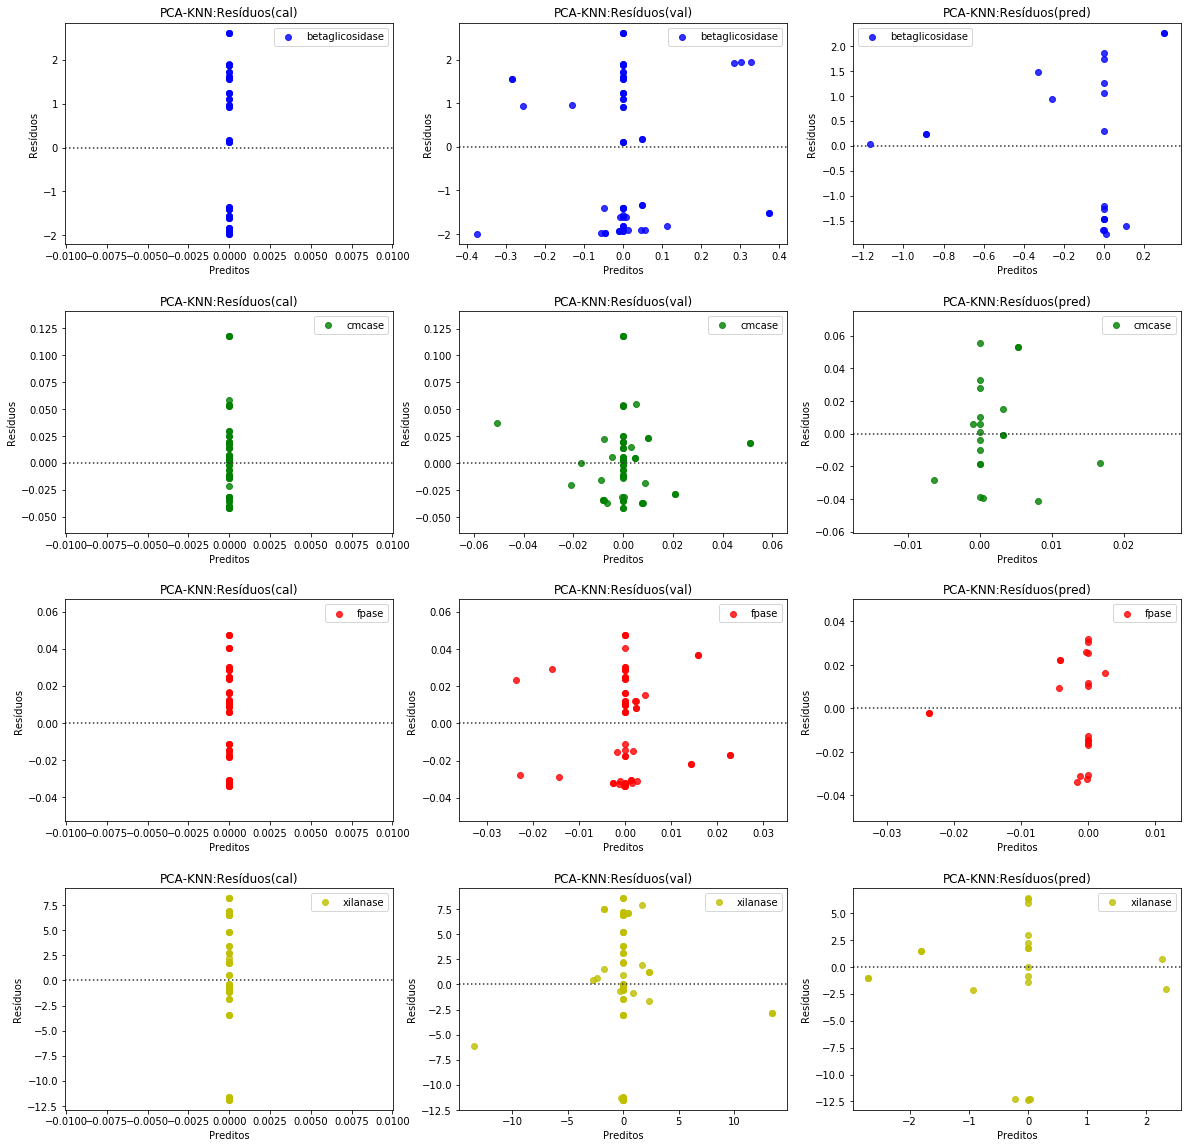

In [106]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

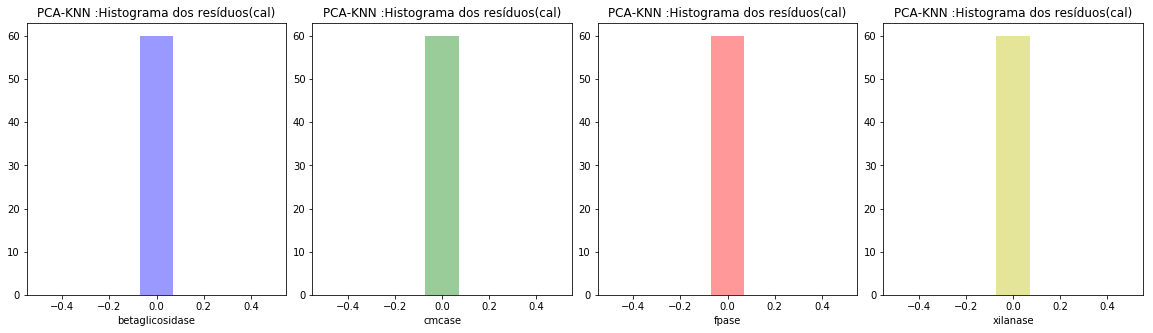

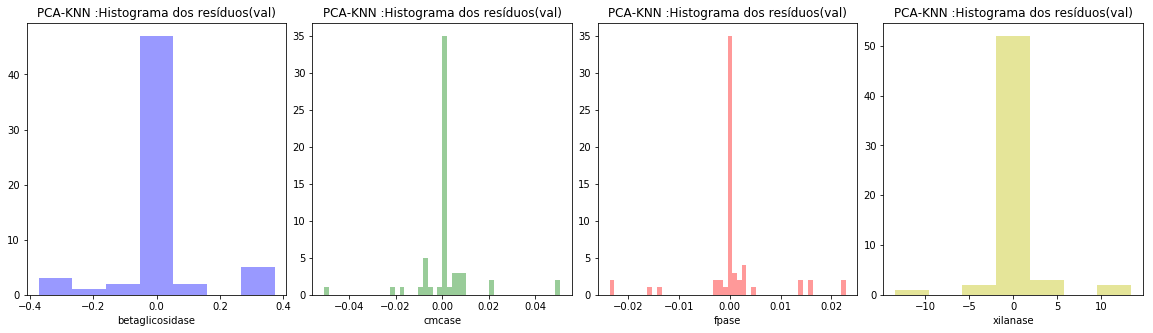

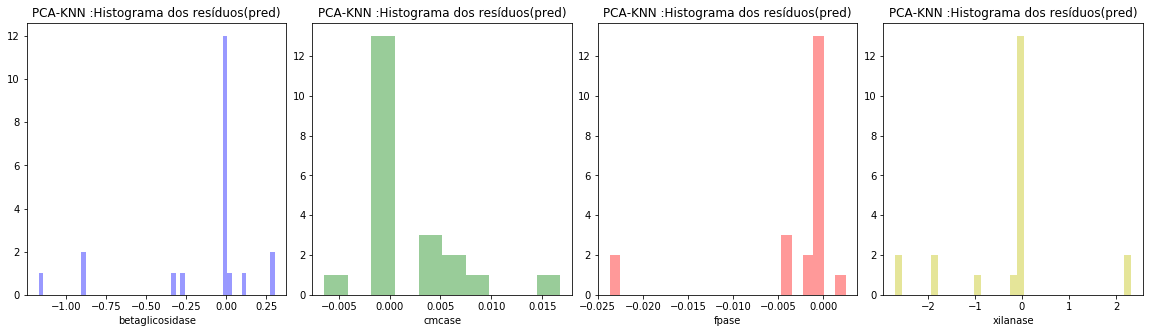

In [107]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

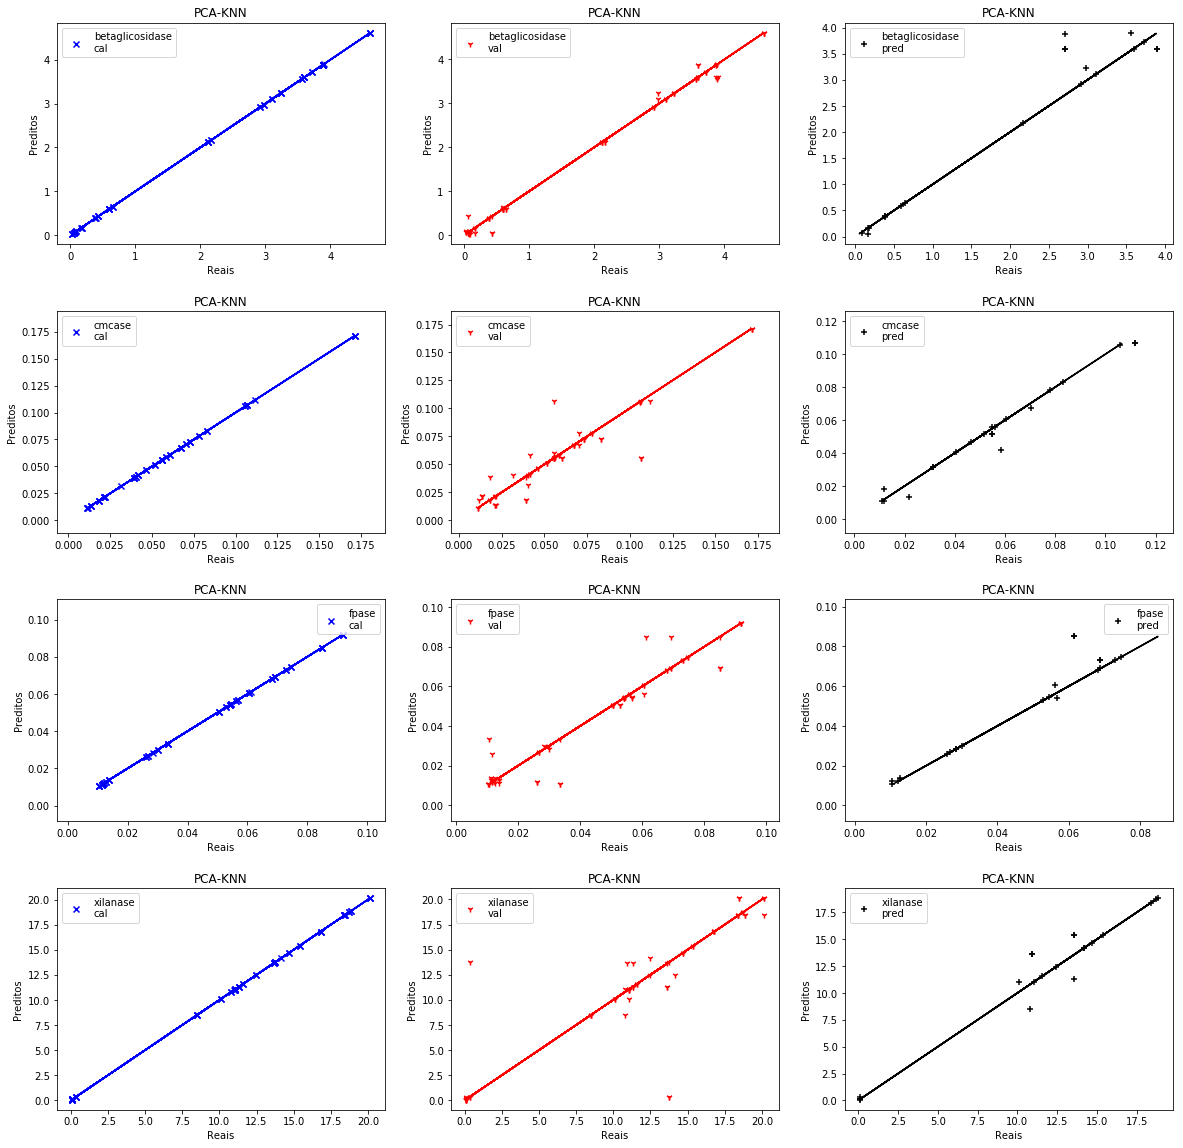

In [117]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

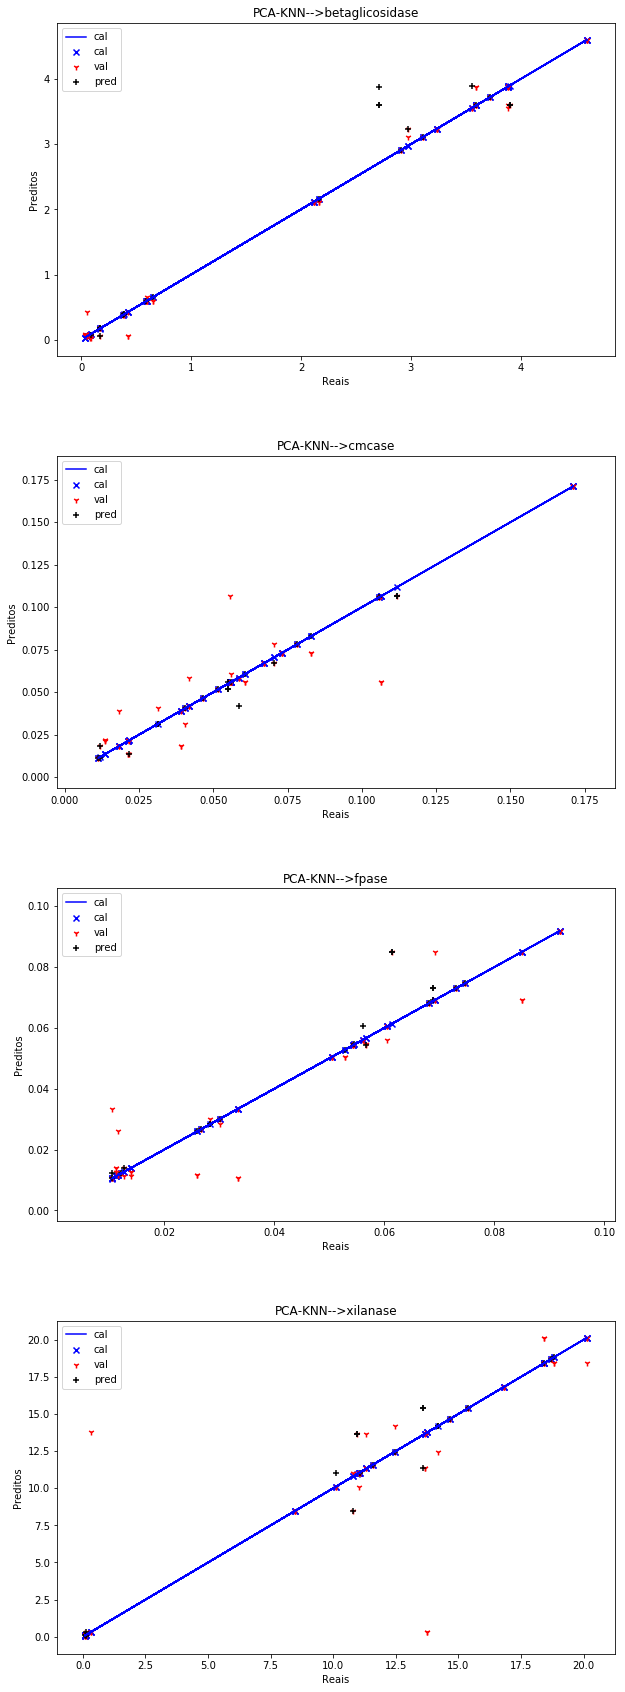

In [119]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### PCA->KNN: Gráficos: dados de treino

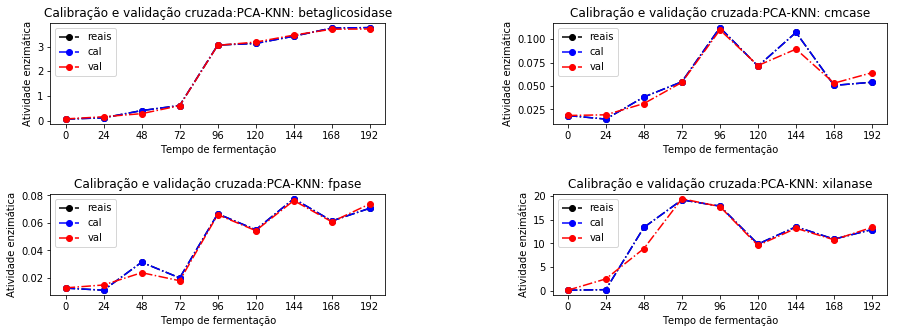

In [120]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### PCA->KNN:Gráficos de  teste

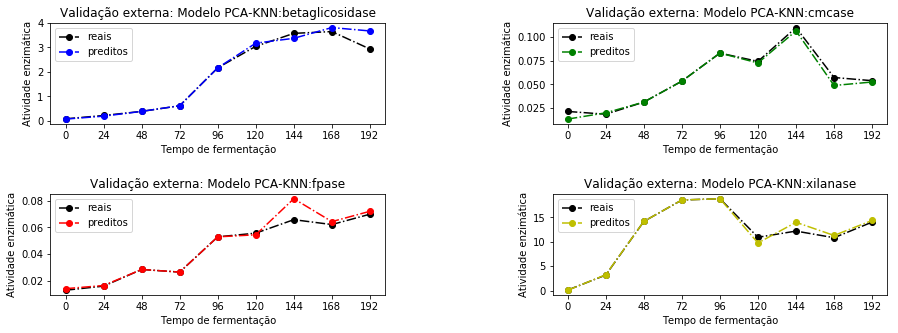

In [121]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

### PCA-knn: teste com base externa: EETA desnaturado

In [120]:
#@testeExterno
#rodando o pcaknn com os dados de treino 
modelo = 'PCA-KNN:'
preproc=1
nPC=3
k=1
gera=0
result = executaPCA_KNN(preproc,nPC,k, False, gera)
#print('Parâmetros do modelo:',m,'\n',result[0])

resultados=exibeResultados(result)
reg, treino_teste,y_c,y_cv,y_p = result

In [25]:
#buscando base de teste externa
de = dados_back.copy()
de=de[(de['eenz'] == 'eeta')&(de['experimento']=='biod1')&(de['inter']!= 1)&(de['inter']!= 2)&(de['inter']!= 3)&(de['inter']!= 4)]
#Separar somente as amostras que contenham todas as atividades enzimáticas
de = de.loc[(de['betaglicosidase'].notnull()) 
                         & (de['cmcase'].notnull()) 
                         & (de['fpase'].notnull())
                         &(de['xilanase'].notnull())]
de.shape


(21, 713)

In [134]:
de.head(5)

descricao    1100nm    1102nm    1104nm    1106nm    1108nm  \
791   bio_25janp0_1_desn  0.038744  0.038471  0.038295  0.038206  0.038193   
792   bio_25janp0_2_desn  0.038601  0.038637  0.038631  0.038613  0.038621   
793   bio_25janp0_3_desn  0.039642  0.039467  0.039371  0.039322  0.039300   
794  bio_25janp10_1_desn  0.053291  0.051491  0.050285  0.049398  0.048688   
795  bio_25janp10_2_desn  0.053027  0.051663  0.050706  0.049957  0.049301   

       1110nm    1112nm    1114nm    1116nm  ...  cmcase  fpase  xilanase  \
791  0.038237  0.038330  0.038481  0.038710  ...   0.035  0.051    24.094   
792  0.038688  0.038837  0.039073  0.039391  ...   0.035  0.051    24.094   
793  0.039299  0.039333  0.039428  0.039612  ...   0.035  0.051    24.094   
794  0.048107  0.047656  0.047341  0.047144  ...   0.026  0.005     0.256   
795  0.048693  0.048133  0.047644  0.047249  ...   0.026  0.005     0.256   

     proteinas  eenz  temp  dur  inter  proc  experimento  
791        NaN  eeta    70   33      0   des        biod1  
792        NaN  eeta    70   33      0   des        biod1  
793        NaN  eeta    70   33      0   des        biod1  
794        NaN  eeta    70   33     30   des        biod1  
795        NaN  eeta    70   33     30   des        biod1  

[5 rows x 713 columns]

In [26]:
#Definindo os dataFrames iniciais para começar o processamento
de_x = de.loc[:,var_abs_txt] #absorbâncias
de_y = de.loc[:,var_ae]#AE
de_inter=pd.DataFrame(de.loc[:,'inter'], columns=['inter'])
#df = dados.loc[:,var_abs_txt+var_ae]

In [136]:
de_x.shape,de_y.shape, de_inter.shape

((21, 244), (21, 4), (21, 1))

In [27]:
#executa pré-processamento equivalente ao do modelo de treinamento
x = executaPreprocSimples(1,de_x)
pca = PCA(n_components=3)
x = pca.fit_transform(x)[:,:3]
preditos=reg.predict(x)

In [43]:
len(preditos[:,1])

21

In [47]:
len(de_y.loc[:,'cmcase'])

21

In [74]:

var_ae=['betaglicosidase','cmcase','fpase','xilanase']
r2 = {}
rmse={}
for e,ie in zip(var_ae,[0,1,2,3]):
    reais = de_y.loc[:,e]
    pred = preditos[:,ie]
    r2[e] = getr2(reais, pred)
    rmse[e] = getrmse(reais, pred)
res=pd.DataFrame(r2,columns=var_ae,index=['r2'])
res.loc['rmse']=rmse

In [75]:
res

betaglicosidase     cmcase     fpase   xilanase
r2          -7.675874 -17.693246 -5.125102  -1.374266
rmse         1.966121   0.063663  0.052679  13.800239

In [77]:
reais,pred

(791    24.094000
 792    24.094000
 793    24.094000
 794     0.256000
 795     0.256000
 796     0.256000
 809    17.361999
 810    17.361999
 811    17.361999
 812     3.511000
 813     3.511000
 814     3.511000
 815     1.502000
 816     1.502000
 817     1.502000
 818     0.966000
 819     0.966000
 820     0.966000
 821     0.864000
 822     0.864000
 823     0.864000
 Name: xilanase, dtype: float64,
 array([18.70946384,  0.09959101,  0.07259513, 16.81154036, 11.05257379,
        16.81154036, 15.39734742,  0.09243945,  0.09243945,  0.09243945,
        15.39734742,  0.09243945, 11.57360972, 11.32558943,  8.47724747,
        11.32558943, 11.32558943,  8.47724747, 18.41271409, 18.41271409,
        16.81154036]))

In [68]:
pd.DataFrame(rmse,columns=var_ae,index=[1])

betaglicosidase    cmcase     fpase   xilanase
1         1.966121  0.063663  0.052679  13.800239

In [57]:

var_ae=['betaglicosidase','cmcase','fpase','xilanase']
res = {}
for e,ie in zip(var_ae,[0,1,2,3]):
    reais = de_y.loc[:,e]
    pred = preditos[:,ie]
    r = pd.Series(calMetrics(reais, pred))
    if ie == 0:
        res = pd.DataFrame(r, columns=[e])
    else:
        res[e] = r
    res[ie] = res


KeyError: 0

In [33]:
#@modelagemPred teste externo para predição com bases de dados diversas
#exibe resultados predição
def retornaPred(y,yp):
    #yp contem os valores estimados da predição
    var_ae=['betaglicosidase','cmcase','fpase','xilanase']
    res = {}
    for e,ie in zip(var_ae,[0,1,2,3]):
        reais = y.loc[:,e]
        pred = yp[:,ie]
        r = pd.Series(calMetrics(reais, pred))
        if ie == 0:
            res = pd.DataFrame(r, index=r.index, columns=[e])
        else:
            res[e] = r
        res[ie] = res
    return res

In [56]:

resultado = retornaPred([de_y], [preditos])

KeyError: 0

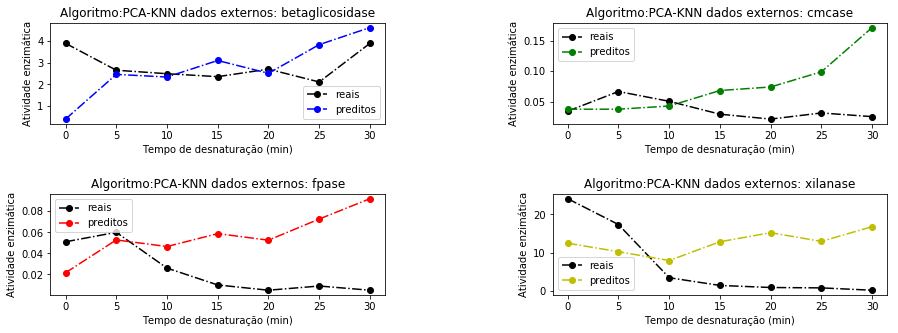

In [138]:
#para exibir o gráfico
#para todas as atividades
#cria um data frame com os valores reais e preditos para os dados de teste
df_pred = {}
for valor in var_ae:
    df_pred[valor] = []
i=0
for valor in var_ae:
    df =pd.DataFrame(columns=['reais','preditos'], index= de_y.index)
    df['reais'] = de_y[valor]
    df['preditos'] = pd.DataFrame(preditos[:,i],index= de_y.index)
    i +=1
    df_pred[valor] = df.copy()
    
df_pred_inter = {}
for valor in var_ae:
    df_pred_inter[valor] = []
for valor in var_ae:
    df_pred_inter[valor] = df_pred[valor].copy()
    df_pred_inter[valor]['inter'] = de_inter.loc[:,'inter']

#ordena valores pelo intervalo
df_ord_teste = {}
for valor in var_ae:
    df_ord_teste[valor] = []
for valor in var_ae:
    df_ord_teste[valor] = df_pred_inter[valor].sort_values(['inter'])

#calculando a média para cada ponto
df_teste_media = {}
for valor in var_ae:
    df_teste_media[valor] = []
for valor in var_ae:
    df_teste_media[valor] = df_ord_teste[valor].groupby('inter').mean()
x = list(df_teste_media['xilanase'].index)
var = ['reais', 'preditos']
tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
j = 0    
fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace = 0.7, wspace=0.5)
for valor in var_ae:
    ax = fig.add_subplot(2,2,j+1)
    ax.plot(x,df_teste_media[valor][var[0]], 'ko-.', label=var[0])
    ax.plot(x,df_teste_media[valor][var[1]], tipoAE[j], label=var[1])
    j +=1
    ax.legend(loc=2)
    ax.set_title('Algoritmo:'+modelo+' dados externos'+': '+valor)
    ax.set_xlabel('Tempo de desnaturação (min)')
    ax.set_ylabel('Atividade enzimática') 
    ax.set_xticks(x)
    plt.legend(loc='best')

## KNN 

In [144]:
#knn
#função completa para execução do KNN:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3..9)
from sklearn.neighbors import KNeighborsRegressor
def executaKNN(preproc,k,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,IC)
    
    
    # Cria um objeto de regressão linear
    reg = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=k))
    #reg = KNeighborsRegressor(n_neighbors=n)


    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result
    
    

### KNN: testes

In [145]:
#knn teste simples
modelo = 'KNN:'
preproc=1
k=2
result = executaKNN(preproc,k)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform'),
           n_jobs=None)


In [146]:
resultados['cal']

betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0047   0.0000   0.0001    0.0895
MSE            0.0024   0.0000   0.0000    0.9963
R2             0.9991   0.9871   0.9774    0.9776
RER           92.2512  36.5837  20.7102   20.0136
RMSE           0.0494   0.0043   0.0039    0.9982
RPD           32.6062   8.8090   6.6477    6.6785
RPIQ          65.4306  10.1224  12.5978    8.9741
SEP            0.0496   0.0044   0.0039    1.0025

In [147]:
resultados['val']

betaglicosidase   cmcase    fpase  xilanase
BIAS          -0.0077   0.0001   0.0006    0.4719
MSE            0.0884   0.0002   0.0000    4.5714
R2             0.9659   0.8450   0.9332    0.8971
RER           15.2592  10.5496  12.0868    9.5409
RMSE           0.2973   0.0150   0.0067    2.1381
RPD            5.4159   2.5402   3.8680    3.1178
RPIQ          10.8681   2.9189   7.3302    4.1895
SEP            0.2997   0.0152   0.0067    2.1030

In [148]:
resultados['pred']

betaglicosidase  cmcase    fpase  xilanase
BIAS           0.1428 -0.0012   0.0002    0.1324
MSE            0.1908  0.0002   0.0000    1.9708
R2             0.9166  0.7220   0.9312    0.9409
RER            9.1463  6.9485  12.0272   13.9914
RMSE           0.4368  0.0141   0.0061    1.4039
RPD            3.4630  1.8967   3.8130    4.1145
RPIQ           7.1752  2.0266   6.8406    2.7646
SEP            0.4230  0.0144   0.0062    1.4321

In [149]:
#knn teste completo
#Executa o modelo KNN variando o tipo de processamento e o número de vizinhos
for pre in range(0,12): 
    for viz in range(1,7):
        result = executaKNN(pre,viz)
        print('Pŕe-proc:',pre, '-> vizinhos:', viz,'\n')
        resultados=exibeResultados(result)
        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')

Pŕe-proc: 0 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0801 -0.0021 -0.0007   -0.0832
MSE            0.2587  0.0008  0.0001    2.3003
R2             0.9002  0.4418  0.8391    0.9482
RER            9.0288  5.5730  7.7814   13.1381
RMSE           0.5086  0.0286  0.0104    1.5167
RPD            3.1656  1.3384  2.4929    4.3953
RPIQ           6.3524  1.5380  4.7243    5.9060
SEP            0.5065  0.0287  0.0105    1.5272 
----------------------------------------------------

Pŕe-proc: 1 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0094   0.0000   0.0002    0.1790
MSE            0.0098   0.0001   0.0001    3.9853
R2             0.9962   0.9485   0.9095    0.9103
RER           46.1256  18.2918  10.3551   10.0068
RMSE           0.0988   0.0087   0.0078    1.9963
RPD           16.3031   4.4045   3.3238    3.3393
RPIQ          32.7153   5.0612   6.2989    4.4870
SEP            0.0991   0.0088   0.0079    2.0051 
----------------------------------

Pŕe-proc: 2 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0030  0.0075  0.0024    0.6784
MSE            0.3246  0.0012  0.0001   15.0302
R2             0.8748  0.2100  0.8087    0.6618
RER            7.9593  4.7897  7.2786    5.2124
RMSE           0.5697  0.0340  0.0113    3.8769
RPD            2.8259  1.1251  2.2865    1.7195
RPIQ           5.6707  1.2928  4.3331    2.3105
SEP            0.5745  0.0334  0.0112    3.8493 
----------------------------------------------------

Pŕe-proc: 3 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0299  0.0046  0.0012    0.4606
MSE            0.5111  0.0014  0.0002   10.8308
R2             0.8028  0.0399  0.7396    0.7563
RER            6.3487  4.2700  6.1285    6.1057
RMSE           0.7149  0.0374  0.0132    3.2910
RPD            2.2521  1.0206  1.9596    2.0256
RPIQ           4.5193  1.1727  3.7137    2.7218
SEP            0.7203  0.0375  0.0133    3.2861 
----------------------------------------------------

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0891  0.0025  0.0005    0.4774
MSE            0.3817  0.0013  0.0001    6.0952
R2             0.8528  0.1398  0.7882    0.8628
RER            7.4177  4.4892  6.7720    8.2140
RMSE           0.6178  0.0354  0.0119    2.4688
RPD            2.6061  1.0782  2.1726    2.7001
RPIQ           5.2297  1.2390  4.1173    3.6282
SEP            0.6165  0.0357  0.0120    2.4427 
-----------------------------------------------------
pred
      betaglicosidase 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0907  0.0041  0.0008    0.5901
MSE            0.1669  0.0009  0.0001    9.7508
R2             0.9356  0.4066  0.8887    0.7806
RER           11.3830  5.4446  9.3783    6.4886
RMSE           0.4086  0.0294  0.0087    3.1226
RPD            3.9407  1.2981  2.9973    2.1348
RPIQ           7.9078  1.4916  5.6800    2.8686
SEP            0.4017  0.0294  0.0087    3.0922 
-----------------------------------------------------
pred
      betaglicosidase 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0005  0.0076  0.0019    0.6161
MSE            0.4496  0.0012  0.0002   27.4000
R2             0.8266  0.1561  0.7239    0.3834
RER            6.7632  4.6307  5.9817    3.8276
RMSE           0.6705  0.0351  0.0136    5.2345
RPD            2.4013  1.0886  1.9031    1.2735
RPIQ           4.8186  1.2509  3.6066    1.7113
SEP            0.6761  0.0346  0.0136    5.2420 
-----------------------------------------------------
pred
      betaglicosidase 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0398  0.0090  0.0020    0.1858
MSE            0.4520  0.0013  0.0002   24.8868
R2             0.8256  0.1272  0.7415    0.4400
RER            6.7567  4.5921  6.1954    3.9911
RMSE           0.6723  0.0357  0.0132    4.9887
RPD            2.3948  1.0704  1.9670    1.3363
RPIQ           4.8055  1.2300  3.7275    1.7956
SEP            0.6768  0.0349  0.0132    5.0273 
-----------------------------------------------------
pred
      betaglicosidase 

Pŕe-proc: 8 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase   cmcase    fpase  xilanase
BIAS          -0.0050   0.0003  -0.0006   -0.1393
MSE            0.0533   0.0001   0.0000    0.9427
R2             0.9794   0.9175   0.9609    0.9788
RER           19.6504  14.4611  15.8526   20.7061
RMSE           0.2308   0.0110   0.0051    0.9709
RPD            6.9751   3.4808   5.0571    6.8658
RPIQ          13.9970   3.9998   9.5835    9.2257
SEP            0.2327   0.0111   0.0051    0.9690 
----------------------------------

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase   cmcase   fpase  xilanase
BIAS          -0.0017  -0.0019 -0.0005   -0.2244
MSE            0.1344   0.0002  0.0001    3.3446
R2             0.9481   0.8636  0.8930    0.9247
RER           12.3677  11.3457  9.5337   10.9621
RMSE           0.3667   0.0141  0.0085    1.8288
RPD            4.3911   2.7073  3.0573    3.6451
RPIQ           8.8116   3.1109  5.7939    4.8980
SEP            0.3697   0.0141  0.0085    1.8303 
-----------------------------------------------------
pred
      betagli

SEP            0.6055  0.0231  0.0115    2.2806 
-----------------------------------------------------
Pŕe-proc: 10 -> vizinhos: 2 

cal
      betaglicosidase  cmcase    fpase  xilanase
BIAS          -0.0432 -0.0003  -0.0006   -0.0177
MSE            0.0638  0.0003   0.0000    0.6074
R2             0.9754  0.8249   0.9621    0.9863
RER           18.2212  9.9270  16.0924   25.5359
RMSE           0.2526  0.0160   0.0051    0.7794
RPD            6.3741  2.3900   5.1361    8.5535
RPIQ          12.7908  2.7463   9.7333   11.4936
SEP            0.2510  0.0161   0.0051    0.7857 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0182  0.0014  0.0008    0.2169
MSE            0.2230  0.0007  0.0001    4.8418
R2             0.9140  0.5182  0.8776    0.8910
RER            9.6087  5.9921  8.9313    9.0863
RMSE           0.4723  0.0265  0.0091    2.2004
RPD            3.4090  1.4407  2.8581    3.0295
RPIQ           6.8408  1.65

cal
      betaglicosidase  cmcase    fpase  xilanase
BIAS          -0.0432 -0.0003  -0.0006   -0.0177
MSE            0.0638  0.0003   0.0000    0.6074
R2             0.9754  0.8249   0.9621    0.9863
RER           18.2212  9.9270  16.0924   25.5359
RMSE           0.2526  0.0160   0.0051    0.7794
RPD            6.3741  2.3900   5.1361    8.5535
RPIQ          12.7908  2.7463   9.7333   11.4936
SEP            0.2510  0.0161   0.0051    0.7857 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0182  0.0014  0.0008    0.2169
MSE            0.2230  0.0007  0.0001    4.8418
R2             0.9140  0.5182  0.8776    0.8910
RER            9.6087  5.9921  8.9313    9.0863
RMSE           0.4723  0.0265  0.0091    2.2004
RPD            3.4090  1.4407  2.8581    3.0295
RPIQ           6.8408  1.6555  5.4163    4.0708
SEP            0.4759  0.0267  0.0091    2.2082 
-----------------------------------------------------
pred
    

In [150]:
#Executa o modelo KNN variando os pre-proc mais efetivos
for pre in [1,8,9]: 
    for viz in range(1,4):
        result = executaKNN(pre,viz,0)
        print('Pŕe-proc:',pre, '-> vizinhos:', viz,'\n')
        resultados=exibeResultados(result)
        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')

Pŕe-proc: 1 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0094   0.0000   0.0002    0.1790
MSE            0.0098   0.0001   0.0001    3.9853
R2             0.9962   0.9485   0.9095    0.9103
RER           46.1256  18.2918  10.3551   10.0068
RMSE           0.0988   0.0087   0.0078    1.9963
RPD           16.3031   4.4045   3.3238    3.3393
RPIQ          32.7153   5.0612   6.2989    4.4870
SEP            0.0991   0.0088   0.0079    2.0051 
----------------------------------

Pŕe-proc: 9 -> vizinhos: 1 

cal
      betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0 
-----------------------------------------------------
val
      betaglicosidase   cmcase   fpase  xilanase
BIAS          -0.0017  -0.0019 -0.0005   -0.2244
MSE            0.1344   0.0002  0.0001    3.3446
R2             0.9481   0.8636  0.8930    0.9247
RER           12.3677  11.3457  9.5337   10.9621
RMSE           0.3667   0.0141  0.0085    1.8288
RPD            4.3911   2.7073  3.0573    3.6451
RPIQ           8.8116   3.1109  5.7939    4.8980
SEP            0.3697   0.0141  0.0085    1.8303 
-------------------------------------------

In [151]:
#teste 2 escolhendo o modelo otimizado
#knn otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaKNN(8,1,i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.9995, 0.989, 0.9971, 0.9947] 
semente: b c f x [3, 97, 97, 58]


In [152]:
#knn teste otimizado
#@knnotimizado
preproc=8
k=1
gera=97
result = executaKNN(preproc,k, gera)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: KNN: 
 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='uniform'),
           n_jobs=None)


In [153]:
resultados['cal']

betaglicosidase  cmcase  fpase  xilanase
BIAS              0.0     0.0    0.0       0.0
MSE               0.0     0.0    0.0       0.0
R2                1.0     1.0    1.0       1.0
RER               inf     inf    inf       inf
RMSE              0.0     0.0    0.0       0.0
RPD               inf     inf    inf       inf
RPIQ              inf     inf    inf       inf
SEP               0.0     0.0    0.0       0.0

In [154]:
resultados['val']

betaglicosidase   cmcase    fpase  xilanase
BIAS          -0.0111  -0.0007   0.0002    0.1509
MSE            0.0267   0.0001   0.0000    3.1988
R2             0.9893   0.9132   0.9499    0.9221
RER           27.8374  15.8531  14.7244   11.1643
RMSE           0.1633   0.0100   0.0055    1.7885
RPD            9.6868   3.3938   4.4655    3.5822
RPIQ          19.6510   3.1864   6.7482    3.3873
SEP            0.1643   0.0101   0.0055    1.7972

In [155]:
resultados['pred']

betaglicosidase   cmcase    fpase  xilanase
BIAS          -0.0361   0.0000   0.0002    0.3710
MSE            0.0078   0.0000   0.0000    0.8402
R2             0.9970   0.9890   0.9971    0.9800
RER           54.9529  37.4766  54.3996   23.3597
RMSE           0.0885   0.0042   0.0015    0.9167
RPD           18.2265   9.5431  18.5294    7.0753
RPIQ          33.2335  13.5846  37.2916   14.5312
SEP            0.0828   0.0043   0.0015    0.8589

In [156]:
#variáveis para geração de gráficos e testes
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [157]:
#knn reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0874  0.0217  0.0127    0.1071                 0.0874   
1            0.3828  0.0405  0.0301   12.4461                 0.3828   
2            0.0308  0.0213  0.0113    0.0996                 0.0308   
3            3.5610  0.0586  0.0561   10.0978                 3.5610   
4            2.1150  0.0730  0.0505   18.4127                 2.1150   
5            3.5974  0.0516  0.0731   15.3973                 3.5974   
6            0.0874  0.0217  0.0127    0.1071                 0.0874   
7            3.8803  0.0557  0.0691   11.3256                 3.8803   
8            0.0759  0.0136  0.0139    0.0726                 0.0759   
9            0.3900  0.0315  0.0283   14.1777                 0.3900   
10           3.8994  0.1118  0.0613   10.9512                 3.8994   
11           0.4280  0.0390  0.0334   13.7624                 0.4280   
12           0.5905  0.0465  0.0267   18.7095                 0.5905   
13           0.3900  0.0315  0.0283   14.1777                 0.3900   
14           3.2342  0.0672  0.0543    8.4772                 3.2342   
15           0.5905  0.0465  0.0267   18.7095                 0.5905   
16           0.1724  0.0112  0.0121    0.0924                 0.1724   
17           0.6010  0.0559  0.0116   20.1368                 0.6010   
18           0.6010  0.0559  0.0116   20.1368                 0.6010   
19           0.0554  0.0181  0.0106    0.3275                 0.0554   
20           0.1724  0.0112  0.0121    0.0924                 0.1724   
21           2.9774  0.0704  0.0567   10.8002                 2.9774   
22           2.1643  0.0830  0.0529   18.8324                 2.1643   
23           2.9123  0.1058  0.0747   14.6813                 2.9123   
24           4.6037  0.1713  0.0919   16.8115                 4.6037   
25           3.8876  0.0418  0.0605   11.0267                 3.8876   
26           3.5967  0.1065  0.0850   13.6476                 3.5967   
27           0.3828  0.0405  0.0301   12.4461                 0.3828   
28           3.5610  0.0586  0.0561   10.0978                 3.5610   
29           0.1671  0.0117  0.0104    0.1117                 0.1671   
30           3.1068  0.0781  0.0545   11.0526                 3.1068   
31           2.1643  0.0830  0.0529   18.8324                 2.1643   
32           4.6037  0.1713  0.0919   16.8115                 4.6037   
33           3.5610  0.0586  0.0561   10.0978                 3.5610   
34           2.1150  0.0730  0.0505   18.4127                 2.1150   
35           3.5967  0.1065  0.0850   13.6476                 3.5967   
36           0.4280  0.0390  0.0334   13.7624                 0.4280   
37           3.8994  0.1118  0.0613   10.9512                 3.8994   
38           2.1643  0.0830  0.0529   18.8324                 2.1643   
39           0.0308  0.0213  0.0113    0.0996                 0.0308   
40           3.8876  0.0418  0.0605   11.0267                 3.8876   
41           2.1150  0.0730  0.0505   18.4127                 2.1150   
42           0.4280  0.0390  0.0334   13.7624                 0.4280   
43           2.9123  0.1058  0.0747   14.6813                 2.9123   
44           0.1724  0.0112  0.0121    0.0924                 0.1724   
45           2.7110  0.0548  0.0688   13.5829                 2.7110   
46           0.1671  0.0117  0.0104    0.1117                 0.1671   
47           3.5974  0.0516  0.0731   15.3973                 3.5974   
48           3.7243  0.0561  0.0681   11.5736                 3.7243   
49           3.8803  0.0557  0.0691   11.3256                 3.8803   
50           0.6491  0.0605  0.0260   18.4274                 0.6491   
51           0.3828  0.0405  0.0301   12.4461                 0.3828   
52           0.0308  0.0213  0.0113    0.0996                 0.0308   
53           3.7243  0.0561  0.0681   11.5736                 3.7243   
54           3.5974  0.0516  0.0731   15.397

In [158]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)

VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0874  0.0217  0.0127    0.1071                 0.0874   
1            0.3828  0.0405  0.0301   12.4461                 0.0554   
2            0.0308  0.0213  0.0113    0.0996                 0.0308   
3            3.5610  0.0586  0.0561   10.0978                 3.8876   
4            2.1150  0.0730  0.0505   18.4127                 2.1643   
5            3.5974  0.0516  0.0731   15.3973                 3.5974   
6            0.0874  0.0217  0.0127    0.1071                 0.0308   
7            3.8803  0.0557  0.0691   11.3256                 3.8803   
8            0.0759  0.0136  0.0139    0.0726                 0.0308   
9            0.3900  0.0315  0.0283   14.1777                 0.3828   
10           3.8994  0.1118  0.0613   10.9512                 3.8994   
11           0.4280  0.0390  0.0334   13.7624                 0.4280   
12           0.5905  0.0465  0.0267   18.7095                 0.6491   
13           0.3900  0.0315  0.0283   14.1777                 0.3828   
14           3.2342  0.0672  0.0543    8.4772                 3.2342   
15           0.5905  0.0465  0.0267   18.7095                 0.6010   
16           0.1724  0.0112  0.0121    0.0924                 0.1724   
17           0.6010  0.0559  0.0116   20.1368                 0.5905   
18           0.6010  0.0559  0.0116   20.1368                 0.6491   
19           0.0554  0.0181  0.0106    0.3275                 0.1671   
20           0.1724  0.0112  0.0121    0.0924                 0.1671   
21           2.9774  0.0704  0.0567   10.8002                 3.2342   
22           2.1643  0.0830  0.0529   18.8324                 2.1643   
23           2.9123  0.1058  0.0747   14.6813                 2.9123   
24           4.6037  0.1713  0.0919   16.8115                 4.6037   
25           3.8876  0.0418  0.0605   11.0267                 3.5610   
26           3.5967  0.1065  0.0850   13.6476                 3.5967   
27           0.3828  0.0405  0.0301   12.4461                 0.3900   
28           3.5610  0.0586  0.0561   10.0978                 3.5610   
29           0.1671  0.0117  0.0104    0.1117                 0.0554   
30           3.1068  0.0781  0.0545   11.0526                 2.9774   
31           2.1643  0.0830  0.0529   18.8324                 2.1643   
32           4.6037  0.1713  0.0919   16.8115                 4.6037   
33           3.5610  0.0586  0.0561   10.0978                 3.8876   
34           2.1150  0.0730  0.0505   18.4127                 2.1150   
35           3.5967  0.1065  0.0850   13.6476                 3.5967   
36           0.4280  0.0390  0.0334   13.7624                 0.4280   
37           3.8994  0.1118  0.0613   10.9512                 3.8994   
38           2.1643  0.0830  0.0529   18.8324                 2.1643   
39           0.0308  0.0213  0.0113    0.0996                 0.0308   
40           3.8876  0.0418  0.0605   11.0267                 3.5610   
41           2.1150  0.0730  0.0505   18.4127                 2.1643   
42           0.4280  0.0390  0.0334   13.7624                 0.4280   
43           2.9123  0.1058  0.0747   14.6813                 2.9123   
44           0.1724  0.0112  0.0121    0.0924                 0.1671   
45           2.7110  0.0548  0.0688   13.5829                 3.5974   
46           0.1671  0.0117  0.0104    0.1117                 0.0554   
47           3.5974  0.0516  0.0731   15.3973                 3.5974   
48           3.7243  0.0561  0.0681   11.5736                 3.5967   
49           3.8803  0.0557  0.0691   11.3256                 3.8803   
50           0.6491  0.0605  0.0260   18.4274                 0.6010   
51           0.3828  0.0405  0.0301   12.4461                 0.3900   
52           0.0308  0.0213  0.0113    0.0996                 0.0759   
53           3.7243  0.0561  0.0681   11.5736                 3.8876   
54           3.5974  0.0516  0.0731   15.397

In [159]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.3900  0.0315  0.0283   14.1777                 0.4280   
1            3.8803  0.0557  0.0691   11.3256                 3.8803   
2            0.6491  0.0605  0.0260   18.4274                 0.6491   
3            3.5967  0.1065  0.0850   13.6476                 3.5967   
4            3.8994  0.1118  0.0613   10.9512                 3.8994   
5            2.7110  0.0548  0.0688   13.5829                 2.7110   
6            4.6037  0.1713  0.0919   16.8115                 4.6037   
7            2.9123  0.1058  0.0747   14.6813                 2.9123   
8            3.8876  0.0418  0.0605   11.0267                 3.8876   
9            0.0554  0.0181  0.0106    0.3275                 0.0554   
10           0.1671  0.0117  0.0104    0.1117                 0.1671   
11           2.7110  0.0548  0.0688   13.5829                 2.7110   
12           0.0874  0.0217  0.0127    0.1071                 0.0874   
13           2.9774  0.0704  0.0567   10.8002                 3.2342   
14           3.1068  0.0781  0.0545   11.0526                 3.2342   
15           0.0759  0.0136  0.0139    0.0726                 0.0308   
16           3.1068  0.0781  0.0545   11.0526                 3.1068   
17           2.9774  0.0704  0.0567   10.8002                 3.2342   
18           0.0759  0.0136  0.0139    0.0726                 0.0874   
19           0.6010  0.0559  0.0116   20.1368                 0.6010   
20           0.0554  0.0181  0.0106    0.3275                 0.1671   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0390       0.0334         13.7624  
1         0.0557       0.0691         11.3256  
2         0.0605       0.0260         18.4274  
3         0.1065       0.0850         13.6476  
4         0.1118       0.0613         10.9512  
5         0.0548       0.0688         13.5829  
6         0.1713       0.0919         16.8115  
7         0.1058       0.0747         14.6813  
8         0.0418       0.0605         11.0267  
9         0.0181       0.0106          0.3275  
10        0.0117       0.0104          0.1117  
11        0.0548       0.0688         13.5829  
12        0.0217       0.0127          0.1071  
13        0.0672       0.0543          8.4772  
14        0.0672       0.0543          8.4772  
15        0.0213       0.0113          0.0996  
16        0.0781       0.0545         11.0526  
17        0.0672       0.0543          8.4772  
18        0.0217       0.0127          0.1071  
19        0.0559       0.0116         20.1368  
20        0.0117       0.0104          0.1117

### KNN: Gráficos dos resíduos

In [162]:
#knnGraf

In [160]:
#título para os gráficos
modelo = 'KNN'

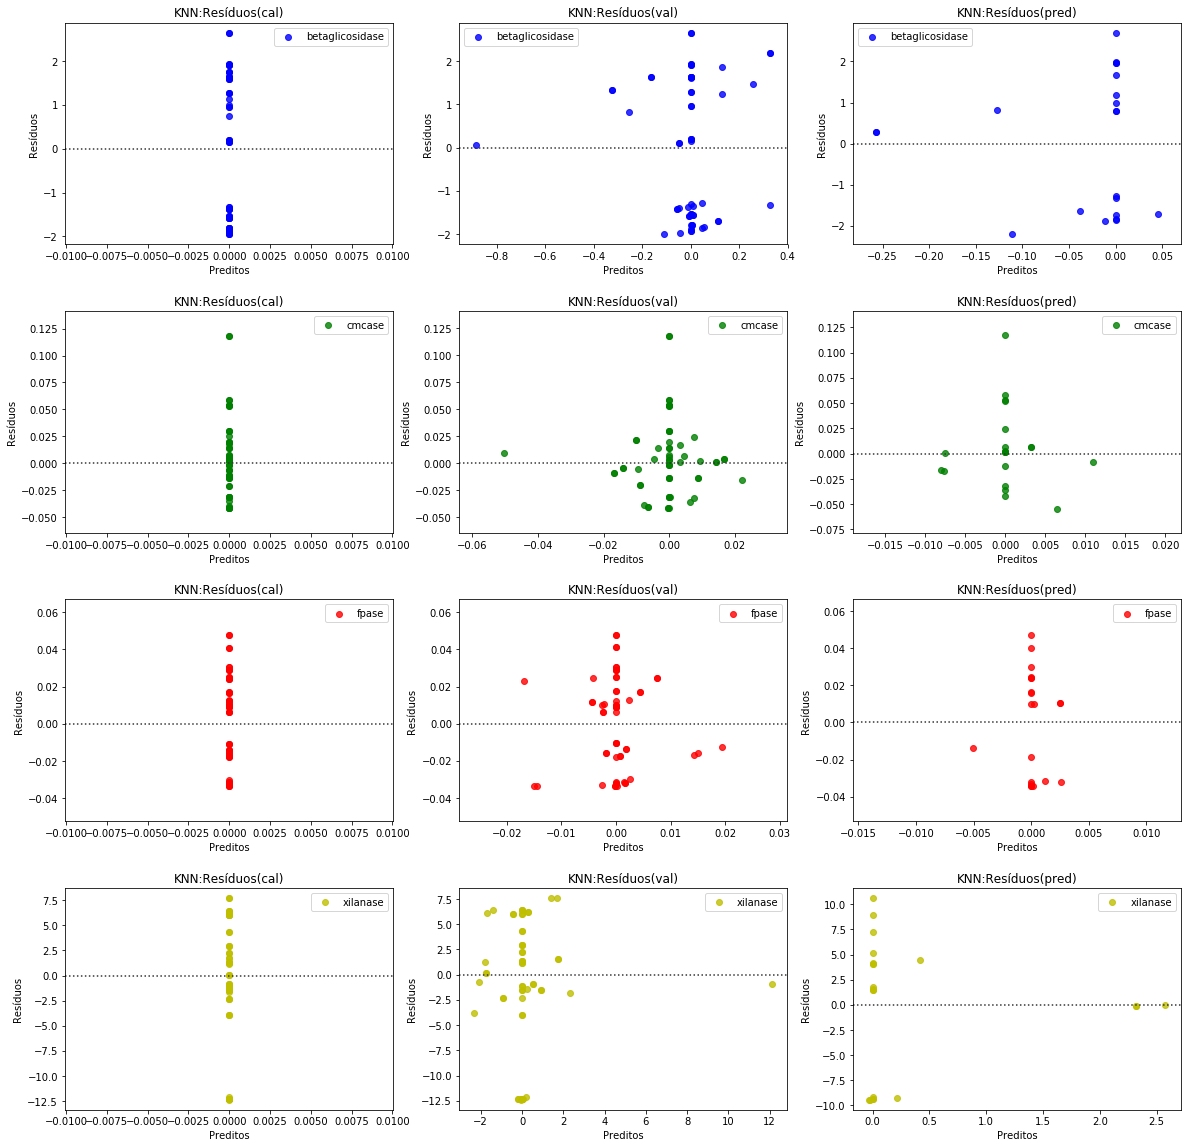

In [161]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

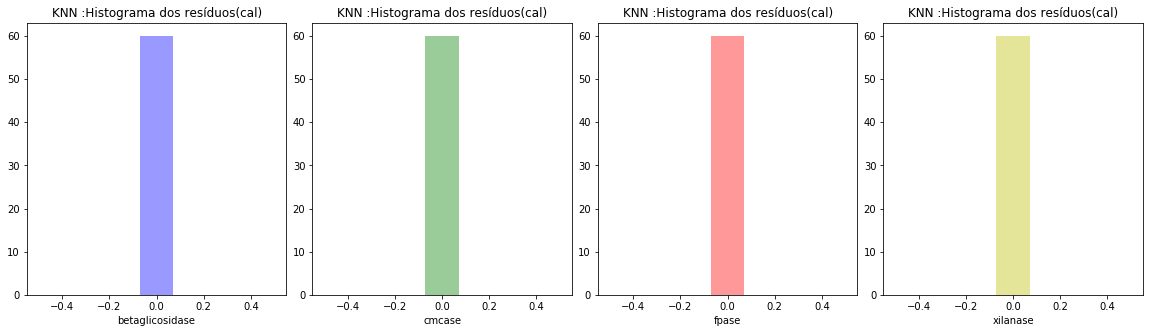

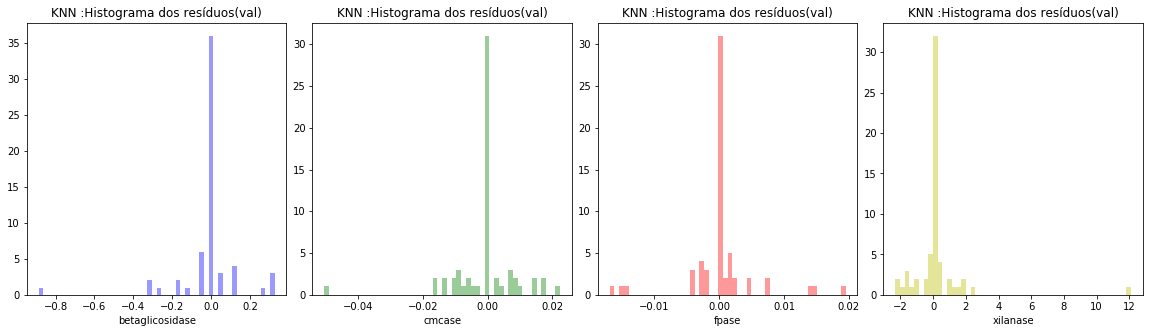

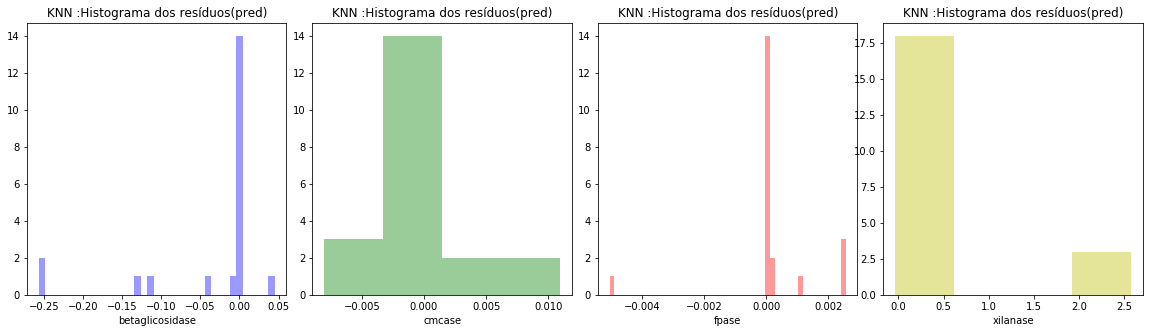

In [162]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

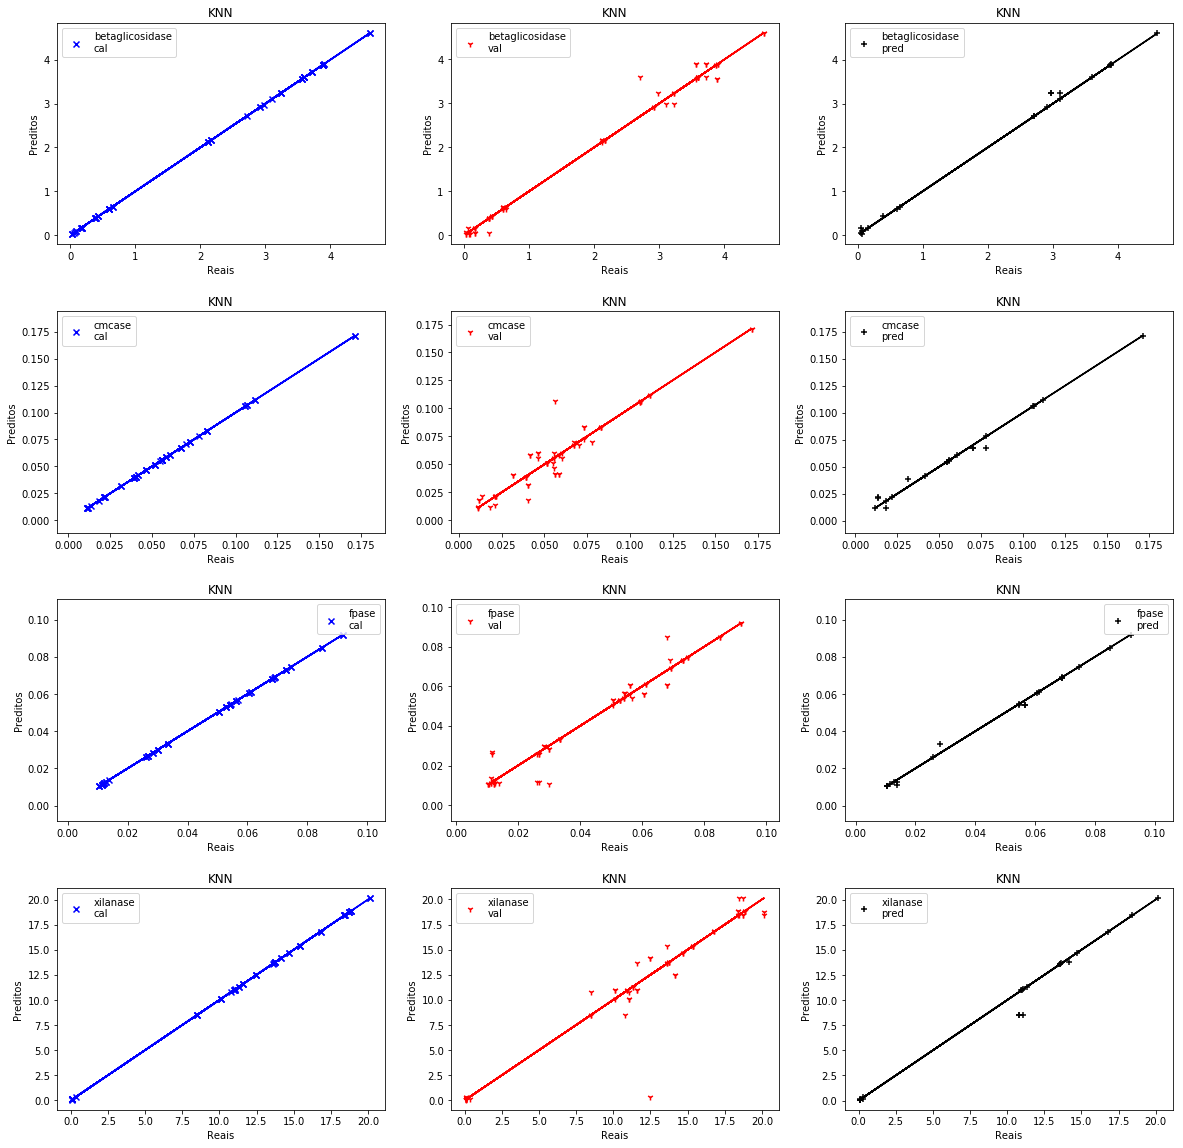

In [163]:
#grafico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

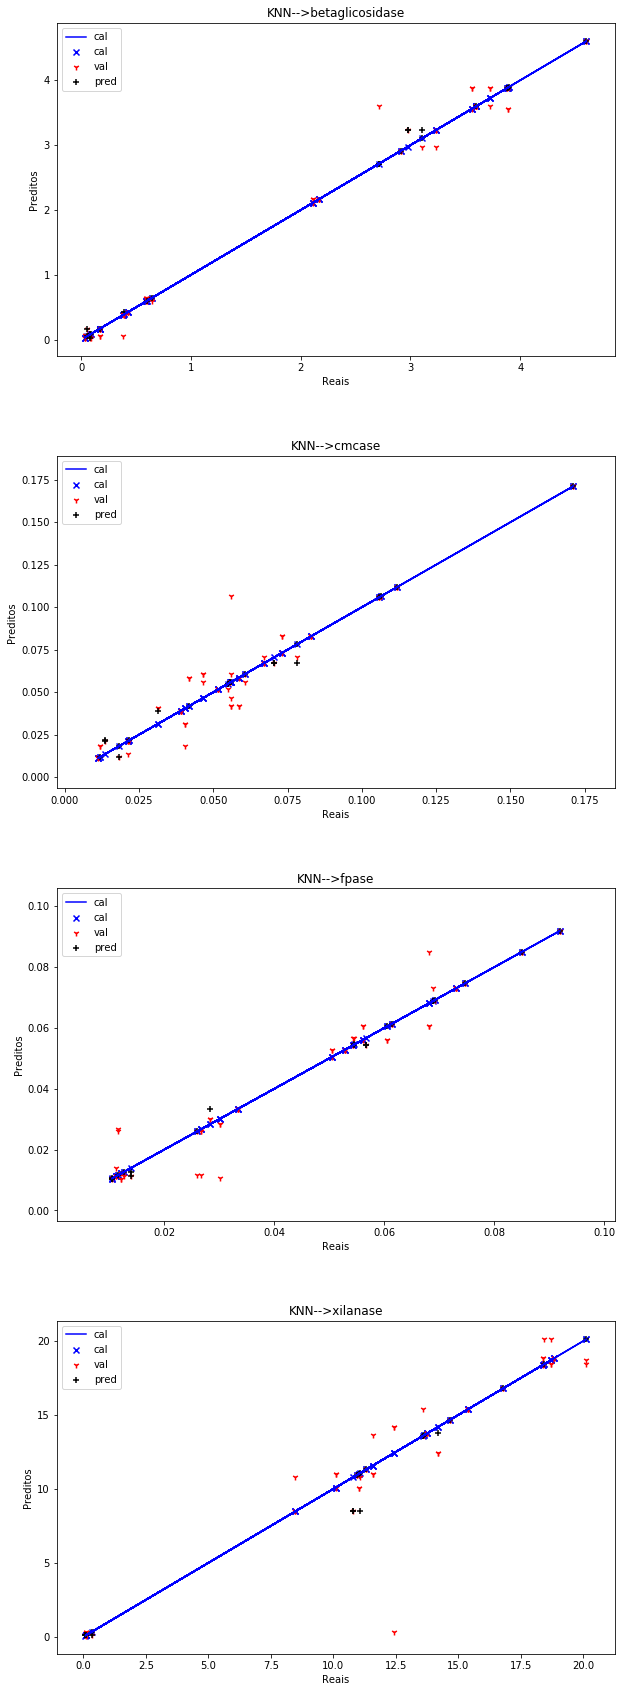

In [164]:
#grafico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### KNN: Gráficos: dados de treino

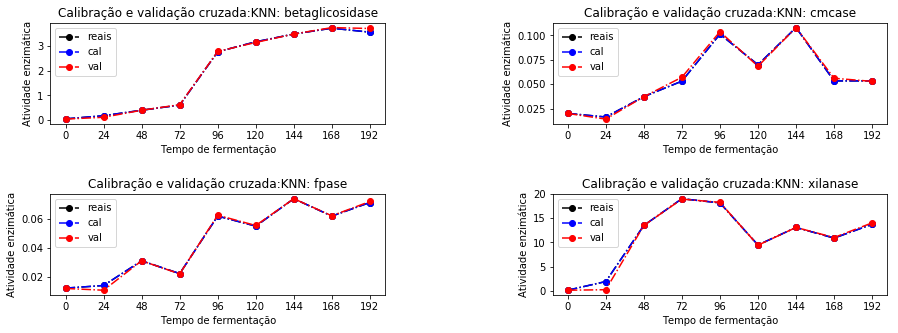

In [165]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### KNN:Gráficos de teste

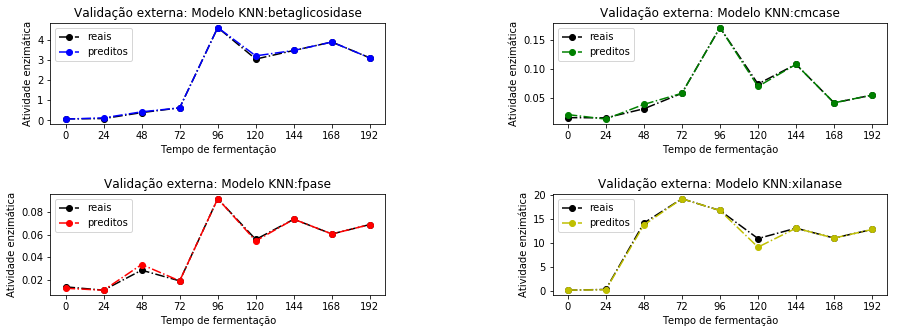

In [166]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

### knn: teste com base externa: EETA desnaturado

In [120]:
#@testeExterno
#rodando o knn com os dados de treino 
modelo = 'KNN:'
preproc=8
k=1
gera=97
result = executaKNN(preproc,k, gera)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

In [182]:
de = dados_back.copy()
de=de[(de['eenz'] == 'eeta')]

In [200]:
de = dados_back.copy()
de=de[(de['experimento'] == 'bioB')&(de['inter']!= 120)]

In [176]:
#buscando base de teste externa
de = dados_back.copy()
de=de[(de['eenz'] == 'eeta')&(de['experimento']=='biod1')&(de['inter']!= 1)&(de['inter']!= 2)&(de['inter']!= 3)&(de['inter']!= 4)&(de['inter']!=20)&(de['inter']!=25)&(de['inter']!=30)]
#Separar somente as amostras que contenham todas as atividades enzimáticas
de = de.loc[(de['betaglicosidase'].notnull()) 
                         & (de['cmcase'].notnull()) 
                         & (de['fpase'].notnull())
                         &(de['xilanase'].notnull())]
de.shape


(12, 713)

In [177]:
de.head(5)

descricao    1100nm    1102nm    1104nm    1106nm    1108nm  \
791  bio_25janp0_1_desn  0.038744  0.038471  0.038295  0.038206  0.038193   
792  bio_25janp0_2_desn  0.038601  0.038637  0.038631  0.038613  0.038621   
793  bio_25janp0_3_desn  0.039642  0.039467  0.039371  0.039322  0.039300   
809  bio_25janp5_1_desn  0.048341  0.046943  0.046041  0.045418  0.044937   
810  bio_25janp5_2_desn  0.048823  0.047629  0.046772  0.046076  0.045451   

       1110nm    1112nm    1114nm    1116nm  ...  cmcase  fpase   xilanase  \
791  0.038237  0.038330  0.038481  0.038710  ...   0.035  0.051  24.094000   
792  0.038688  0.038837  0.039073  0.039391  ...   0.035  0.051  24.094000   
793  0.039299  0.039333  0.039428  0.039612  ...   0.035  0.051  24.094000   
809  0.044537  0.044219  0.044010  0.043935  ...   0.067  0.060  17.361999   
810  0.044883  0.044408  0.044065  0.043873  ...   0.067  0.060  17.361999   

     proteinas  eenz  temp  dur  inter  proc  experimento  
791        NaN  eeta    70   33      0   des        biod1  
792        NaN  eeta    70   33      0   des        biod1  
793        NaN  eeta    70   33      0   des        biod1  
809        NaN  eeta    70   33      5   des        biod1  
810        NaN  eeta    70   33      5   des        biod1  

[5 rows x 713 columns]

In [201]:
#Definindo os dataFrames iniciais para começar o processamento
de_x = de.loc[:,var_abs_txt] #absorbâncias
de_y = de.loc[:,var_ae]#AE
de_inter=pd.DataFrame(de.loc[:,'inter'], columns=['inter'])
#df = dados.loc[:,var_abs_txt+var_ae]

In [197]:
de_x.shape,de_y.shape, de_inter.shape

((21, 244), (21, 4), (21, 1))

In [202]:
#executa pré-processamento equivalente ao do modelo de treinamento
x = executaPreprocSimples(8,de_x)
preditos=reg.predict(x)

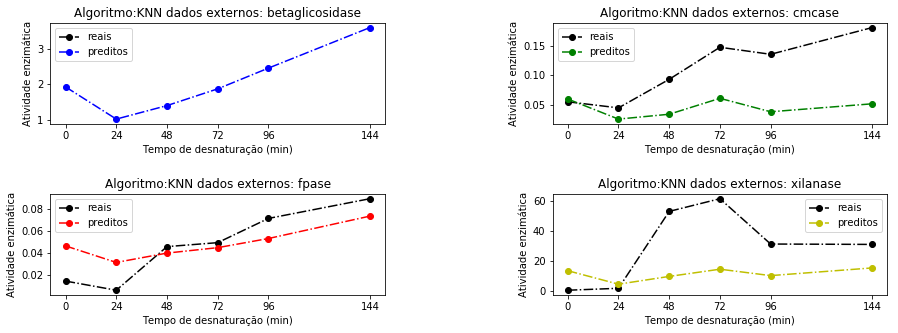

In [203]:
#para exibir o gráfico
#para todas as atividades
#cria um data frame com os valores reais e preditos para os dados de teste
df_pred = {}
for valor in var_ae:
    df_pred[valor] = []
i=0
for valor in var_ae:
    df =pd.DataFrame(columns=['reais','preditos'], index= de_y.index)
    df['reais'] = de_y[valor]
    df['preditos'] = pd.DataFrame(preditos[:,i],index= de_y.index)
    i +=1
    df_pred[valor] = df.copy()
    
df_pred_inter = {}
for valor in var_ae:
    df_pred_inter[valor] = []
for valor in var_ae:
    df_pred_inter[valor] = df_pred[valor].copy()
    df_pred_inter[valor]['inter'] = de_inter.loc[:,'inter']

#ordena valores pelo intervalo
df_ord_teste = {}
for valor in var_ae:
    df_ord_teste[valor] = []
for valor in var_ae:
    df_ord_teste[valor] = df_pred_inter[valor].sort_values(['inter'])

#calculando a média para cada ponto
df_teste_media = {}
for valor in var_ae:
    df_teste_media[valor] = []
for valor in var_ae:
    df_teste_media[valor] = df_ord_teste[valor].groupby('inter').mean()
x = list(df_teste_media['xilanase'].index)
var = ['reais', 'preditos']
tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
j = 0    
fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace = 0.7, wspace=0.5)
for valor in var_ae:
    ax = fig.add_subplot(2,2,j+1)
    ax.plot(x,df_teste_media[valor][var[0]], 'ko-.', label=var[0])
    ax.plot(x,df_teste_media[valor][var[1]], tipoAE[j], label=var[1])
    j +=1
    ax.legend(loc=2)
    ax.set_title('Algoritmo:'+modelo+' dados externos'+': '+valor)
    ax.set_xlabel('Tempo de desnaturação (min)')
    ax.set_ylabel('Atividade enzimática') 
    ax.set_xticks(x)
    plt.legend(loc='best')

## GBR: Gradient Boost Regressor


In [204]:
#gbr
#função completa para execução do GBR
def executaGBR(preproc=1, varLoss='ls',n_est=100,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,IC)

    
    reg = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=n_est,
                                                                  learning_rate=0.1,
                                                                  max_depth=2, 
                                                                  random_state=0, loss=varLoss))

   
    #reg=MultiOutputRegressor(xgb.XGBRegressor())
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result


In [205]:
#função completa para execução do GBR com PCA
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3)
def executaPCA_GBR(preproc, varLoss,nPC=3,n_est=100, IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)

    
    reg = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=n_est,
                                                                  learning_rate=0.1,
                                                                  max_depth=8, 
                                                                  random_state=IC, loss=varLoss))  
   

   # Roda o PCA e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC] 
    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result


### GBR testes

In [206]:

warnings.filterwarnings("ignore")
#GBR teste simples
modelo = 'GBR:'
result = executaGBR(preproc=1, varLoss='ls',n_est=50, IC=0)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
    
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: GBR: 
 MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
           n_jobs=None)
cal
      betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0000  -0.0000  -0.0000   -0.0000
MSE            0.0117   0.0000   0.0000    0.2776
R2             0.9955   0.9884   0.9906    0.9938
RER           41.9128  38.6300  32.1644   37.7645
RMSE           0.1082   0.0041   0.0025    0.5269
RPD           14.8811   9.3018  10.3292   12.6529
RPIQ          29.8617  10.6886  19.5746   17.0020
SEP            0.1091   0.0041   0.0025    0.5313 
-----------------------------------------------------
val
      be

In [265]:

#gbrtestes
#Executa o modelo GBR variando o tipo de processamento  e  o parâmetro loss
loss_valores = ['ls', 'huber']
for k, v in preProc.items():
    print( 'GBR:\n\t'+v)
    for var in loss_valores:
        print('\n>>>>\tLoss:'+var)
        result = executaGBR(k, var)
        #print('Parâmetros do modelo:',modelo,'\n',result[0])

        resultados=exibeResultados(result)

        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')

GBR:
	Pré-proc: 0--> Sem pré-processamento

>>>>	Loss:ls
cal
      betaglicosidase    cmcase    fpase  xilanase
BIAS           0.0000    0.0000   0.0000    0.0000
MSE            0.0008    0.0000   0.0000    0.0205
R2             0.9997    0.9994   0.9988    0.9995
RER          162.2013  166.3827  88.5660  138.8733
RMSE           0.0280    0.0010   0.0009    0.1433
RPD           57.5892   40.0636  28.4418   46.5292
RPIQ         115.5638   46.0367  53.8995   62.5224
SEP            0.0282    0.0010   0.0009    0.1445 
-----------------------------------------------------
val
      betaglicosidase   cmcase   fpase  xilanase
BIAS           0.0811   0.0009  0.0005    0.2056
MSE            0.3181   0.0002  0.0001    8.7746
R2             0.8773   0.8295  0.8459    0.8025
RER            8.1246  10.0728  7.9415    6.7330
RMSE           0.5640   0.0158  0.0102    2.9622
RPD            2.8546   2.4216  2.5472    2.2504
RPIQ           5.7284   2.7827  4.8271    3.0240
SEP            0.5628   0.015

cal
      betaglicosidase    cmcase     fpase  xilanase
BIAS           0.0000   -0.0000    0.0000   -0.0000
MSE            0.0003    0.0000    0.0000    0.0048
R2             0.9999    0.9996    0.9998    0.9999
RER          253.8873  198.7059  247.9922  286.0580
RMSE           0.0179    0.0008    0.0003    0.0696
RPD           90.1421   47.8467   79.6395   95.8431
RPIQ         180.8875   54.9802  150.9231  128.7867
SEP            0.0180    0.0008    0.0003    0.0701 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0338 -0.0018 -0.0000   -0.1611
MSE            0.4882  0.0010  0.0001    3.7160
R2             0.8117  0.3479  0.7988    0.9164
RER            6.4976  5.1518  6.9428   10.3575
RMSE           0.6987  0.0309  0.0116    1.9277
RPD            2.3043  1.2384  2.2296    3.4581
RPIQ           4.6239  1.4230  4.2252    4.6468
SEP            0.7038  0.0311  0.0117    1.9372 
------------------------------------

cal
      betaglicosidase    cmcase     fpase  xilanase
BIAS          -0.0000   -0.0000   -0.0000   -0.0000
MSE            0.0002    0.0000    0.0000    0.0044
R2             0.9999    0.9998    0.9998    0.9999
RER          346.1287  288.2835  210.1594  298.5123
RMSE           0.0131    0.0006    0.0004    0.0667
RPD          122.8922   69.4162   67.4900  100.0159
RPIQ         246.6068   79.7656  127.8988  134.3937
SEP            0.0132    0.0006    0.0004    0.0672 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0052 -0.0018 -0.0011   -0.0348
MSE            0.5992  0.0010  0.0003   12.1086
R2             0.7688  0.3276  0.5906    0.7275
RER            5.8582  5.0727  4.8772    5.7180
RMSE           0.7741  0.0313  0.0166    3.4797
RPD            2.0799  1.2195  1.5630    1.9157
RPIQ           4.1737  1.4014  2.9619    2.5742
SEP            0.7806  0.0316  0.0167    3.5089 
------------------------------------

cal
      betaglicosidase    cmcase     fpase  xilanase
BIAS           0.0000   -0.0000    0.0000   -0.0000
MSE            0.0001    0.0000    0.0000    0.0028
R2             0.9999    0.9999    0.9999    0.9999
RER          371.0931  361.0752  258.5299  378.7833
RMSE           0.0122    0.0004    0.0003    0.0525
RPD          131.7558   86.9439   83.0236  126.9105
RPIQ         264.3932   99.9064  157.3361  170.5327
SEP            0.0123    0.0004    0.0003    0.0530 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0929  0.0011 -0.0000   -0.0988
MSE            0.4645  0.0005  0.0002    2.5208
R2             0.8208  0.6260  0.7744    0.9433
RER            6.7160  6.7993  6.5558   12.5559
RMSE           0.6816  0.0234  0.0123    1.5877
RPD            2.3622  1.6353  2.1053    4.1987
RPIQ           4.7402  1.8791  3.9897    5.6419
SEP            0.6809  0.0235  0.0124    1.5980 
------------------------------------

In [856]:
#gbrtestes - loss = huber
#Executa o modelo GBR variando o tipo de processamento 
for i in [0,1,2,3,4,5,9]:
    print( 'GBR:\n\t'+preProc[i])
    result = executaGBR(k, 'huber')
        

    resultados=exibeResultados(result)

    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

GBR:
	Pré-proc: 0--> Sem pré-processamento
cal
      betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0044   0.0003   0.0001    0.0215
MSE            0.0018   0.0000   0.0000    0.0315
R2             0.9993   0.9966   0.9974    0.9993
RER          106.2526  72.4298  61.7355  112.8940
RMSE           0.0429   0.0022   0.0013    0.1775
RPD           37.5249  17.2717  19.7707   37.5476
RPIQ          75.3009  19.8467  37.4671   50.4535
SEP            0.0430   0.0022   0.0013    0.1777 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0243  0.0012 -0.0003    0.1046
MSE            0.5057  0.0005  0.0002   11.2580
R2             0.8049  0.6398  0.7696    0.7467
RER            6.3802  6.9295  6.4888    5.9327
RMSE           0.7112  0.0229  0.0125    3.3553
RPD            2.2639  1.6662  2.0834    1.9868
RPIQ           4.5430  1.9146  3.9481    2.6697
SEP            0.7167  0.0231  0.0126    3.3820 
-----------

cal
      betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0044   0.0003   0.0001    0.0215
MSE            0.0018   0.0000   0.0000    0.0315
R2             0.9993   0.9966   0.9974    0.9993
RER          106.2526  72.4298  61.7355  112.8940
RMSE           0.0429   0.0022   0.0013    0.1775
RPD           37.5249  17.2717  19.7707   37.5476
RPIQ          75.3009  19.8467  37.4671   50.4535
SEP            0.0430   0.0022   0.0013    0.1777 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0243  0.0012 -0.0003    0.1046
MSE            0.5057  0.0005  0.0002   11.2580
R2             0.8049  0.6398  0.7696    0.7467
RER            6.3802  6.9295  6.4888    5.9327
RMSE           0.7112  0.0229  0.0125    3.3553
RPD            2.2639  1.6662  2.0834    1.9868
RPIQ           4.5430  1.9146  3.9481    2.6697
SEP            0.7167  0.0231  0.0126    3.3820 
-----------------------------------------------------


In [292]:
#teste 2 escolhendo o modelo mais otimizado
#gbrotimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaGBR(10,'ls',n_est=50,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

2% completos

KeyboardInterrupt: 

In [207]:
#gbrtestes -otimizado
modelo= 'GBR:'
result = executaGBR(preproc=10,varLoss = 'ls', n_est=70, IC=0)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: GBR: 
 MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
           n_jobs=None)
cal
      betaglicosidase   cmcase    fpase  xilanase
BIAS          -0.0000  -0.0000   0.0000    0.0000
MSE            0.0026   0.0000   0.0000    0.0811
R2             0.9990   0.9942   0.9975    0.9982
RER           88.1374  54.7326  62.7219   69.8766
RMSE           0.0514   0.0029   0.0013    0.2847
RPD           31.2930  13.1791  20.1423   23.4120
RPIQ          62.7954  15.1440  38.1713   31.4593
SEP            0.0519   0.0029   0.0013    0.2871 
-----------------------------------------------------
val
      be

In [208]:
resultados['cal']

betaglicosidase   cmcase    fpase  xilanase
BIAS          -0.0000  -0.0000   0.0000    0.0000
MSE            0.0026   0.0000   0.0000    0.0811
R2             0.9990   0.9942   0.9975    0.9982
RER           88.1374  54.7326  62.7219   69.8766
RMSE           0.0514   0.0029   0.0013    0.2847
RPD           31.2930  13.1791  20.1423   23.4120
RPIQ          62.7954  15.1440  38.1713   31.4593
SEP            0.0519   0.0029   0.0013    0.2871

In [209]:
resultados['val']

betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0286  0.0001  0.0002   -0.1108
MSE            0.2839  0.0004  0.0001    8.9485
R2             0.8905  0.6928  0.8202    0.7986
RER            8.5229  7.4934  7.3457    6.6557
RMSE           0.5328  0.0212  0.0110    2.9914
RPD            3.0217  1.8043  2.3585    2.2285
RPIQ           6.0636  2.0733  4.4696    2.9944
SEP            0.5365  0.0214  0.0111    3.0146

In [210]:
resultados['pred']

betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0237  -0.0026   0.0002    0.6358
MSE            0.1246   0.0001   0.0000    4.2426
R2             0.9455   0.8732   0.9199    0.8728
RER           10.7189  10.6424  11.1412    9.9808
RMSE           0.3530   0.0095   0.0065    2.0598
RPD            4.2846   2.8083   3.5325    2.8043
RPIQ           8.8774   3.0006   6.3374    1.8843
SEP            0.3609   0.0094   0.0067    2.0076

In [211]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [212]:
#knn reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0759  0.0136  0.0139    0.0726                 0.0842   
1            2.7110  0.0548  0.0688   13.5829                 2.7650   
2            3.5974  0.0516  0.0731   15.3973                 3.5304   
3            2.1643  0.0830  0.0529   18.8324                 2.2567   
4            2.1150  0.0730  0.0505   18.4127                 2.1618   
5            0.0308  0.0213  0.0113    0.0996                 0.0842   
6            3.8803  0.0557  0.0691   11.3256                 3.8664   
7            0.1724  0.0112  0.0121    0.0924                 0.1451   
8            3.5610  0.0586  0.0561   10.0978                 3.6089   
9            0.0759  0.0136  0.0139    0.0726                 0.0842   
10           0.0759  0.0136  0.0139    0.0726                 0.0842   
11           3.5967  0.1065  0.0850   13.6476                 3.5774   
12           4.6037  0.1713  0.0919   16.8115                 4.5525   
13           3.8994  0.1118  0.0613   10.9512                 3.8303   
14           0.5905  0.0465  0.0267   18.7095                 0.5975   
15           0.6491  0.0605  0.0260   18.4274                 0.6255   
16           0.0554  0.0181  0.0106    0.3275                 0.1530   
17           3.8994  0.1118  0.0613   10.9512                 3.8927   
18           0.3900  0.0315  0.0283   14.1777                 0.4320   
19           0.0554  0.0181  0.0106    0.3275                 0.0853   
20           0.6010  0.0559  0.0116   20.1368                 0.6236   
21           3.1068  0.0781  0.0545   11.0526                 3.1340   
22           3.5974  0.0516  0.0731   15.3973                 3.4154   
23           0.0874  0.0217  0.0127    0.1071                 0.0842   
24           0.6010  0.0559  0.0116   20.1368                 0.6151   
25           3.8876  0.0418  0.0605   11.0267                 3.8451   
26           0.1671  0.0117  0.0104    0.1117                 0.1451   
27           3.2342  0.0672  0.0543    8.4772                 3.1608   
28           0.3828  0.0405  0.0301   12.4461                 0.3405   
29           0.6491  0.0605  0.0260   18.4274                 0.6077   
30           2.9123  0.1058  0.0747   14.6813                 2.9927   
31           2.9774  0.0704  0.0567   10.8002                 3.0276   
32           0.4280  0.0390  0.0334   13.7624                 0.4248   
33           0.5905  0.0465  0.0267   18.7095                 0.5975   
34           0.3828  0.0405  0.0301   12.4461                 0.3786   
35           0.0874  0.0217  0.0127    0.1071                 0.0893   
36           3.5974  0.0516  0.0731   15.3973                 3.5286   
37           0.1724  0.0112  0.0121    0.0924                 0.2083   
38           0.0308  0.0213  0.0113    0.0996                 0.0762   
39           2.9123  0.1058  0.0747   14.6813                 2.9101   
40           0.1724  0.0112  0.0121    0.0924                 0.1888   
41           3.2342  0.0672  0.0543    8.4772                 3.1980   
42           0.3828  0.0405  0.0301   12.4461                 0.3692   
43           2.7110  0.0548  0.0688   13.5829                 2.7618   
44           0.4280  0.0390  0.0334   13.7624                 0.3684   
45           4.6037  0.1713  0.0919   16.8115                 4.5630   
46           3.1068  0.0781  0.0545   11.0526                 3.1064   
47           2.1643  0.0830  0.0529   18.8324                 2.2282   
48           3.5610  0.0586  0.0561   10.0978                 3.6089   
49           3.5967  0.1065  0.0850   13.6476                 3.6030   
50           0.1671  0.0117  0.0104    0.1117                 0.1573   
51           3.7243  0.0561  0.0681   11.5736                 3.7685   
52           4.6037  0.1713  0.0919   16.8115                 4.4551   
53           0.3900  0.0315  0.0283   14.1777                 0.3836   
54           0.0554  0.0181  0.0106    0.327

In [213]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0759  0.0136  0.0139    0.0726                 0.1211   
1            2.7110  0.0548  0.0688   13.5829                 2.8842   
2            3.5974  0.0516  0.0731   15.3973                 3.1145   
3            2.1643  0.0830  0.0529   18.8324                 3.2741   
4            2.1150  0.0730  0.0505   18.4127                 2.9946   
5            0.0308  0.0213  0.0113    0.0996                 0.1211   
6            3.8803  0.0557  0.0691   11.3256                 3.2937   
7            0.1724  0.0112  0.0121    0.0924                 0.1134   
8            3.5610  0.0586  0.0561   10.0978                 3.6671   
9            0.0759  0.0136  0.0139    0.0726                 0.0989   
10           0.0759  0.0136  0.0139    0.0726                 0.0989   
11           3.5967  0.1065  0.0850   13.6476                 3.2823   
12           4.6037  0.1713  0.0919   16.8115                 3.7451   
13           3.8994  0.1118  0.0613   10.9512                 3.6977   
14           0.5905  0.0465  0.0267   18.7095                 0.6328   
15           0.6491  0.0605  0.0260   18.4274                 0.6389   
16           0.0554  0.0181  0.0106    0.3275                 0.2903   
17           3.8994  0.1118  0.0613   10.9512                 3.8506   
18           0.3900  0.0315  0.0283   14.1777                 0.6707   
19           0.0554  0.0181  0.0106    0.3275                 0.3132   
20           0.6010  0.0559  0.0116   20.1368                 0.6293   
21           3.1068  0.0781  0.0545   11.0526                 3.6581   
22           3.5974  0.0516  0.0731   15.3973                 2.7571   
23           0.0874  0.0217  0.0127    0.1071                 0.0989   
24           0.6010  0.0559  0.0116   20.1368                 0.5356   
25           3.8876  0.0418  0.0605   11.0267                 3.7519   
26           0.1671  0.0117  0.0104    0.1117                 0.1259   
27           3.2342  0.0672  0.0543    8.4772                 2.9644   
28           0.3828  0.0405  0.0301   12.4461                 0.2510   
29           0.6491  0.0605  0.0260   18.4274                 0.6302   
30           2.9123  0.1058  0.0747   14.6813                 3.3932   
31           2.9774  0.0704  0.0567   10.8002                 3.4245   
32           0.4280  0.0390  0.0334   13.7624                 0.2265   
33           0.5905  0.0465  0.0267   18.7095                 0.6129   
34           0.3828  0.0405  0.0301   12.4461                 0.4137   
35           0.0874  0.0217  0.0127    0.1071                 0.0891   
36           3.5974  0.0516  0.0731   15.3973                 1.0866   
37           0.1724  0.0112  0.0121    0.0924                 0.1727   
38           0.0308  0.0213  0.0113    0.0996                 0.0903   
39           2.9123  0.1058  0.0747   14.6813                 3.1205   
40           0.1724  0.0112  0.0121    0.0924                 0.2210   
41           3.2342  0.0672  0.0543    8.4772                 2.3833   
42           0.3828  0.0405  0.0301   12.4461                 0.3105   
43           2.7110  0.0548  0.0688   13.5829                 2.9921   
44           0.4280  0.0390  0.0334   13.7624                 0.1845   
45           4.6037  0.1713  0.0919   16.8115                 3.4261   
46           3.1068  0.0781  0.0545   11.0526                 3.0751   
47           2.1643  0.0830  0.0529   18.8324                 3.5023   
48           3.5610  0.0586  0.0561   10.0978                 3.5940   
49           3.5967  0.1065  0.0850   13.6476                 3.8319   
50           0.1671  0.0117  0.0104    0.1117                 0.1072   
51           3.7243  0.0561  0.0681   11.5736                 3.6813   
52           4.6037  0.1713  0.0919   16.8115                 3.7868   
53           0.3900  0.0315  0.0283   14.1777                 0.3315   
54           0.0554  0.0181  0.0106    0.327

In [214]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.3900  0.0315  0.0283   14.1777                 0.2856   
1            0.6491  0.0605  0.0260   18.4274                 0.6028   
2            2.9123  0.1058  0.0747   14.6813                 3.1864   
3            0.1671  0.0117  0.0104    0.1117                 0.2185   
4            3.7243  0.0561  0.0681   11.5736                 3.6123   
5            3.8803  0.0557  0.0691   11.3256                 2.8666   
6            0.6010  0.0559  0.0116   20.1368                 0.5975   
7            3.8994  0.1118  0.0613   10.9512                 3.8396   
8            3.2342  0.0672  0.0543    8.4772                 3.1042   
9            0.4280  0.0390  0.0334   13.7624                 0.2783   
10           2.9774  0.0704  0.0567   10.8002                 3.3334   
11           2.1150  0.0730  0.0505   18.4127                 2.0944   
12           2.9774  0.0704  0.0567   10.8002                 3.6650   
13           0.5905  0.0465  0.0267   18.7095                 0.6255   
14           3.8803  0.0557  0.0691   11.3256                 3.0827   
15           0.0874  0.0217  0.0127    0.1071                 0.0842   
16           3.5967  0.1065  0.0850   13.6476                 3.7993   
17           3.8876  0.0418  0.0605   11.0267                 3.6952   
18           2.1643  0.0830  0.0529   18.8324                 2.4910   
19           0.0308  0.0213  0.0113    0.0996                 0.1145   
20           3.7243  0.0561  0.0681   11.5736                 3.8416   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0337       0.0265          9.3818  
1         0.0561       0.0244         17.2181  
2         0.1027       0.0748         14.7998  
3         0.0133       0.0163          0.4034  
4         0.0672       0.0676         11.3799  
5         0.0688       0.0697         12.4162  
6         0.0546       0.0206         19.1675  
7         0.1018       0.0731         11.8792  
8         0.0630       0.0579         11.6378  
9         0.0337       0.0238          7.8443  
10        0.0770       0.0561         10.9070  
11        0.0750       0.0449         17.0003  
12        0.0671       0.0519          9.6762  
13        0.0580       0.0237         18.9442  
14        0.0665       0.0682         12.2814  
15        0.0201       0.0143          0.1813  
16        0.1014       0.0661         10.8735  
17        0.0747       0.0677         11.6667  
18        0.0840       0.0589         17.0333  
19        0.0228       0.0127          0.2780  
20        0.0536       0.0641         10.6382

###  GBR: Gráficos de resíduos - histograma - reais x preditos

In [215]:
#título para os gráficos
modelo = 'GBR'

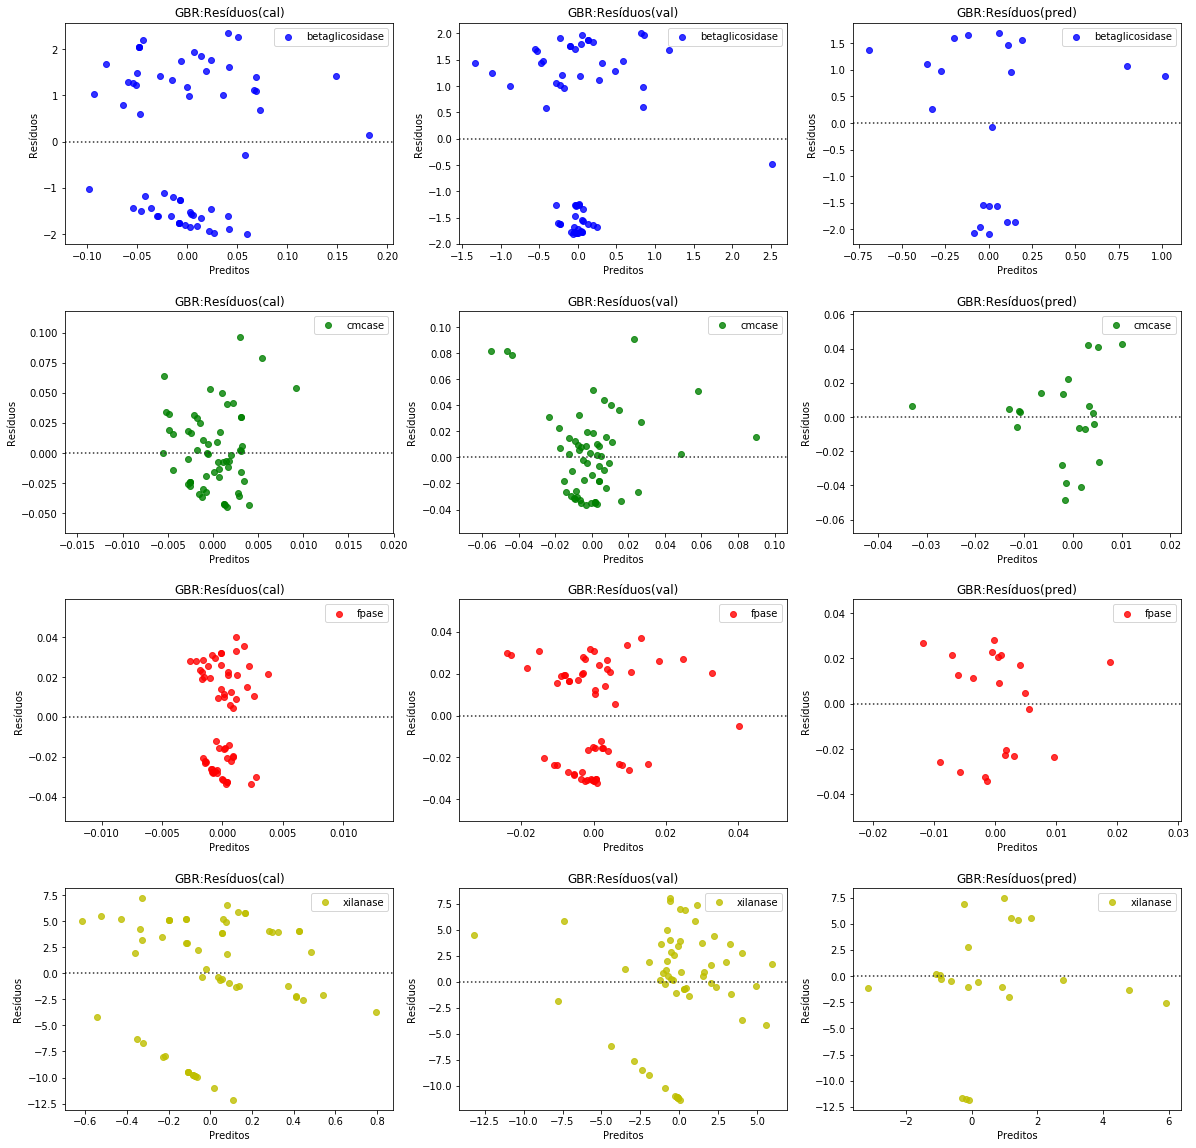

In [216]:
#gráfico dos resíduos
#@gbrgraf
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

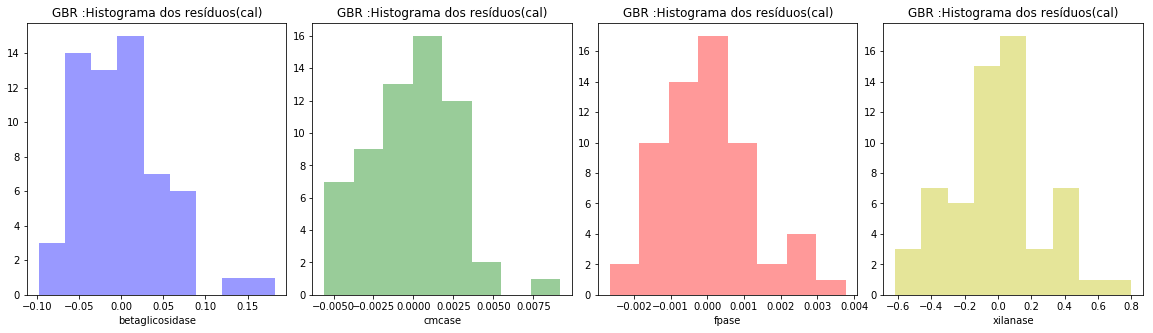

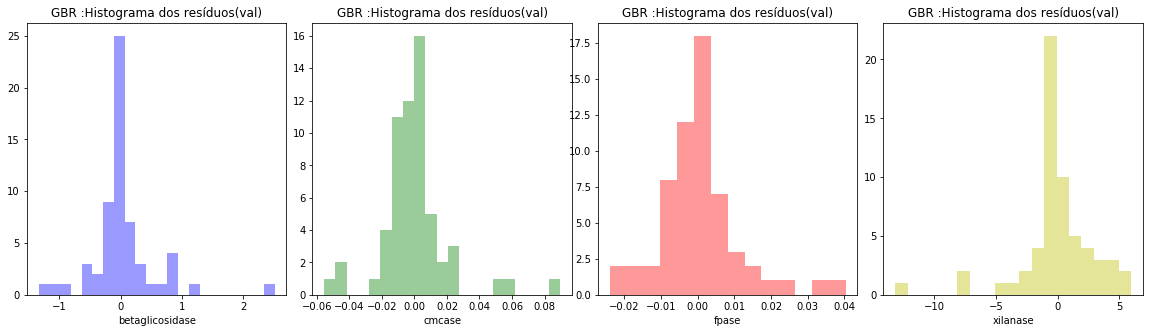

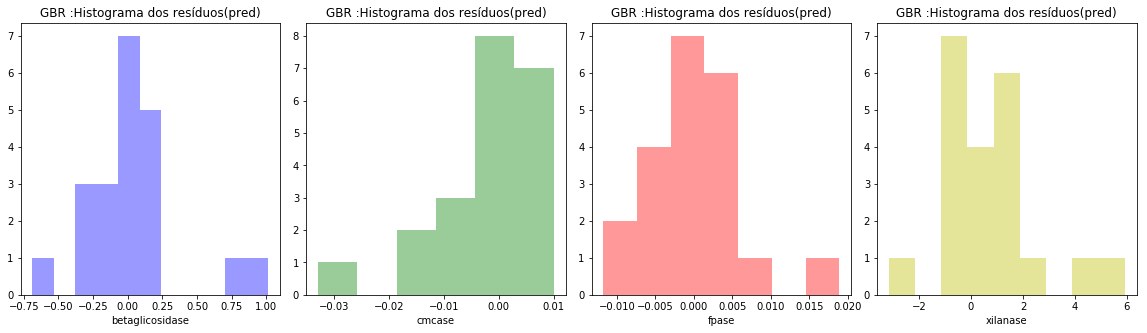

In [217]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

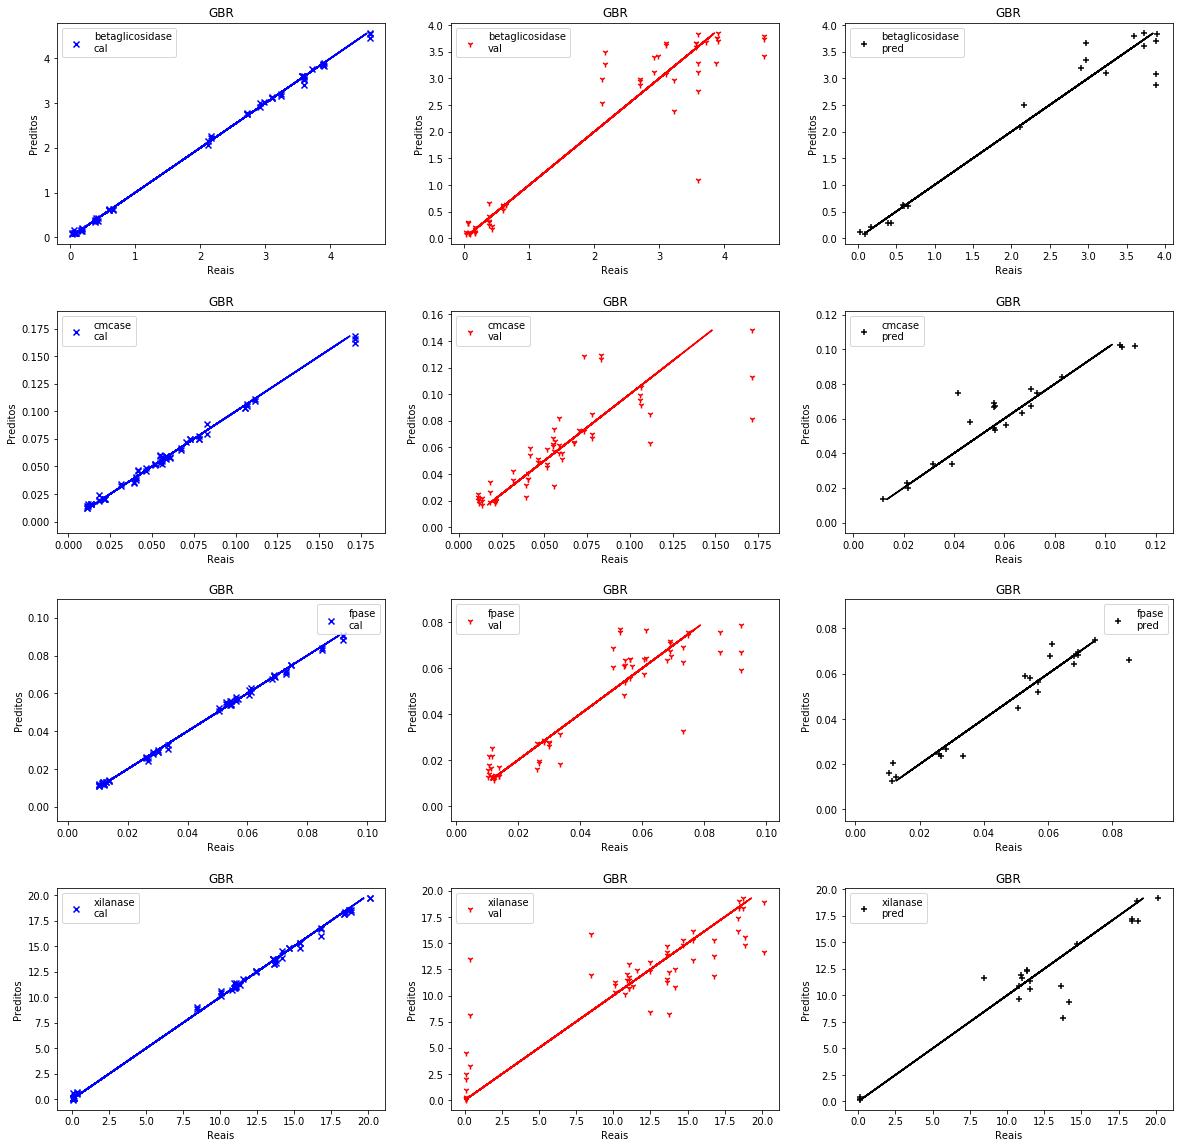

In [218]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

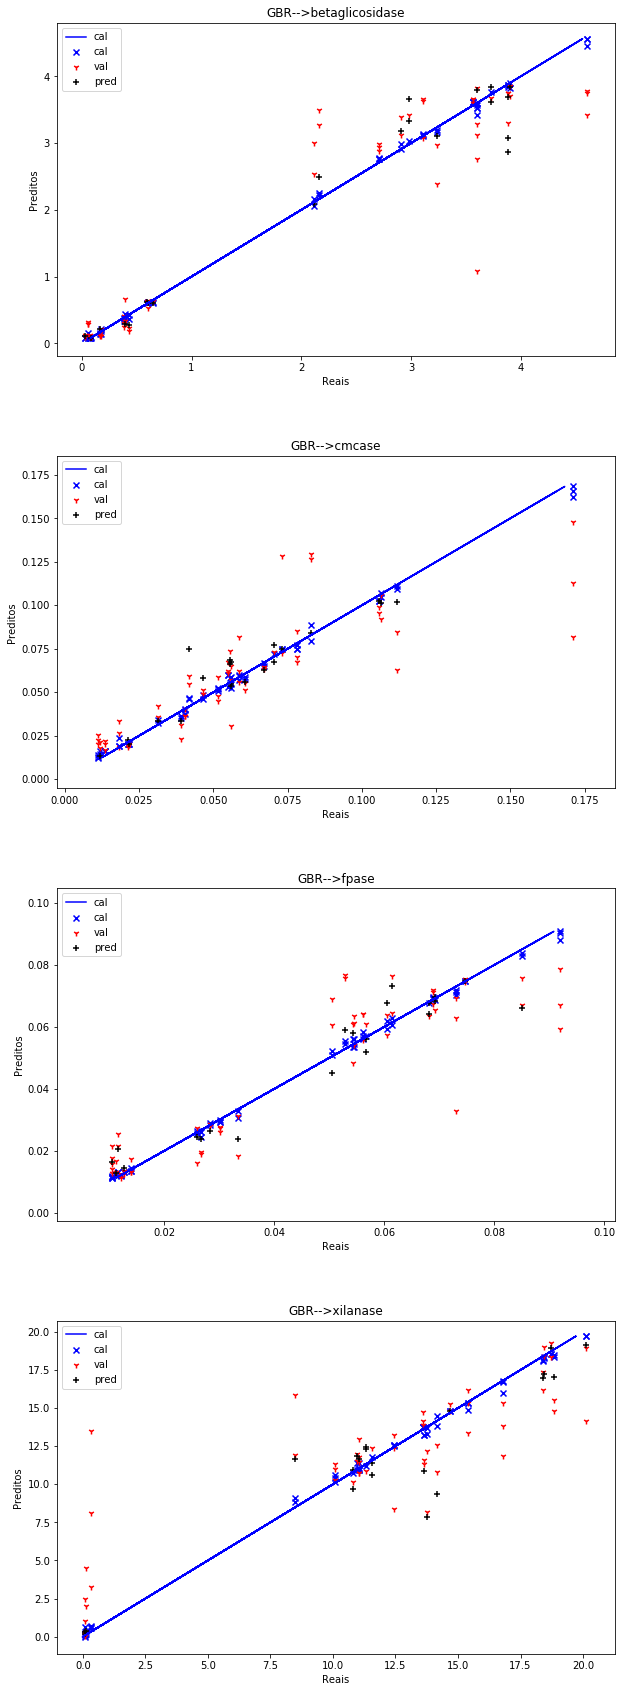

In [219]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### GBR: Gráficos: dados de treino

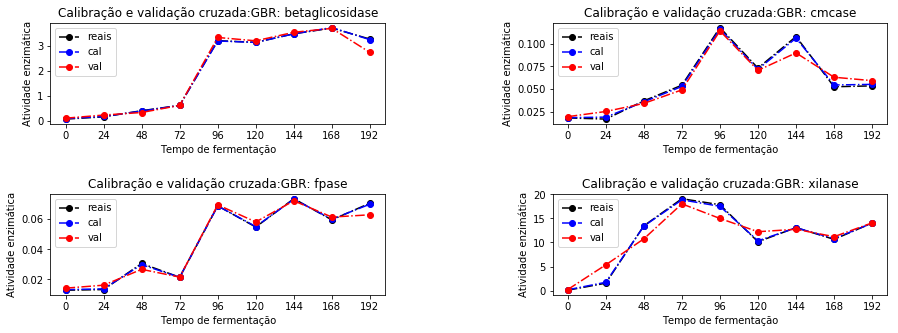

In [220]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### GBR: Gráficos de  teste

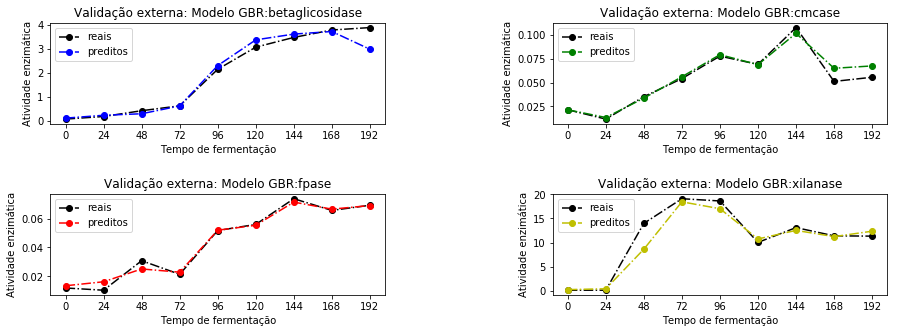

In [221]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

### GBR: teste com base externa: EETA desnaturado

In [120]:
#@gbrtesteExterno
modelo = 'GBR:'
result = executaGBR(preproc=10,varLoss = 'ls', n_est=70, IC=0)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

In [222]:
de = dados_back.copy()
de=de[(de['eenz'] == 'eeta')]

In [223]:
de = dados_back.copy()
de=de[(de['experimento'] == 'bioB')&(de['inter']!= 120)]

In [176]:
#buscando base de teste externa
de = dados_back.copy()
de=de[(de['eenz'] == 'eeta')&(de['experimento']=='biod1')&(de['inter']!= 1)&(de['inter']!= 2)&(de['inter']!= 3)&(de['inter']!= 4)&(de['inter']!=20)&(de['inter']!=25)&(de['inter']!=30)]
#Separar somente as amostras que contenham todas as atividades enzimáticas
de = de.loc[(de['betaglicosidase'].notnull()) 
                         & (de['cmcase'].notnull()) 
                         & (de['fpase'].notnull())
                         &(de['xilanase'].notnull())]
de.shape


(12, 713)

In [177]:
de.head(5)

descricao    1100nm    1102nm    1104nm    1106nm    1108nm  \
791  bio_25janp0_1_desn  0.038744  0.038471  0.038295  0.038206  0.038193   
792  bio_25janp0_2_desn  0.038601  0.038637  0.038631  0.038613  0.038621   
793  bio_25janp0_3_desn  0.039642  0.039467  0.039371  0.039322  0.039300   
809  bio_25janp5_1_desn  0.048341  0.046943  0.046041  0.045418  0.044937   
810  bio_25janp5_2_desn  0.048823  0.047629  0.046772  0.046076  0.045451   

       1110nm    1112nm    1114nm    1116nm  ...  cmcase  fpase   xilanase  \
791  0.038237  0.038330  0.038481  0.038710  ...   0.035  0.051  24.094000   
792  0.038688  0.038837  0.039073  0.039391  ...   0.035  0.051  24.094000   
793  0.039299  0.039333  0.039428  0.039612  ...   0.035  0.051  24.094000   
809  0.044537  0.044219  0.044010  0.043935  ...   0.067  0.060  17.361999   
810  0.044883  0.044408  0.044065  0.043873  ...   0.067  0.060  17.361999   

     proteinas  eenz  temp  dur  inter  proc  experimento  
791        NaN  eeta    70   33      0   des        biod1  
792        NaN  eeta    70   33      0   des        biod1  
793        NaN  eeta    70   33      0   des        biod1  
809        NaN  eeta    70   33      5   des        biod1  
810        NaN  eeta    70   33      5   des        biod1  

[5 rows x 713 columns]

In [224]:
#Definindo os dataFrames iniciais para começar o processamento
de_x = de.loc[:,var_abs_txt] #absorbâncias
de_y = de.loc[:,var_ae]#AE
de_inter=pd.DataFrame(de.loc[:,'inter'], columns=['inter'])
#df = dados.loc[:,var_abs_txt+var_ae]

In [197]:
de_x.shape,de_y.shape, de_inter.shape

((21, 244), (21, 4), (21, 1))

In [227]:
#executa pré-processamento equivalente ao do modelo de treinamento
x = executaPreprocSimples(1,de_x)
preditos=reg.predict(x)

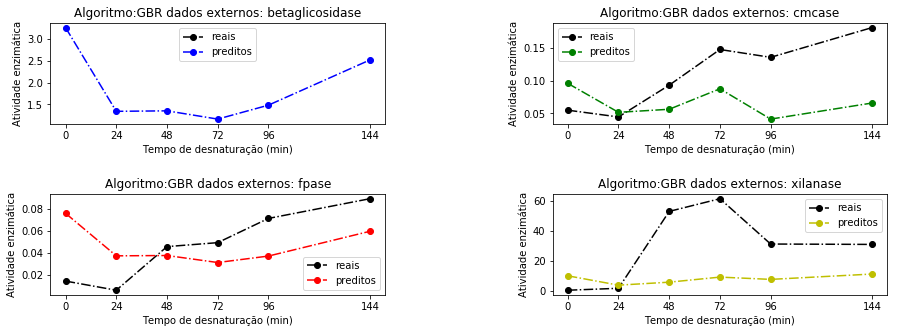

In [228]:
#para exibir o gráfico
#para todas as atividades
#cria um data frame com os valores reais e preditos para os dados de teste
df_pred = {}
for valor in var_ae:
    df_pred[valor] = []
i=0
for valor in var_ae:
    df =pd.DataFrame(columns=['reais','preditos'], index= de_y.index)
    df['reais'] = de_y[valor]
    df['preditos'] = pd.DataFrame(preditos[:,i],index= de_y.index)
    i +=1
    df_pred[valor] = df.copy()
    
df_pred_inter = {}
for valor in var_ae:
    df_pred_inter[valor] = []
for valor in var_ae:
    df_pred_inter[valor] = df_pred[valor].copy()
    df_pred_inter[valor]['inter'] = de_inter.loc[:,'inter']

#ordena valores pelo intervalo
df_ord_teste = {}
for valor in var_ae:
    df_ord_teste[valor] = []
for valor in var_ae:
    df_ord_teste[valor] = df_pred_inter[valor].sort_values(['inter'])

#calculando a média para cada ponto
df_teste_media = {}
for valor in var_ae:
    df_teste_media[valor] = []
for valor in var_ae:
    df_teste_media[valor] = df_ord_teste[valor].groupby('inter').mean()
x = list(df_teste_media['xilanase'].index)
var = ['reais', 'preditos']
tipoAE= ['bo-.', 'go-.','ro-.', 'yo-.']
j = 0    
fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace = 0.7, wspace=0.5)
for valor in var_ae:
    ax = fig.add_subplot(2,2,j+1)
    ax.plot(x,df_teste_media[valor][var[0]], 'ko-.', label=var[0])
    ax.plot(x,df_teste_media[valor][var[1]], tipoAE[j], label=var[1])
    j +=1
    ax.legend(loc=2)
    ax.set_title('Algoritmo:'+modelo+' dados externos'+': '+valor)
    ax.set_xlabel('Tempo de desnaturação (min)')
    ax.set_ylabel('Atividade enzimática') 
    ax.set_xticks(x)
    plt.legend(loc='best')

## PLS

### PLS: função completa

In [229]:
#pls
#função completa para execução do PLS:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPLS(preproc,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,IC)
  
   
    #Calcula o número de componentes ideal para o PLS
    mse = []
    component = np.arange(1, 20)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Fit
        pls.fit(x_treino, y_treino)
        # Prediction
        Y_pred = pls.predict(x_teste)

        mse_p = mean_squared_error(y_teste, Y_pred)
        mse.append(mse_p)

        comp = 100*(i+1)/20
        # Truque para atualizar o progresso do processamento na mesma linha
        print("\r%d%% completed " % comp, end='')

    # Calcula e imprime a posição do menor valor de MSE
    msemin = np.argmin(mse)
    print("Sugestão para o número de variáveis latentes: ", msemin+1)

 
    with plt.style.context(('ggplot')):
        plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
        plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
        plt.xlabel('Numero de componentes para o PLS')
        plt.ylabel('MSE')
        plt.title('PLS')
        plt.xlim(xmin=-1)

        plt.show()   

    # Roda o PLS e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pls = PLSRegression(n_components=msemin+1)
        
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], pls)
    
    dic = {'result':result,'min':msemin+1}
    return dic

    

In [230]:
#função completa para execução do PLS:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPLSResumida(preproc=1, nPC=3, padroniza=False, max=500,IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,padroniza,IC)
  
   
    #Calcula o número de componentes ideal para o PLS
    component = nPC
   
    # Roda o PLS e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pls = PLSRegression(n_components=nPC, max_iter=max)
        
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], pls)
    
    return result

### PLS: testes

In [231]:
preK = list(preProc.keys())
preV = list(preProc.values())

Pré-proc: 0--> Sem pré-processamento
100% completed Sugestão para o número de variáveis latentes:  14


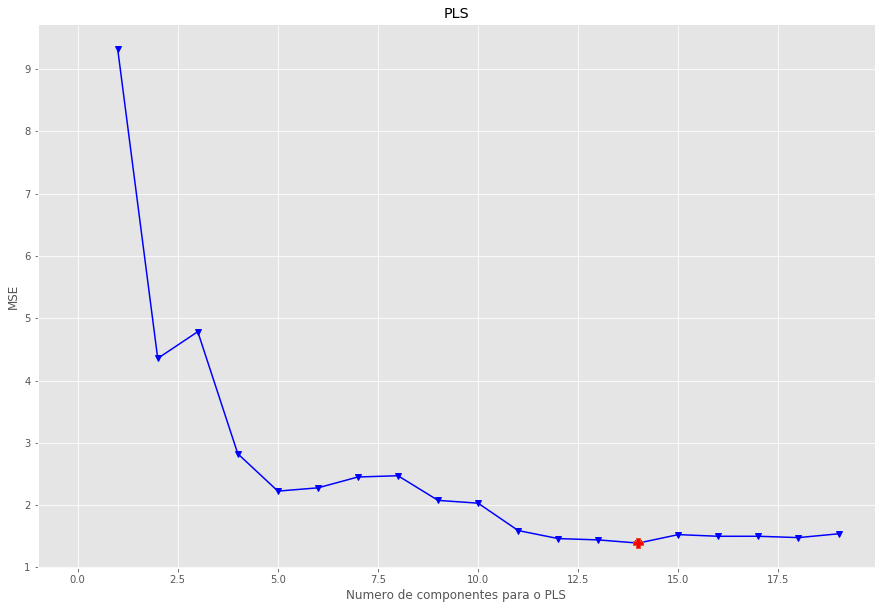

Pré-proc: 1--> Padronização
100% completed Sugestão para o número de variáveis latentes:  19


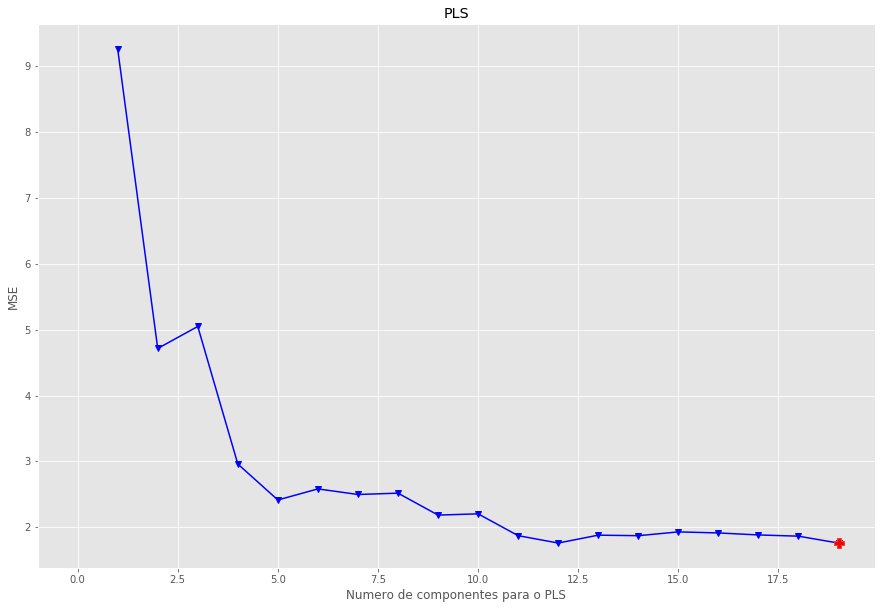

Pré-proc: 2--> Suavização(SavGol) - Par:3,1,1
100% completed Sugestão para o número de variáveis latentes:  14


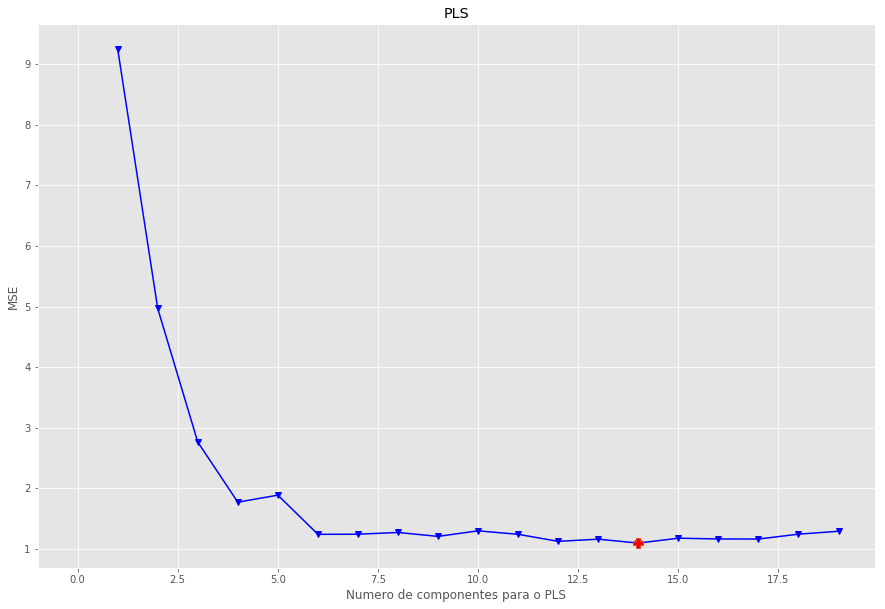

Pré-proc: 3--> Suavização(SavGol) - Par:3,2,1
100% completed Sugestão para o número de variáveis latentes:  14


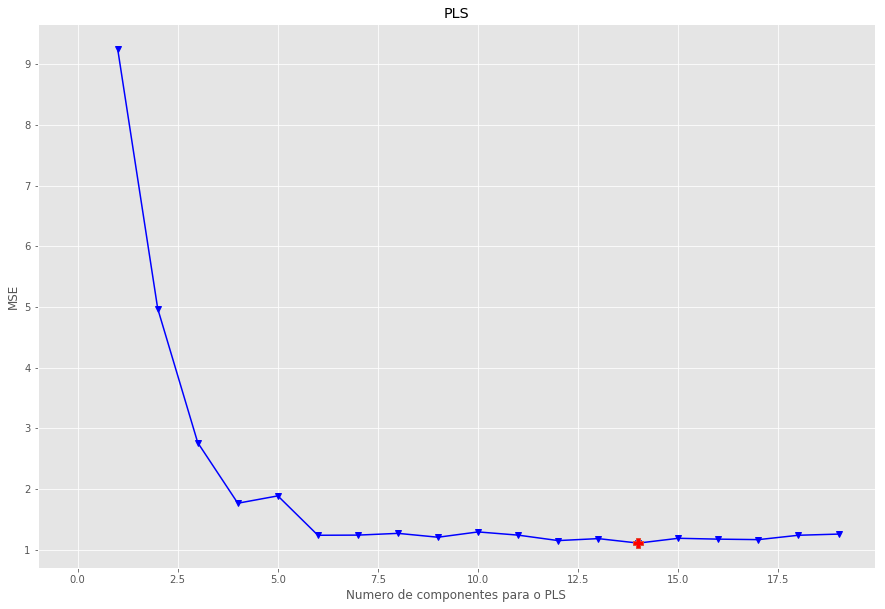

Pré-proc: 4--> Suavização(SavGol) - Par:5,1,1
100% completed Sugestão para o número de variáveis latentes:  9


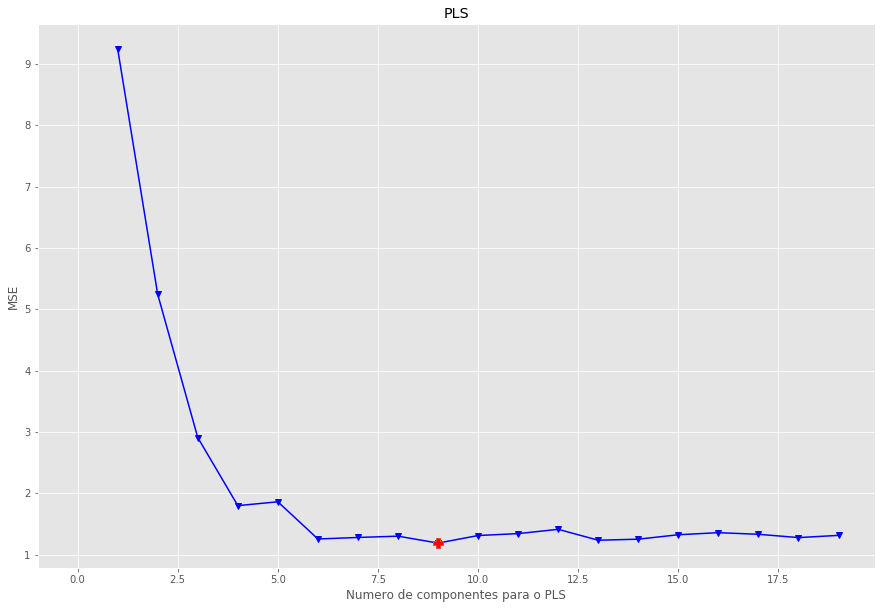

Pré-proc: 5--> Suavização(SavGol) - Par:5,2,1
100% completed Sugestão para o número de variáveis latentes:  16


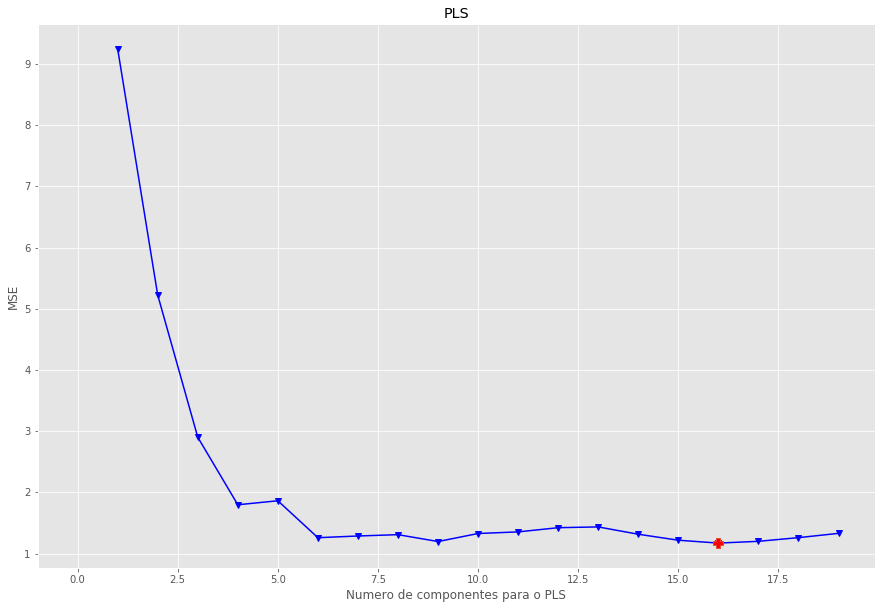

Pré-proc: 6--> Suavização(SavGol) - Par:3,2,2
100% completed Sugestão para o número de variáveis latentes:  14


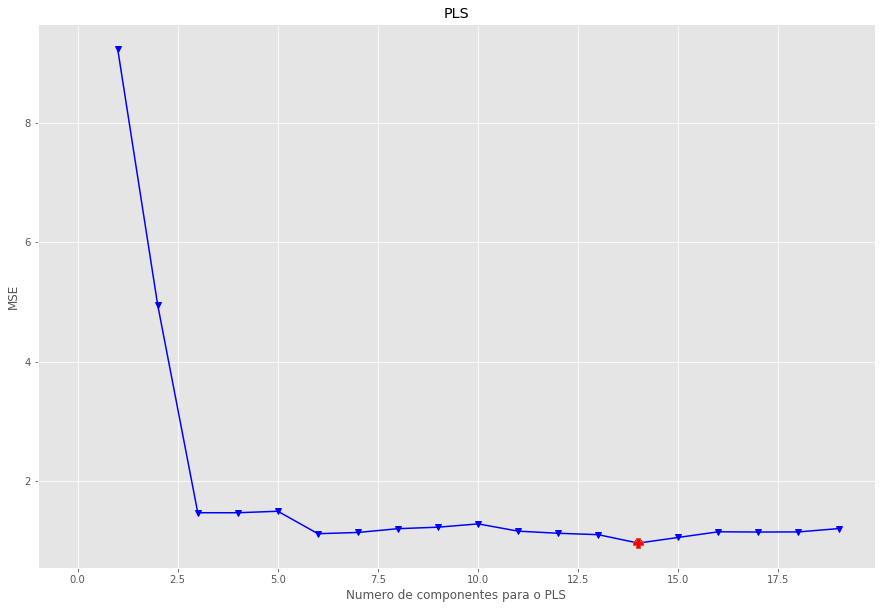

Pré-proc: 7--> Suavização(SavGol) - Par:5,2,2
100% completed Sugestão para o número de variáveis latentes:  16


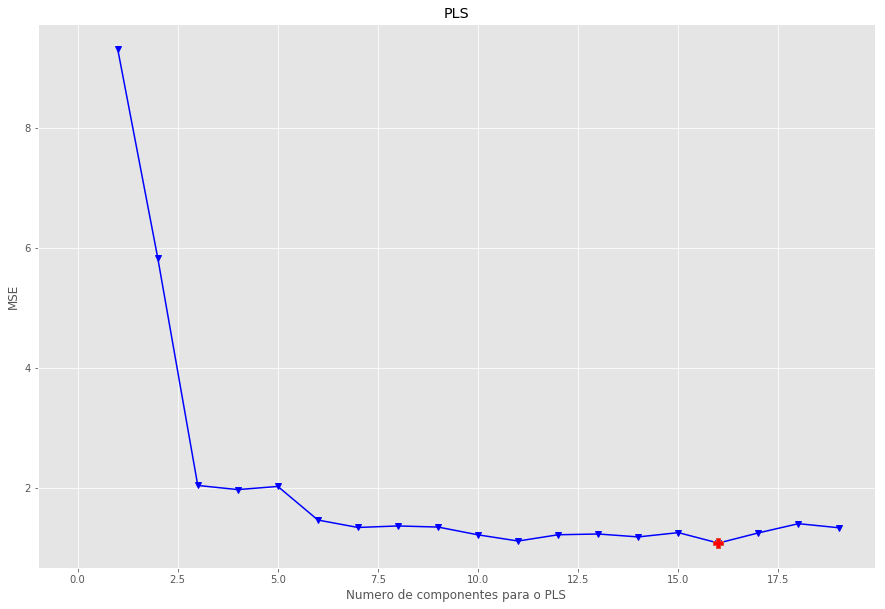

Pré-proc: 8--> Suavização(SavGol) - Par:3,1,1 --> Padronização
100% completed Sugestão para o número de variáveis latentes:  14


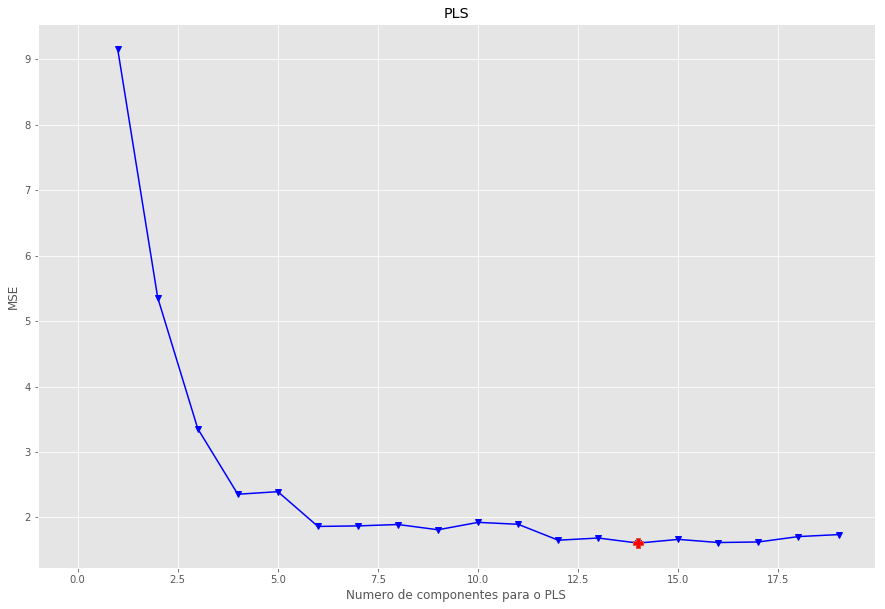

Pré-proc: 9--> Padronização --> Suavização(SavGol) - Par:3,1,1
100% completed Sugestão para o número de variáveis latentes:  19


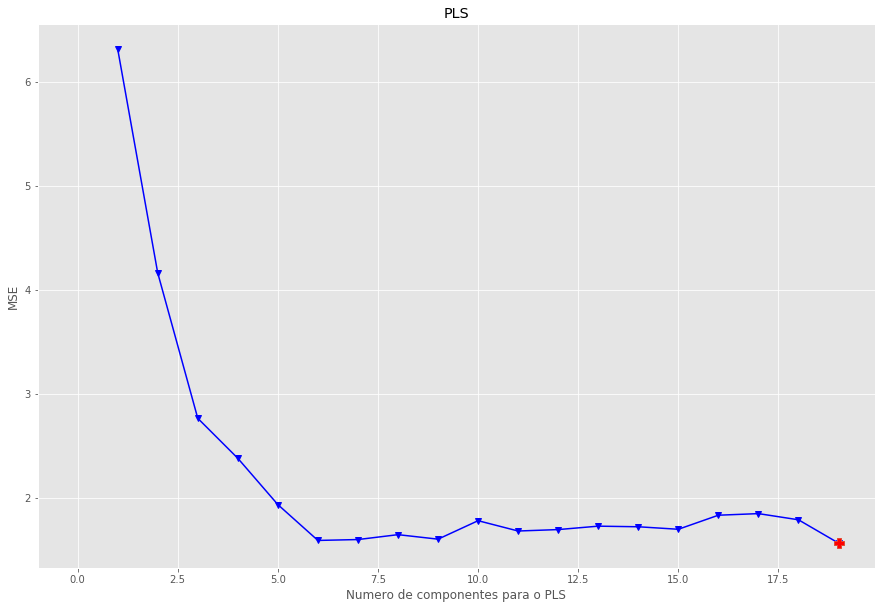

Pré-proc: 10--> MSC
100% completed Sugestão para o número de variáveis latentes:  15


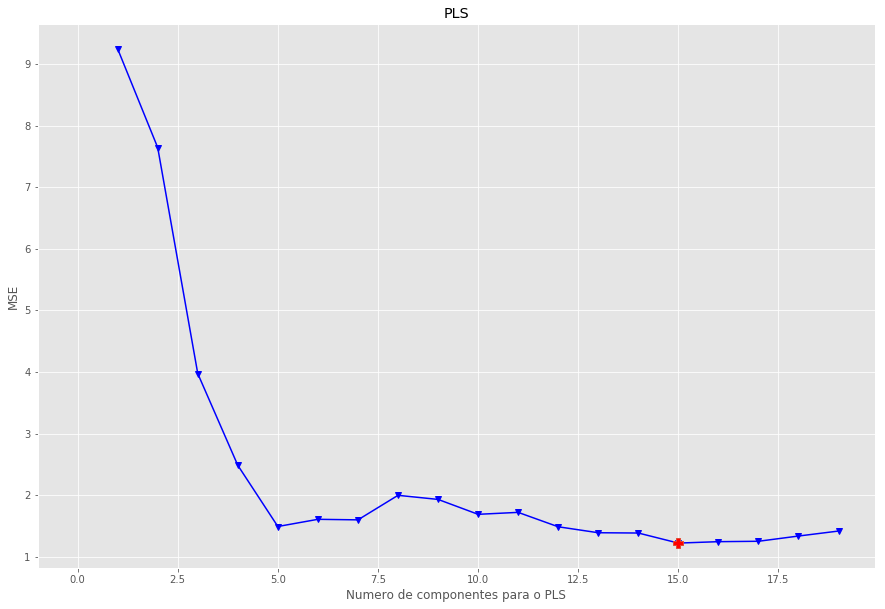

Pré-proc: 11--> SNV
100% completed Sugestão para o número de variáveis latentes:  18


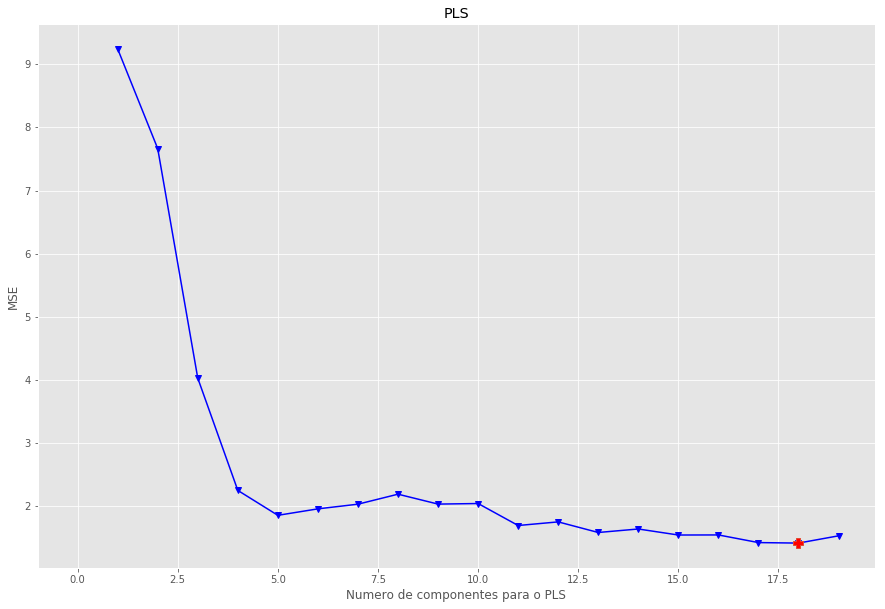

In [232]:
nVL = []
for k in preK:
    print(preProc[k])
    dic = executaPLS(k)
    nVL.append(dic['min'])

In [233]:
#pls teste simples
for k in range(12):
    print(preProc[k])
    result = executaPLSResumida(k,nVL[k])
    print('Parâmetros do modelo:',modelo,'\n',result[0])

    resultados=exibeResultados(result)
    
    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

 

Pré-proc: 0--> Sem pré-processamento
Parâmetros do modelo: GBR 
 PLSRegression(copy=True, max_iter=500, n_components=14, scale=True, tol=1e-06)
cal
      betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0000   0.0000   0.0000    0.0000
MSE            0.1021   0.0001   0.0000    1.7928
R2             0.9606   0.9241   0.9523    0.9597
RER           14.1950  15.0714  14.2649   14.8595
RMSE           0.3195   0.0105   0.0057    1.3390
RPD            5.0399   3.6291   4.5810    4.9786
RPIQ          10.1135   4.1701   8.6813    6.6899
SEP            0.3221   0.0106   0.0057    1.3503 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0692 -0.0034 -0.0012   -0.1523
MSE            0.7906  0.0013  0.0002    8.1842
R2             0.6950  0.1395  0.6730    0.8158
RER            5.1153  4.4979  5.4647    6.9647
RMSE           0.8892  0.0355  0.0148    2.8608
RPD            1.8107  1.0780  1.7487    2.3302
RPIQ   

Parâmetros do modelo: GBR 
 PLSRegression(copy=True, max_iter=500, n_components=16, scale=True, tol=1e-06)
cal
      betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0000   0.0000   0.0000   -0.0000
MSE            0.0608   0.0001   0.0000    1.3326
R2             0.9766   0.9434   0.9723    0.9700
RER           18.3933  17.4490  18.7198   17.2352
RMSE           0.2465   0.0091   0.0043    1.1544
RPD            6.5305   4.2016   6.0116    5.7746
RPIQ          13.1047   4.8280  11.3925    7.7595
SEP            0.2486   0.0092   0.0044    1.1641 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0599 -0.0018 -0.0007   -0.0735
MSE            0.8499  0.0014  0.0002    4.8414
R2             0.6721  0.0348  0.6719    0.8911
RER            4.9292  4.2322  5.4412    9.0475
RMSE           0.9219  0.0375  0.0149    2.2003
RPD            1.7464  1.0179  1.7457    3.0297
RPIQ           3.5045  1.1696  3.3083    4.0

Parâmetros do modelo: GBR 
 PLSRegression(copy=True, max_iter=500, n_components=15, scale=True, tol=1e-06)
cal
      betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0000   0.0000   0.0000   -0.0000
MSE            0.1029   0.0001   0.0000    1.4056
R2             0.9603   0.9216   0.9517    0.9684
RER           14.1389  14.8337  14.1761   16.7821
RMSE           0.3207   0.0107   0.0057    1.1856
RPD            5.0200   3.5718   4.5525    5.6228
RPIQ          10.0736   4.1044   8.6273    7.5555
SEP            0.3234   0.0108   0.0057    1.1956 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0023 -0.0017 -0.0008   -0.0049
MSE            0.8116  0.0013  0.0003    7.6776
R2             0.6869  0.1289  0.6226    0.8272
RER            5.0334  4.4547  5.0743    7.1806
RMSE           0.9009  0.0357  0.0159    2.7709
RPD            1.7871  1.0714  1.6277    2.4058
RPIQ           3.5861  1.2312  3.0847    3.2

In [261]:
#pls otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaPLSResumida(preproc=9,nPC=6,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.9285, 0.844, 0.9411, 0.8928] 
semente: b c f x [96, 96, 27, 88]


In [264]:
#PLS teste otimizado
modelo = 'PLS:'
result = executaPLSResumida(preproc=9,nPC=6,IC=88)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: PLS: 
 PLSRegression(copy=True, max_iter=500, n_components=6, scale=True, tol=1e-06)


In [265]:
resultados['cal']

betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0000   0.0000   0.0000    0.0000
MSE            0.2632   0.0002   0.0000    3.8078
R2             0.8926   0.8392   0.9244    0.9034
RER            8.8395  11.3778  12.2213   10.1961
RMSE           0.5130   0.0139   0.0066    1.9514
RPD            3.0519   2.4939   3.6360    3.2170
RPIQ           6.1813   2.5665   5.3489    2.9235
SEP            0.5173   0.0141   0.0067    1.9678

In [266]:
resultados['val']

betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0292  0.0000 -0.0001   -0.0759
MSE            0.4224  0.0005  0.0001    7.9623
R2             0.8277  0.5467  0.8312    0.7980
RER            6.9846  6.7767  8.1806    7.0536
RMSE           0.6499  0.0234  0.0099    2.8218
RPD            2.4091  1.4854  2.4337    2.2247
RPIQ           4.8792  1.5286  3.5802    2.0217
SEP            0.6547  0.0236  0.0100    2.8445

In [267]:
resultados['pred']

betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0655 -0.0041  0.0002   -0.8397
MSE            0.4054  0.0005  0.0001    5.1866
R2             0.8521  0.6823  0.8386    0.8928
RER            7.0083  7.4870  6.9417    9.2494
RMSE           0.6367  0.0213  0.0115    2.2774
RPD            2.6006  1.7740  2.4895    3.0537
RPIQ           5.3780  1.8272  4.7992    5.8488
SEP            0.6490  0.0214  0.0117    2.1692

In [268]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [269]:
#pls reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            2.9123  0.1058  0.0747   14.6813                 3.8214   
1            0.1724  0.0112  0.0121    0.0924                 0.1393   
2            3.5610  0.0586  0.0561   10.0978                 3.2643   
3            3.8876  0.0418  0.0605   11.0267                 3.0345   
4            0.3900  0.0315  0.0283   14.1777                 0.7269   
5            3.8994  0.1118  0.0613   10.9512                 3.5483   
6            0.3828  0.0405  0.0301   12.4461                 1.0102   
7            0.4280  0.0390  0.0334   13.7624                 0.8989   
8            3.2342  0.0672  0.0543    8.4772                 2.9166   
9            3.2342  0.0672  0.0543    8.4772                 3.0917   
10           0.5905  0.0465  0.0267   18.7095                 0.3204   
11           3.5610  0.0586  0.0561   10.0978                 3.4985   
12           2.7110  0.0548  0.0688   13.5829                 3.3673   
13           2.9123  0.1058  0.0747   14.6813                 3.9315   
14           3.8803  0.0557  0.0691   11.3256                 3.4247   
15           0.0874  0.0217  0.0127    0.1071                 0.0194   
16           4.6037  0.1713  0.0919   16.8115                 3.2953   
17           3.5967  0.1065  0.0850   13.6476                 3.6088   
18           3.5974  0.0516  0.0731   15.3973                 2.8590   
19           3.8994  0.1118  0.0613   10.9512                 3.3366   
20           0.4280  0.0390  0.0334   13.7624                 0.5887   
21           0.6491  0.0605  0.0260   18.4274                 0.1827   
22           2.1643  0.0830  0.0529   18.8324                 2.3864   
23           2.9774  0.0704  0.0567   10.8002                 3.0298   
24           0.3900  0.0315  0.0283   14.1777                 0.7196   
25           3.1068  0.0781  0.0545   11.0526                 3.1532   
26           3.2342  0.0672  0.0543    8.4772                 3.3141   
27           3.1068  0.0781  0.0545   11.0526                 4.0406   
28           2.1150  0.0730  0.0505   18.4127                 2.3251   
29           3.8876  0.0418  0.0605   11.0267                 3.8726   
30           0.4280  0.0390  0.0334   13.7624                 0.8937   
31           0.6010  0.0559  0.0116   20.1368                 0.3691   
32           0.0308  0.0213  0.0113    0.0996                -0.5633   
33           0.3900  0.0315  0.0283   14.1777                 0.5584   
34           3.8994  0.1118  0.0613   10.9512                 3.5846   
35           0.0308  0.0213  0.0113    0.0996                -0.2979   
36           3.5974  0.0516  0.0731   15.3973                 3.1041   
37           0.1724  0.0112  0.0121    0.0924                 0.4933   
38           4.6037  0.1713  0.0919   16.8115                 3.3030   
39           0.0554  0.0181  0.0106    0.3275                 0.3272   
40           3.5610  0.0586  0.0561   10.0978                 2.9645   
41           2.1150  0.0730  0.0505   18.4127                 2.0591   
42           0.1671  0.0117  0.0104    0.1117                 0.5123   
43           2.1643  0.0830  0.0529   18.8324                 2.3466   
44           0.0874  0.0217  0.0127    0.1071                -0.2098   
45           0.1671  0.0117  0.0104    0.1117                 0.4715   
46           0.6491  0.0605  0.0260   18.4274                 1.0077   
47           0.0554  0.0181  0.0106    0.3275                 0.3213   
48           2.1643  0.0830  0.0529   18.8324                 2.6048   
49           0.0759  0.0136  0.0139    0.0726                 0.3375   
50           3.7243  0.0561  0.0681   11.5736                 3.5883   
51           0.0308  0.0213  0.0113    0.0996                -0.0415   
52           0.5905  0.0465  0.0267   18.7095                 0.5261   
53           2.9774  0.0704  0.0567   10.8002                 3.2048   
54           3.7243  0.0561  0.0681   11.573

In [270]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            2.9123  0.1058  0.0747   14.6813                 3.7481   
1            0.1724  0.0112  0.0121    0.0924                 0.2700   
2            3.5610  0.0586  0.0561   10.0978                 3.1872   
3            3.8876  0.0418  0.0605   11.0267                 2.9298   
4            0.3900  0.0315  0.0283   14.1777                 0.7955   
5            3.8994  0.1118  0.0613   10.9512                 3.3279   
6            0.3828  0.0405  0.0301   12.4461                 0.9848   
7            0.4280  0.0390  0.0334   13.7624                 1.2943   
8            3.2342  0.0672  0.0543    8.4772                 2.8837   
9            3.2342  0.0672  0.0543    8.4772                 3.0828   
10           0.5905  0.0465  0.0267   18.7095                 0.2113   
11           3.5610  0.0586  0.0561   10.0978                 3.4435   
12           2.7110  0.0548  0.0688   13.5829                 3.7146   
13           2.9123  0.1058  0.0747   14.6813                 3.9168   
14           3.8803  0.0557  0.0691   11.3256                 3.6428   
15           0.0874  0.0217  0.0127    0.1071                -0.0387   
16           4.6037  0.1713  0.0919   16.8115                 2.6067   
17           3.5967  0.1065  0.0850   13.6476                 3.4998   
18           3.5974  0.0516  0.0731   15.3973                 2.6632   
19           3.8994  0.1118  0.0613   10.9512                 3.0558   
20           0.4280  0.0390  0.0334   13.7624                 0.6297   
21           0.6491  0.0605  0.0260   18.4274                 0.1813   
22           2.1643  0.0830  0.0529   18.8324                 2.3272   
23           2.9774  0.0704  0.0567   10.8002                 3.0467   
24           0.3900  0.0315  0.0283   14.1777                 0.7722   
25           3.1068  0.0781  0.0545   11.0526                 3.2339   
26           3.2342  0.0672  0.0543    8.4772                 3.3278   
27           3.1068  0.0781  0.0545   11.0526                 4.1550   
28           2.1150  0.0730  0.0505   18.4127                 2.5194   
29           3.8876  0.0418  0.0605   11.0267                 4.1670   
30           0.4280  0.0390  0.0334   13.7624                 1.0420   
31           0.6010  0.0559  0.0116   20.1368                 0.2622   
32           0.0308  0.0213  0.0113    0.0996                -0.7108   
33           0.3900  0.0315  0.0283   14.1777                 0.7662   
34           3.8994  0.1118  0.0613   10.9512                 3.4625   
35           0.0308  0.0213  0.0113    0.0996                -0.4031   
36           3.5974  0.0516  0.0731   15.3973                 3.1961   
37           0.1724  0.0112  0.0121    0.0924                 0.5902   
38           4.6037  0.1713  0.0919   16.8115                 2.8636   
39           0.0554  0.0181  0.0106    0.3275                 0.5225   
40           3.5610  0.0586  0.0561   10.0978                 2.7380   
41           2.1150  0.0730  0.0505   18.4127                 1.9138   
42           0.1671  0.0117  0.0104    0.1117                 0.7734   
43           2.1643  0.0830  0.0529   18.8324                 2.5791   
44           0.0874  0.0217  0.0127    0.1071                -0.0031   
45           0.1671  0.0117  0.0104    0.1117                 0.5628   
46           0.6491  0.0605  0.0260   18.4274                 1.2739   
47           0.0554  0.0181  0.0106    0.3275                 0.5789   
48           2.1643  0.0830  0.0529   18.8324                 2.6801   
49           0.0759  0.0136  0.0139    0.0726                 0.7224   
50           3.7243  0.0561  0.0681   11.5736                 3.6148   
51           0.0308  0.0213  0.0113    0.0996                 0.1466   
52           0.5905  0.0465  0.0267   18.7095                 0.5719   
53           2.9774  0.0704  0.0567   10.8002                 3.1506   
54           3.7243  0.0561  0.0681   11.573

In [271]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0759  0.0136  0.0139    0.0726                 0.5366   
1            3.1068  0.0781  0.0545   11.0526                 2.7022   
2            2.7110  0.0548  0.0688   13.5829                 3.0688   
3            0.0874  0.0217  0.0127    0.1071                 0.3929   
4            3.5967  0.1065  0.0850   13.6476                 3.4683   
5            0.5905  0.0465  0.0267   18.7095                 0.9007   
6            3.8876  0.0418  0.0605   11.0267                 3.2234   
7            0.0554  0.0181  0.0106    0.3275                 0.7837   
8            3.5967  0.1065  0.0850   13.6476                 3.7437   
9            4.6037  0.1713  0.0919   16.8115                 2.6450   
10           0.6010  0.0559  0.0116   20.1368                 1.0917   
11           2.7110  0.0548  0.0688   13.5829                 3.4077   
12           0.1671  0.0117  0.0104    0.1117                 0.8997   
13           0.0759  0.0136  0.0139    0.0726                 0.0298   
14           3.8803  0.0557  0.0691   11.3256                 3.5026   
15           3.8803  0.0557  0.0691   11.3256                 3.4498   
16           3.7243  0.0561  0.0681   11.5736                 3.1854   
17           0.3828  0.0405  0.0301   12.4461                 0.9498   
18           0.6491  0.0605  0.0260   18.4274                 1.2749   
19           2.1150  0.0730  0.0505   18.4127                 2.0120   
20           0.1724  0.0112  0.0121    0.0924                 0.7782   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0297       0.0257          3.6883  
1         0.0737       0.0542         10.3767  
2         0.0531       0.0643         13.2612  
3         0.0396       0.0224          3.0439  
4         0.0815       0.0662         14.1599  
5         0.0602       0.0273         18.0556  
6         0.0736       0.0595         12.6235  
7         0.0451       0.0209          3.8442  
8         0.0889       0.0677         13.9890  
9         0.1036       0.0604         16.4068  
10        0.0536       0.0298         19.0451  
11        0.0714       0.0737         13.2519  
12        0.0332       0.0203          3.7816  
13        0.0137       0.0175          3.2135  
14        0.0617       0.0690         11.6889  
15        0.0578       0.0648         10.3925  
16        0.0649       0.0579         13.4350  
17        0.0488       0.0295          9.3082  
18        0.0679       0.0321         17.3536  
19        0.0795       0.0498         17.6314  
20        0.0317       0.0231          5.5752

###  PLS: Gráficos de resíduos - histograma - reais x preditos

In [272]:
#título para os gráficos
modelo = 'PLS'

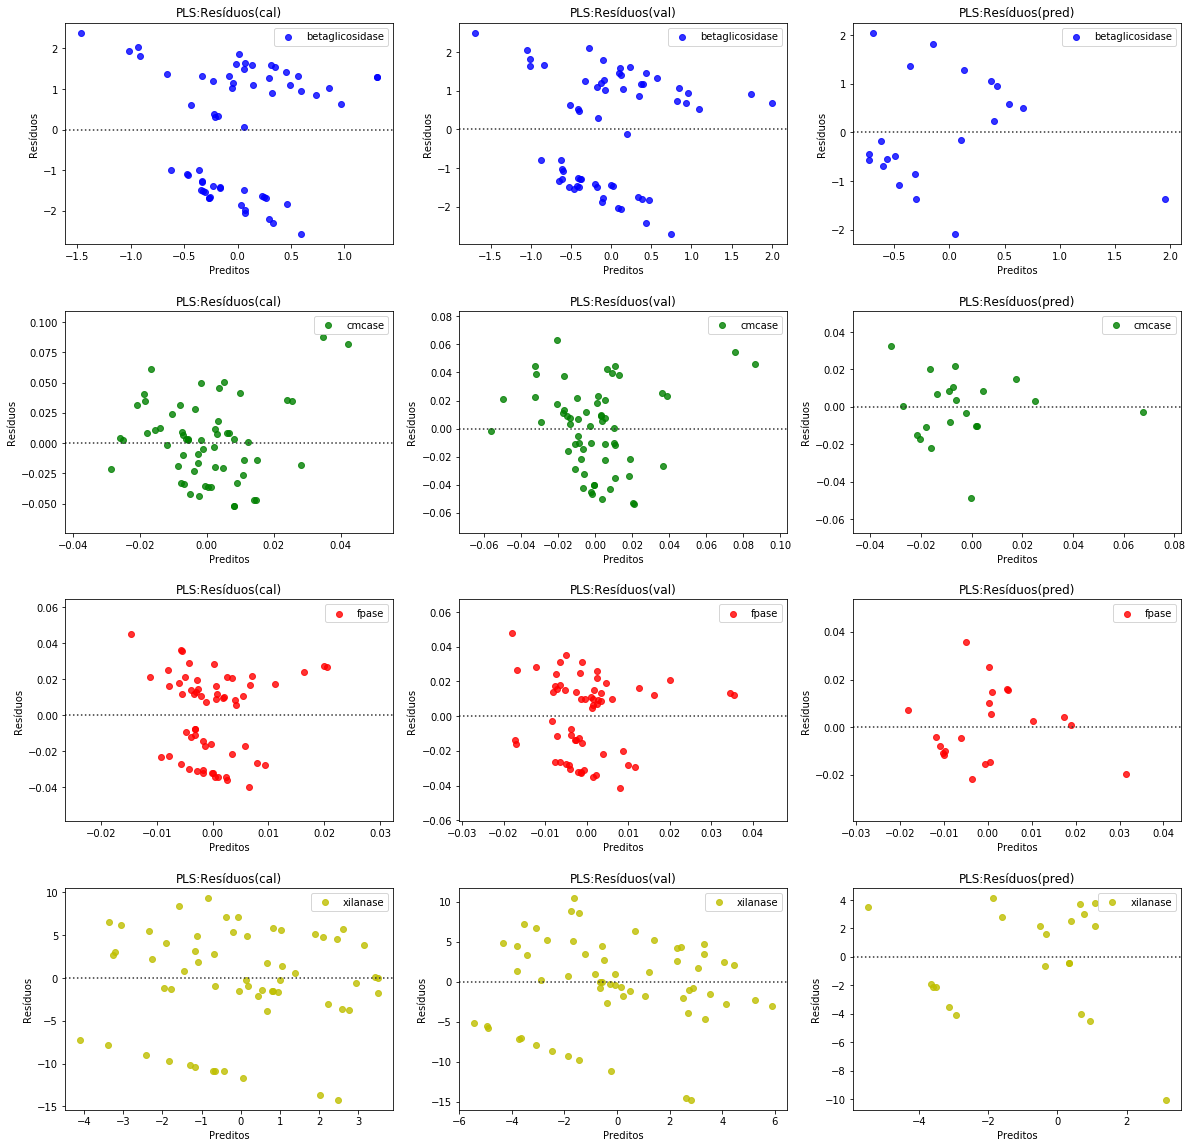

In [273]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

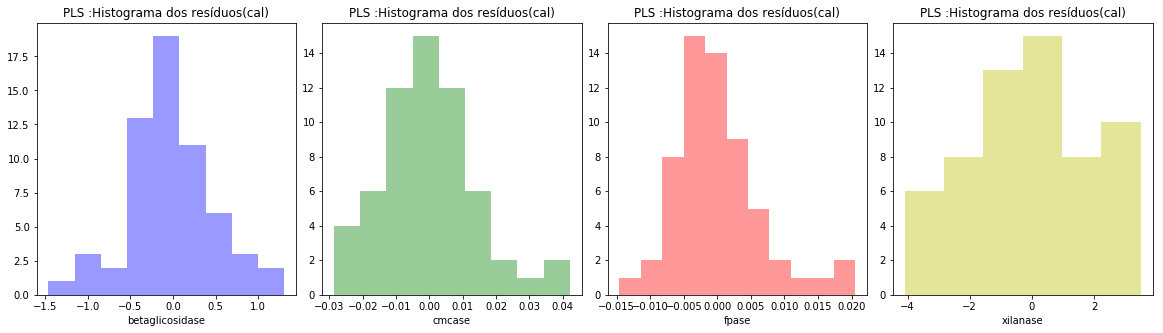

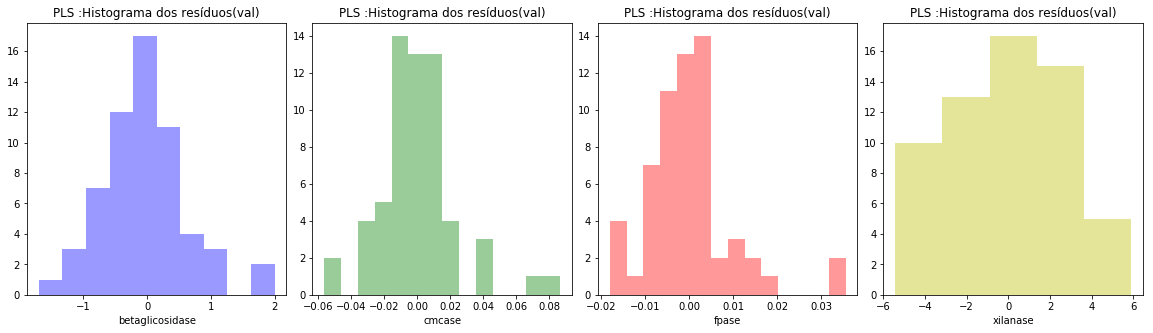

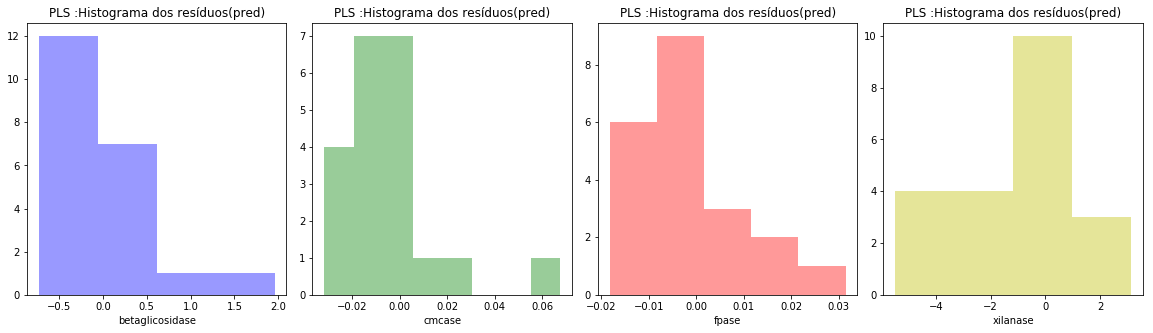

In [274]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

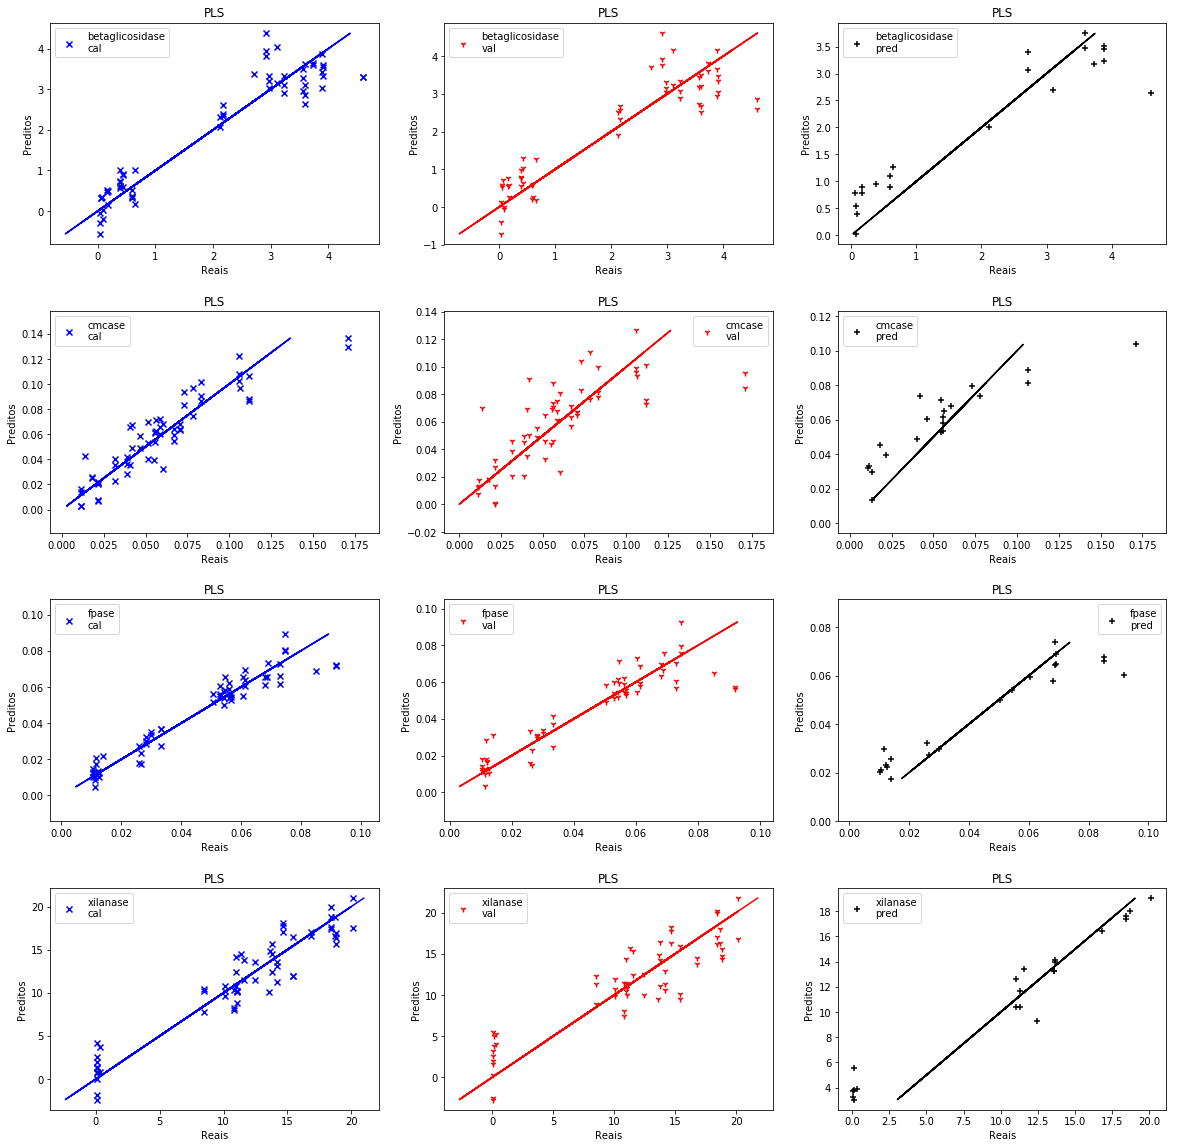

In [275]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

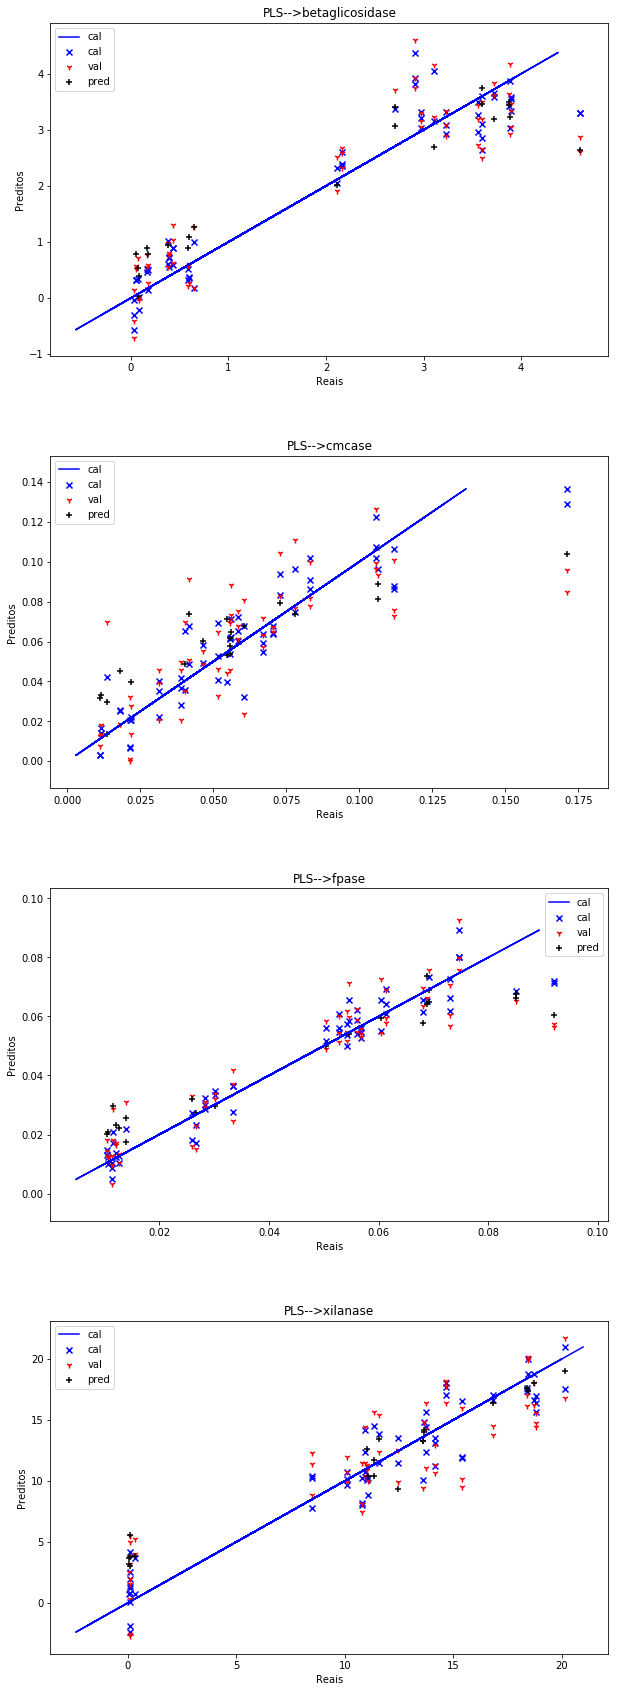

In [276]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### PLS: Gráficos: dados de treino

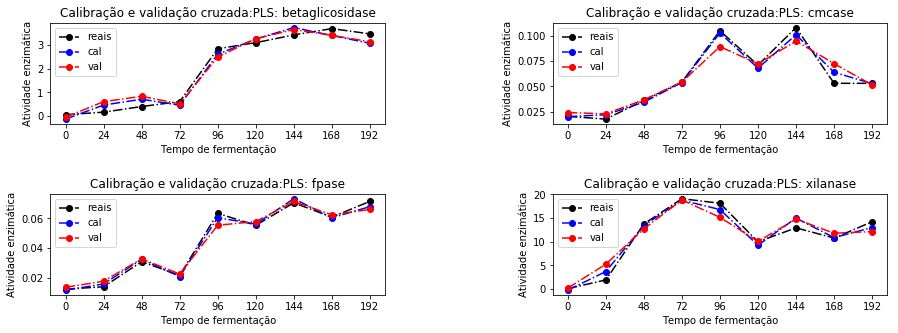

In [277]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### PLS: Gráficos de  teste

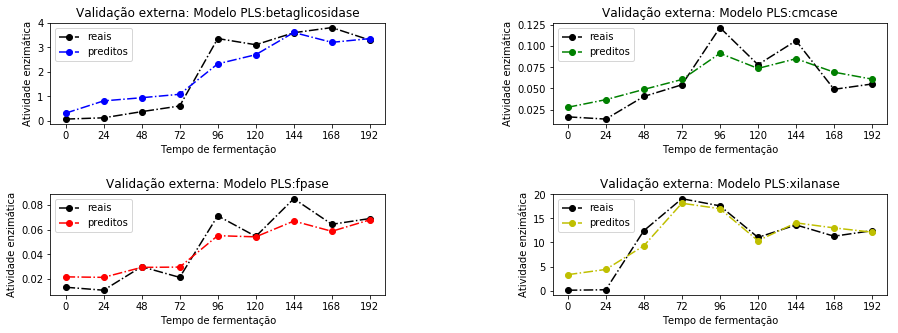

In [278]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## Ridge: Quadrados mínimos lineares

In [279]:
#ridge
#função completa para execução do Ridge:
from sklearn.linear_model import Ridge
def executaRidge(preproc, IC=0):
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)
        
    
    reg = Ridge(alpha = 1.0, solver = 'auto', max_iter=1000)
    #reg = Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000, 
               # normalize=False, random_state=0, solver='auto', tol=0.001)

    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

In [280]:
#PCA_Ridge
from sklearn.linear_model import Ridge
def executaPCA_Ridge(preproc, nPC=4, IC=0):
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)
        
    
    reg = Ridge(alpha = 1.0, solver = 'auto',max_iter=500)
   
    # Roda o PCA e produz uma vaiável reduzida xRed e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC] 
    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

### Ridge: testes

In [281]:
#ridge teste simples
modelo = 'Ridge'
for k in range(12):
    print(preProc[k])
    result = executaRidge(k)
    print('Parâmetros do modelo:',modelo,'\n',result[0])

    resultados=exibeResultados(result)
    
    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

Pré-proc: 0--> Sem pré-processamento
Parâmetros do modelo: Ridge 
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)
cal
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0000  0.0000 -0.0000   -0.0000
MSE            1.8488  0.0013  0.0005   42.6472
R2             0.2867  0.1175  0.2580    0.0403
RER            3.3350  4.4208  3.6151    3.0467
RMSE           1.3597  0.0359  0.0223    6.5305
RPD            1.1841  1.0645  1.1609    1.0208
RPIQ           2.3761  1.2232  2.2001    1.3717
SEP            1.3712  0.0362  0.0225    6.5856 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0002  0.0000 -0.0000   -0.0078
MSE            1.9109  0.0014  0.0005   46.1708
R2             0.2628  0.0705  0.2326   -0.0390
RER            3.2803  4.3076  3.5548    2.9281
RMSE           1.3824  0.0368  0.0227    6.7949
RPD            1.164

cal
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0000 -0.0000  0.0000    0.0000
MSE            2.5317  0.0014  0.0007   44.3512
R2             0.0233  0.0095  0.0210    0.0020
RER            2.8500  4.1729  3.1471    2.9876
RMSE           1.5911  0.0380  0.0257    6.6597
RPD            1.0119  1.0048  1.0107    1.0010
RPIQ           2.0305  1.1546  1.9153    1.3450
SEP            1.6046  0.0384  0.0259    6.7159 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0002 -0.0000 -0.0000   -0.0008
MSE            2.5913  0.0015  0.0007   45.9151
R2             0.0003 -0.0284 -0.0040   -0.0332
RER            2.8170  4.0952  3.1077    2.9363
RMSE           1.6098  0.0388  0.0260    6.7761
RPD            1.0002  0.9861  0.9980    0.9838
RPIQ           2.0070  1.1331  1.8913    1.3219
SEP            1.6233  0.0391  0.0262    6.8332 
-----------------------------------------------------
pred
      betagli

Parâmetros do modelo: Ridge 
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)
cal
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0000 -0.0000  0.0000    0.0000
MSE            1.5435  0.0012  0.0004   40.2486
R2             0.4045  0.1745  0.3727    0.0943
RER            3.6499  4.5710  3.9315    3.1362
RMSE           1.2424  0.0347  0.0205    6.3442
RPD            1.2959  1.1007  1.2626    1.0508
RPIQ           2.6005  1.2648  2.3926    1.4119
SEP            1.2529  0.0350  0.0207    6.3977 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0054  0.0001  0.0000   -0.0055
MSE            1.5946  0.0013  0.0004   45.3442
R2             0.3848  0.1202  0.3506   -0.0204
RER            3.5911  4.4277  3.8641    2.9547
RMSE           1.2628  0.0358  0.0209    6.7338
RPD            1.2750  1.0661  1.2409    0.9900
RPIQ     

In [290]:
#ridge otimizando
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaRidge(preproc=9,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.933, 0.7899, 0.9492, 0.8236] 
semente: b c f x [96, 33, 59, 93]


In [300]:
#ridge teste otimizado
modelo = 'Ridge:'
result = result = executaRidge(preproc=1,IC=96)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: Ridge: 
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [301]:
resultados['cal']

betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0000   0.0000   0.0000    0.0000
MSE            0.1397   0.0002   0.0000    2.7195
R2             0.9464   0.8456   0.9367    0.9330
RER           12.1304  10.6456  12.5074   12.0651
RMSE           0.3738   0.0149   0.0065    1.6491
RPD            4.3185   2.5450   3.9750    3.8628
RPIQ           8.5975   2.4879   6.6355    3.2137
SEP            0.3770   0.0150   0.0065    1.6630

In [302]:
resultados['val']

betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0717 -0.0023 -0.0012   -0.1831
MSE            0.4807  0.0008  0.0002    9.0522
R2             0.8156  0.4742  0.7705    0.7769
RER            6.5759  5.7894  6.6005    6.6252
RMSE           0.6933  0.0275  0.0123    3.0087
RPD            2.3285  1.3791  2.0873    2.1172
RPIQ           4.6357  1.3482  3.4844    1.7614
SEP            0.6954  0.0276  0.0123    3.0285

In [303]:
resultados['pred']

betaglicosidase  cmcase    fpase  xilanase
BIAS          -0.0255 -0.0043  -0.0051   -0.6730
MSE            0.1345  0.0002   0.0001    8.6340
R2             0.9416  0.6973   0.8920    0.8090
RER           10.3177  6.7185  12.3468    6.8390
RMSE           0.3668  0.0152   0.0078    2.9384
RPD            4.1364  1.8176   3.0428    2.2883
RPIQ           7.7542  2.5545   5.7302    1.9400
SEP            0.3749  0.0150   0.0060    2.9309

In [287]:
reg, treino_teste,y_c,y_cv,y_p = result

###  Reais x preditos

In [288]:
#ridge reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5610  0.0586  0.0561   10.0978                 3.5881   
1            0.4280  0.0390  0.0334   13.7624                 0.5481   
2            3.2342  0.0672  0.0543    8.4772                 3.1771   
3            0.0308  0.0213  0.0113    0.0996                 0.1249   
4            3.8994  0.1118  0.0613   10.9512                 3.7519   
5            0.5905  0.0465  0.0267   18.7095                 0.5751   
6            0.1724  0.0112  0.0121    0.0924                 0.1611   
7            0.6010  0.0559  0.0116   20.1368                 0.5630   
8            2.1643  0.0830  0.0529   18.8324                 2.0584   
9            0.0759  0.0136  0.0139    0.0726                 0.0987   
10           3.2342  0.0672  0.0543    8.4772                 3.2756   
11           0.1671  0.0117  0.0104    0.1117                 0.0636   
12           3.5610  0.0586  0.0561   10.0978                 3.5582   
13           2.9123  0.1058  0.0747   14.6813                 2.9890   
14           3.8994  0.1118  0.0613   10.9512                 3.9198   
15           0.6491  0.0605  0.0260   18.4274                 0.6166   
16           0.4280  0.0390  0.0334   13.7624                 0.4082   
17           0.6491  0.0605  0.0260   18.4274                 0.7623   
18           2.9123  0.1058  0.0747   14.6813                 3.0716   
19           0.6491  0.0605  0.0260   18.4274                 0.6488   
20           2.1150  0.0730  0.0505   18.4127                 2.1569   
21           0.6010  0.0559  0.0116   20.1368                 0.5785   
22           0.0308  0.0213  0.0113    0.0996                -0.0142   
23           0.0874  0.0217  0.0127    0.1071                 0.0243   
24           0.0554  0.0181  0.0106    0.3275                 0.0697   
25           0.1724  0.0112  0.0121    0.0924                 0.2656   
26           3.8876  0.0418  0.0605   11.0267                 3.8068   
27           3.8803  0.0557  0.0691   11.3256                 3.8549   
28           2.7110  0.0548  0.0688   13.5829                 2.8608   
29           0.1671  0.0117  0.0104    0.1117                 0.1130   
30           3.1068  0.0781  0.0545   11.0526                 3.1491   
31           2.1643  0.0830  0.0529   18.8324                 2.1813   
32           2.9123  0.1058  0.0747   14.6813                 2.8563   
33           3.7243  0.0561  0.0681   11.5736                 3.6938   
34           3.7243  0.0561  0.0681   11.5736                 3.6235   
35           0.1724  0.0112  0.0121    0.0924                 0.1320   
36           0.1671  0.0117  0.0104    0.1117                 0.3047   
37           3.1068  0.0781  0.0545   11.0526                 3.1119   
38           0.4280  0.0390  0.0334   13.7624                 0.3843   
39           0.3828  0.0405  0.0301   12.4461                 0.5113   
40           3.5967  0.1065  0.0850   13.6476                 3.5080   
41           3.5974  0.0516  0.0731   15.3973                 3.4035   
42           3.8876  0.0418  0.0605   11.0267                 3.9966   
43           0.0874  0.0217  0.0127    0.1071                 0.0493   
44           0.3828  0.0405  0.0301   12.4461                 0.3660   
45           0.3900  0.0315  0.0283   14.1777                 0.4816   
46           3.2342  0.0672  0.0543    8.4772                 3.2270   
47           2.7110  0.0548  0.0688   13.5829                 2.8335   
48           3.1068  0.0781  0.0545   11.0526                 3.1146   
49           2.9774  0.0704  0.0567   10.8002                 2.9776   
50           2.7110  0.0548  0.0688   13.5829                 2.7560   
51           0.6010  0.0559  0.0116   20.1368                 0.5538   
52           3.5967  0.1065  0.0850   13.6476                 3.4913   
53           0.5905  0.0465  0.0267   18.7095                 0.6265   
54           3.8876  0.0418  0.0605   11.026

In [1062]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.2342  0.0672  0.0543    8.4772                 2.7566   
1            0.3900  0.0315  0.0283   14.1777                 0.5290   
2            2.9123  0.1058  0.0747   14.6813                 3.7219   
3            0.0554  0.0181  0.0106    0.3275                 0.8852   
4            2.1150  0.0730  0.0505   18.4127                 3.6636   
5            3.8994  0.1118  0.0613   10.9512                 3.2920   
6            3.2342  0.0672  0.0543    8.4772                 2.8189   
7            3.5610  0.0586  0.0561   10.0978                 4.0764   
8            3.5610  0.0586  0.0561   10.0978                 4.0725   
9            0.0308  0.0213  0.0113    0.0996                -0.3955   
10           2.9774  0.0704  0.0567   10.8002                 3.0278   
11           0.1671  0.0117  0.0104    0.1117                -0.8059   
12           0.5905  0.0465  0.0267   18.7095                 0.7814   
13           3.1068  0.0781  0.0545   11.0526                 2.2134   
14           3.8994  0.1118  0.0613   10.9512                 3.7650   
15           3.5974  0.0516  0.0731   15.3973                 3.3843   
16           3.8803  0.0557  0.0691   11.3256                 5.1440   
17           0.3900  0.0315  0.0283   14.1777                 1.5222   
18           3.1068  0.0781  0.0545   11.0526                 3.2246   
19           2.7110  0.0548  0.0688   13.5829                 2.7880   
20           3.7243  0.0561  0.0681   11.5736                 3.4571   
21           0.0874  0.0217  0.0127    0.1071                -0.4743   
22           0.0759  0.0136  0.0139    0.0726                -0.4536   
23           3.8803  0.0557  0.0691   11.3256                 1.9551   
24           3.1068  0.0781  0.0545   11.0526                 3.5281   
25           0.6491  0.0605  0.0260   18.4274                 1.0689   
26           2.1150  0.0730  0.0505   18.4127                 2.9760   
27           0.5905  0.0465  0.0267   18.7095                 0.2367   
28           3.5967  0.1065  0.0850   13.6476                 3.8621   
29           0.4280  0.0390  0.0334   13.7624                 1.7822   
30           0.0554  0.0181  0.0106    0.3275                 1.1182   
31           3.5967  0.1065  0.0850   13.6476                 3.5195   
32           2.9123  0.1058  0.0747   14.6813                 3.0683   
33           3.5974  0.0516  0.0731   15.3973                 3.0922   
34           0.1671  0.0117  0.0104    0.1117                 0.3451   
35           3.8876  0.0418  0.0605   11.0267                 3.4058   
36           0.6491  0.0605  0.0260   18.4274                 0.6689   
37           0.3828  0.0405  0.0301   12.4461                 0.9434   
38           3.5967  0.1065  0.0850   13.6476                 2.8730   
39           2.1150  0.0730  0.0505   18.4127                 2.4629   
40           0.0759  0.0136  0.0139    0.0726                 0.6554   
41           0.1671  0.0117  0.0104    0.1117                 0.5818   
42           0.4280  0.0390  0.0334   13.7624                 1.2096   
43           4.6037  0.1713  0.0919   16.8115                 3.3256   
44           3.5610  0.0586  0.0561   10.0978                 4.6518   
45           0.6010  0.0559  0.0116   20.1368                 0.4559   
46           0.1724  0.0112  0.0121    0.0924                 0.8868   
47           0.3828  0.0405  0.0301   12.4461                 0.3780   
48           3.8876  0.0418  0.0605   11.0267                 3.8076   
49           4.6037  0.1713  0.0919   16.8115                 2.3752   
50           0.1724  0.0112  0.0121    0.0924                 0.7466   
51           0.5905  0.0465  0.0267   18.7095                -0.5143   
52           0.0759  0.0136  0.0139    0.0726                 0.1369   
53           0.0554  0.0181  0.0106    0.3275                 0.3721   
54           0.6010  0.0559  0.0116   20.136

In [1063]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5974  0.0516  0.0731   15.3973                 3.9585   
1            3.8803  0.0557  0.0691   11.3256                 3.7439   
2            3.7243  0.0561  0.0681   11.5736                 3.8461   
3            2.1643  0.0830  0.0529   18.8324                 3.9182   
4            0.6491  0.0605  0.0260   18.4274                 0.2357   
5            0.3900  0.0315  0.0283   14.1777                 1.0511   
6            2.1643  0.0830  0.0529   18.8324                 3.0518   
7            0.0874  0.0217  0.0127    0.1071                 0.6861   
8            2.9123  0.1058  0.0747   14.6813                 3.2884   
9            0.0308  0.0213  0.0113    0.0996                -0.8406   
10           0.3828  0.0405  0.0301   12.4461                 1.5538   
11           0.4280  0.0390  0.0334   13.7624                 0.9922   
12           0.0308  0.0213  0.0113    0.0996                 0.1783   
13           0.1724  0.0112  0.0121    0.0924                 0.1588   
14           3.7243  0.0561  0.0681   11.5736                 4.9058   
15           0.0874  0.0217  0.0127    0.1071                 0.6000   
16           2.9774  0.0704  0.0567   10.8002                 2.5004   
17           2.1643  0.0830  0.0529   18.8324                 2.3034   
18           2.7110  0.0548  0.0688   13.5829                 4.0600   
19           2.7110  0.0548  0.0688   13.5829                 2.7219   
20           0.6010  0.0559  0.0116   20.1368                 0.9115   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0823       0.0809         15.6671  
1         0.0581       0.0611         10.6501  
2         0.0733       0.0748         12.5182  
3         0.1324       0.0732         13.5936  
4         0.0320       0.0175         15.3187  
5         0.0563       0.0357         10.1028  
6         0.0938       0.0614         14.3134  
7         0.0356       0.0105          1.1984  
8         0.1211       0.0817         18.4668  
9        -0.0294      -0.0094         -1.2611  
10        0.0949       0.0472         11.1344  
11        0.0605       0.0457         13.3416  
12        0.0334       0.0198          6.5912  
13        0.0106       0.0115          4.2335  
14        0.1278       0.0859         13.8037  
15        0.0044       0.0095          2.9197  
16        0.0562       0.0432          7.7705  
17        0.0633       0.0407         13.6693  
18        0.0821       0.0807         12.8034  
19        0.0115       0.0532         12.0130  
20        0.0573       0.0266         17.5853

###  Ridge: Gráficos de resíduos - histograma - reais x preditos

In [304]:
#título para os gráficos
modelo = 'Ridge'

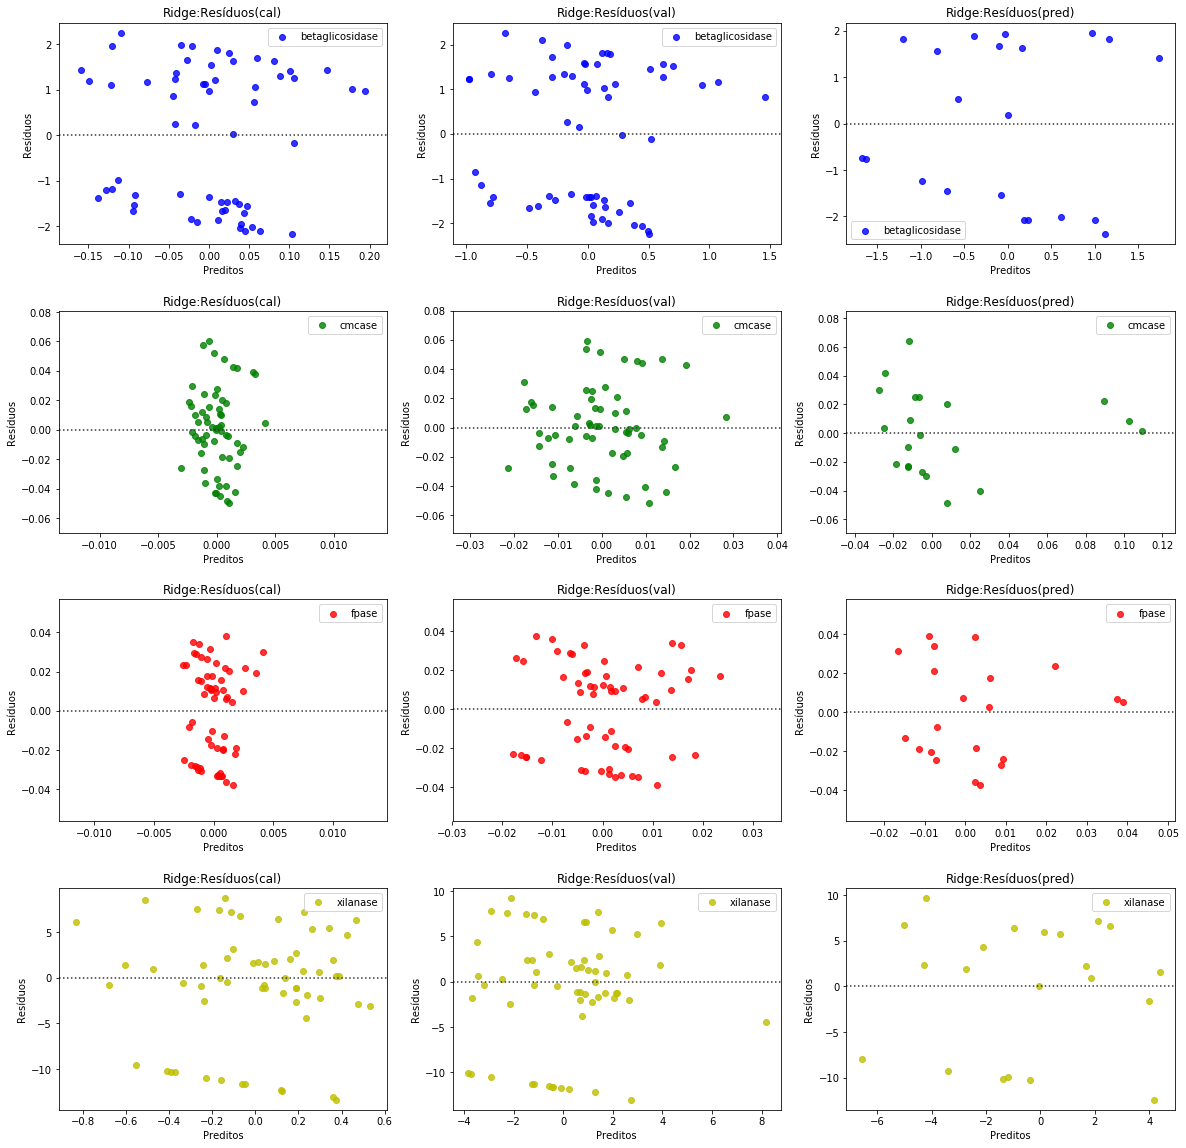

In [305]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

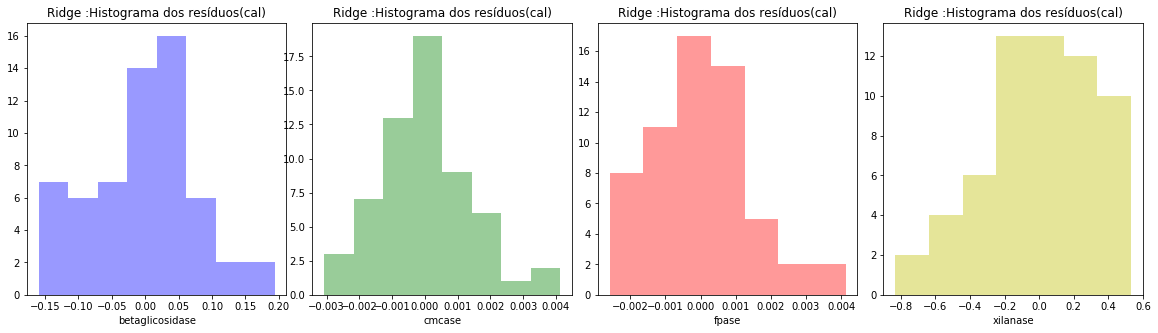

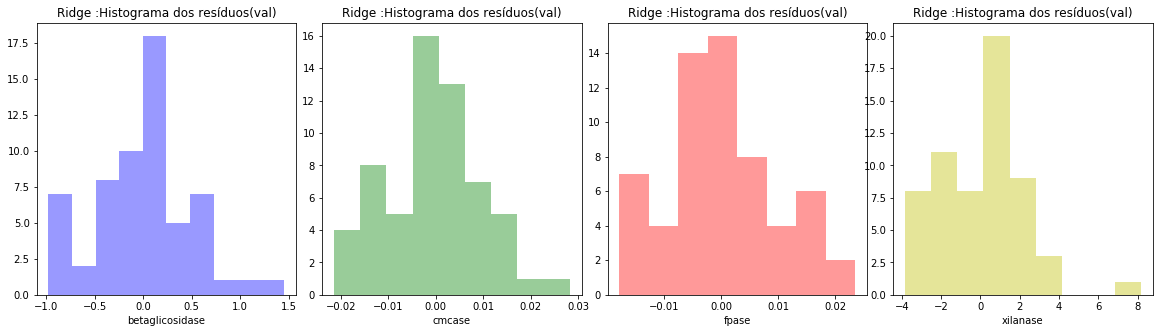

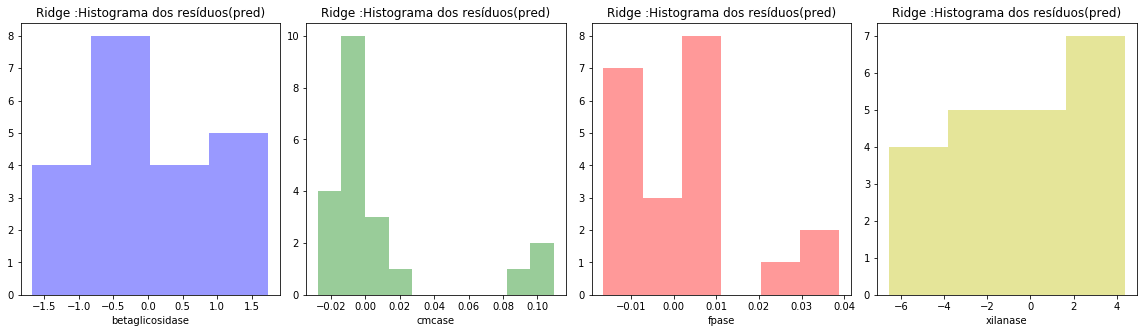

In [306]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

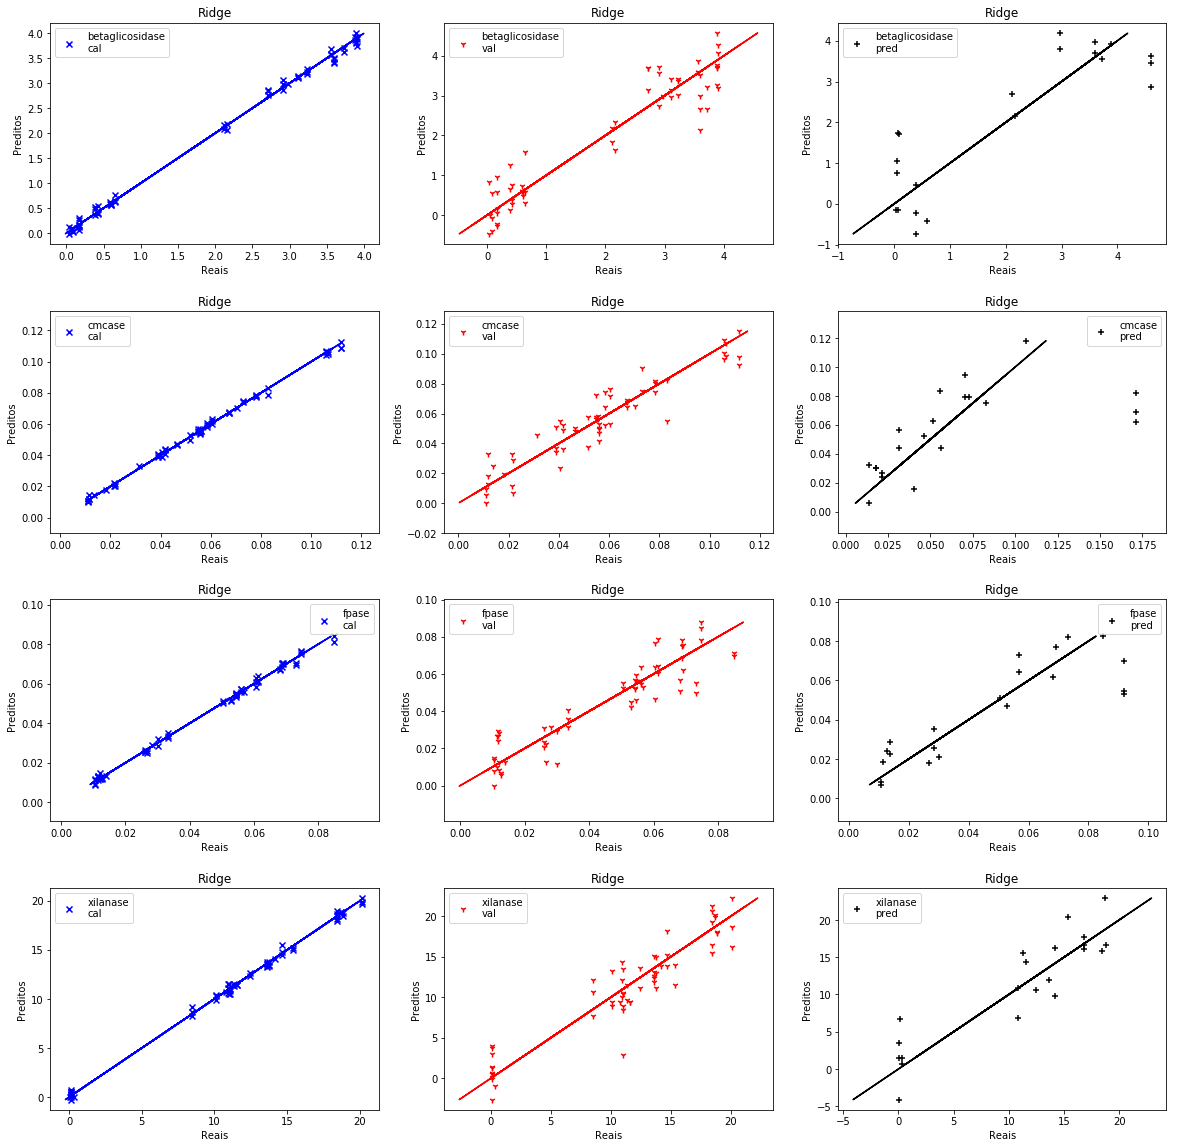

In [308]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

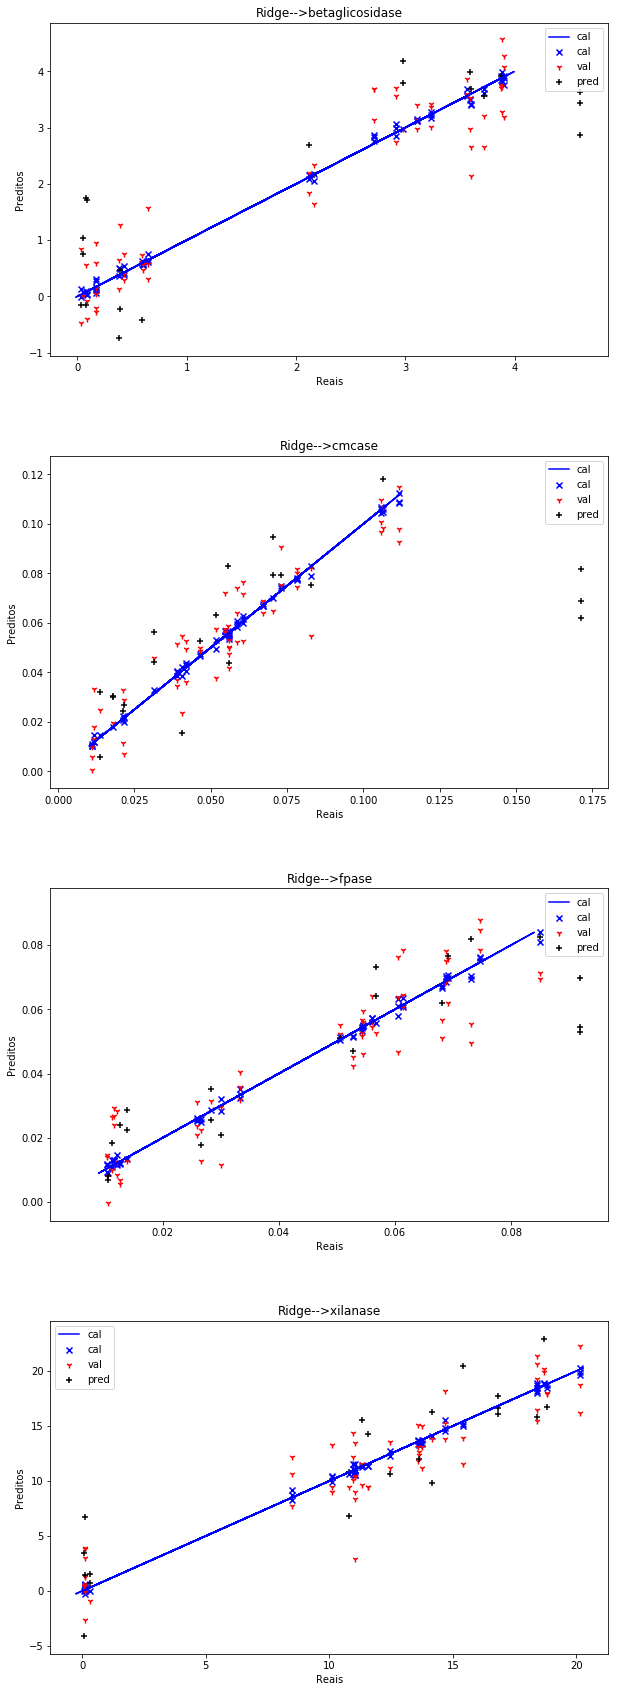

In [309]:
#graico de reais x preditos
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### Ridge: Gráficos: dados de treino

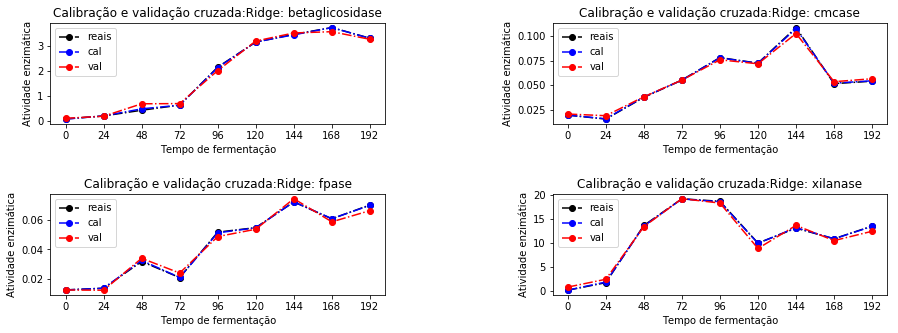

In [310]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### Ridge: Gráficos de  teste

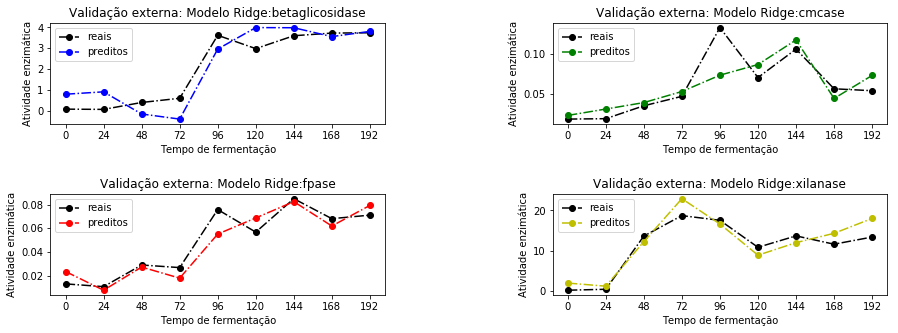

In [311]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## Kernel Ridge: Quadrados mínimos lineares com kernel

In [417]:
#kernelRidge
def executaKernelRidge(preproc=1, teste=1, k='linear', IC=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False, IC)
        

   
    if teste == 1:
        reg = GridSearchCV(estimator=KernelRidge(), cv=5,
                  param_grid={"kernel":['rbf','linear','poly'],
                              "alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": [.1,.2,0,1,2,3,4,5,10],
                              "degree":[1,2,3]
                            })
    elif teste==2:
        #kernel otimizado
        reg = KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear')
    else:
         reg = KernelRidge(kernel = k,alpha = 1.0)
    
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

### Kernel Ridge: testes

In [418]:
#Kernelridge teste para um tipo de pré-processamento
modelo = 'Kernel Ridge'
result = executaKernelRidge(preproc=1,teste=0,k='rbf')
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
    
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: Kernel Ridge 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)
cal
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0746  0.0026  0.0018    0.5125
MSE            0.3211  0.0005  0.0001   10.0646
R2             0.8761  0.6869  0.8493    0.7735
RER            8.0723  7.4792  8.1520    6.3550
RMSE           0.5667  0.0214  0.0101    3.1725
RPD            2.8411  1.7871  2.5759    2.1013
RPIQ           5.7012  2.0536  4.8815    2.8235
SEP            0.5665  0.0214  0.0100    3.1572 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.1062  0.0037  0.0026    0.7122
MSE            0.4064  0.0006  0.0001   12.8413
R2             0.8432  0.5871  0.8040    0.7110
RER            7.2142  6.5384  7.2158    5.6652
RMSE           0.6375  0.0246  0.0115    3.5835
RPD            2.5256  1.5562  2.2590    1.8603
RPIQ           5.0680  1.7882  4.2809 

In [419]:
#Kernelridge teste pré-proc
modelo = 'Kernel Ridge'
for k in range(12):
    print(preProc[k])
    result = executaKernelRidge(k, teste=0, k='poly')
    print('Parâmetros do modelo:',modelo,'\n',result[0])

    resultados=exibeResultados(result)
    
    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

Pré-proc: 0--> Sem pré-processamento
Parâmetros do modelo: Kernel Ridge 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='poly',
      kernel_params=None)
cal
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0112  0.0003  0.0003    0.0561
MSE            2.5384  0.0014  0.0007   44.2665
R2             0.0207  0.0084  0.0182    0.0039
RER            2.8463  4.1707  3.1428    2.9905
RMSE           1.5932  0.0381  0.0257    6.6533
RPD            1.0105  1.0042  1.0092    1.0019
RPIQ           2.0278  1.1539  1.9125    1.3463
SEP            1.6066  0.0384  0.0259    6.7092 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0122  0.0004  0.0003    0.0622
MSE            2.5973  0.0015  0.0007   45.8021
R2            -0.0020 -0.0290 -0.0066   -0.0307
RER            2.8138  4.0941  3.1039    2.9400
RMSE           1.6116  0.0388  0.0260    6.7677
RPD            0.9990  0.9858  0.9967    0.9850


cal
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0315  0.0009  0.0007    0.1738
MSE            2.5881  0.0015  0.0007   44.4653
R2             0.0016  0.0001  0.0009   -0.0006
RER            2.8192  4.1544  3.1165    2.9848
RMSE           1.6088  0.0382  0.0259    6.6682
RPD            1.0008  1.0000  1.0004    0.9997
RPIQ           2.0082  1.1491  1.8959    1.3433
SEP            1.6220  0.0385  0.0261    6.7222 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0349  0.0010  0.0008    0.1927
MSE            2.6426  0.0015  0.0007   45.8995
R2            -0.0195 -0.0362 -0.0224   -0.0329
RER            2.7901  4.0813  3.0811    2.9379
RMSE           1.6256  0.0389  0.0262    6.7749
RPD            0.9904  0.9824  0.9890    0.9840
RPIQ           1.9874  1.1289  1.8742    1.3222
SEP            1.6390  0.0392  0.0264    6.8293 
-----------------------------------------------------
pred
      betagli

In [446]:
'''#kernel ridge teste otimização automática
modelo = 'Kernel Ridge:'
result = result = executaKernelRidge(preproc=8, teste=1)
print('Parâmetros do modelo:',modelo,'\n',result[0])'''


"#kernel ridge teste otimização automática\nmodelo = 'Kernel Ridge:'\nresult = result = executaKernelRidge(preproc=8, teste=1)\nprint('Parâmetros do modelo:',modelo,'\n',result[0])"

In [442]:
#Kernel ridge otimizando
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaKernelRidge(preproc=8,k='poly',teste=0,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['val'].loc[resultados['val'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.9437, 0.8271, 0.9216, 0.8986] 
semente: b c f x [24, 84, 24, 76]


In [447]:
#kernel ridge teste otimizado
modelo = 'Kernel Ridge:'
result = result = executaKernelRidge(preproc=8,k='poly', teste=0, IC=56)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: Kernel Ridge: 
 KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='poly',
      kernel_params=None)


In [448]:
resultados['cal']

betaglicosidase   cmcase    fpase  xilanase
BIAS           0.0245   0.0007   0.0006    0.1413
MSE            0.0825   0.0001   0.0000    1.4646
R2             0.9690   0.9000   0.9597    0.9667
RER           15.8429  13.1642  15.3841   16.5537
RMSE           0.2873   0.0121   0.0053    1.2102
RPD            5.6778   3.1623   4.9823    5.4793
RPIQ          11.1878   3.4326   9.5206    5.7181
SEP            0.2886   0.0122   0.0053    1.2121

In [449]:
resultados['val']

betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0310  0.0006  0.0010    0.2688
MSE            0.2967  0.0005  0.0001    5.4717
R2             0.8885  0.6565  0.8451    0.8756
RER            8.3391  7.0926  7.8231    8.5625
RMSE           0.5447  0.0224  0.0104    2.3392
RPD            2.9946  1.7061  2.5405    2.8348
RPIQ           5.9008  1.8520  4.8545    2.9584
SEP            0.5484  0.0226  0.0104    2.3433

In [450]:
resultados['pred']

betaglicosidase  cmcase    fpase  xilanase
BIAS           0.2648 -0.0009   0.0047    0.1868
MSE            0.2019  0.0001   0.0000    2.6085
R2             0.9035  0.8348   0.9225    0.9272
RER           10.3998  8.7855  16.6667   11.4120
RMSE           0.4493  0.0109   0.0060    1.6151
RPD            3.2192  2.4601   3.5921    3.7072
RPIQ           5.8841  2.6145   6.8680    2.0912
SEP            0.3720  0.0112   0.0038    1.6439

In [451]:
reg, treino_teste,y_c,y_cv,y_p = result

### Kernel Ridge Reais x preditos

In [452]:
#kernelridge reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.3900  0.0315  0.0283   14.1777                 0.5021   
1            3.2342  0.0672  0.0543    8.4772                 2.7688   
2            0.4280  0.0390  0.0334   13.7624                 0.6112   
3            0.0874  0.0217  0.0127    0.1071                 0.0625   
4            3.8803  0.0557  0.0691   11.3256                 3.7916   
5            0.0308  0.0213  0.0113    0.0996                 0.0209   
6            2.9123  0.1058  0.0747   14.6813                 3.0441   
7            3.8803  0.0557  0.0691   11.3256                 3.4825   
8            3.5967  0.1065  0.0850   13.6476                 3.4087   
9            3.5610  0.0586  0.0561   10.0978                 3.6376   
10           0.3828  0.0405  0.0301   12.4461                 0.7303   
11           3.8994  0.1118  0.0613   10.9512                 3.7574   
12           3.5974  0.0516  0.0731   15.3973                 3.1709   
13           3.5967  0.1065  0.0850   13.6476                 3.3682   
14           2.9774  0.0704  0.0567   10.8002                 2.7724   
15           2.1150  0.0730  0.0505   18.4127                 2.4117   
16           3.1068  0.0781  0.0545   11.0526                 3.0945   
17           3.7243  0.0561  0.0681   11.5736                 3.8878   
18           0.1724  0.0112  0.0121    0.0924                 0.1687   
19           3.1068  0.0781  0.0545   11.0526                 3.3321   
20           2.9123  0.1058  0.0747   14.6813                 2.7780   
21           2.7110  0.0548  0.0688   13.5829                 2.9889   
22           4.6037  0.1713  0.0919   16.8115                 3.6685   
23           0.6010  0.0559  0.0116   20.1368                 0.5797   
24           0.6491  0.0605  0.0260   18.4274                 0.7064   
25           0.0759  0.0136  0.0139    0.0726                 0.1178   
26           0.6010  0.0559  0.0116   20.1368                 0.5716   
27           2.1150  0.0730  0.0505   18.4127                 1.9887   
28           4.6037  0.1713  0.0919   16.8115                 3.5363   
29           0.3828  0.0405  0.0301   12.4461                 0.5992   
30           0.1671  0.0117  0.0104    0.1117                 0.0477   
31           0.1724  0.0112  0.0121    0.0924                 0.3475   
32           0.0874  0.0217  0.0127    0.1071                 0.0905   
33           3.8876  0.0418  0.0605   11.0267                 3.8359   
34           0.0874  0.0217  0.0127    0.1071                 0.0783   
35           2.1643  0.0830  0.0529   18.8324                 2.4876   
36           0.0308  0.0213  0.0113    0.0996                 0.0464   
37           0.3828  0.0405  0.0301   12.4461                 0.3004   
38           0.4280  0.0390  0.0334   13.7624                 0.6030   
39           3.5610  0.0586  0.0561   10.0978                 3.8253   
40           3.5974  0.0516  0.0731   15.3973                 3.2185   
41           3.5974  0.0516  0.0731   15.3973                 3.2735   
42           3.2342  0.0672  0.0543    8.4772                 3.0616   
43           4.6037  0.1713  0.0919   16.8115                 3.8892   
44           0.6491  0.0605  0.0260   18.4274                 0.6693   
45           0.6010  0.0559  0.0116   20.1368                 0.6538   
46           0.0554  0.0181  0.0106    0.3275                 0.1590   
47           0.5905  0.0465  0.0267   18.7095                 0.5460   
48           0.0554  0.0181  0.0106    0.3275                 0.2499   
49           2.1150  0.0730  0.0505   18.4127                 2.3113   
50           3.8876  0.0418  0.0605   11.0267                 4.2246   
51           0.1671  0.0117  0.0104    0.1117                 0.3934   
52           0.4280  0.0390  0.0334   13.7624                 0.4934   
53           3.8994  0.1118  0.0613   10.9512                 3.5127   
54           3.5967  0.1065  0.0850   13.647

In [453]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.3900  0.0315  0.0283   14.1777                 0.5538   
1            3.2342  0.0672  0.0543    8.4772                 2.4443   
2            0.4280  0.0390  0.0334   13.7624                 0.7470   
3            0.0874  0.0217  0.0127    0.1071                -0.0693   
4            3.8803  0.0557  0.0691   11.3256                 3.6697   
5            0.0308  0.0213  0.0113    0.0996                -0.0692   
6            2.9123  0.1058  0.0747   14.6813                 3.2937   
7            3.8803  0.0557  0.0691   11.3256                 2.9865   
8            3.5967  0.1065  0.0850   13.6476                 3.2192   
9            3.5610  0.0586  0.0561   10.0978                 3.7176   
10           0.3828  0.0405  0.0301   12.4461                 1.0146   
11           3.8994  0.1118  0.0613   10.9512                 3.5715   
12           3.5974  0.0516  0.0731   15.3973                 2.8356   
13           3.5967  0.1065  0.0850   13.6476                 3.2139   
14           2.9774  0.0704  0.0567   10.8002                 2.6279   
15           2.1150  0.0730  0.0505   18.4127                 2.5276   
16           3.1068  0.0781  0.0545   11.0526                 3.0130   
17           3.7243  0.0561  0.0681   11.5736                 4.1159   
18           0.1724  0.0112  0.0121    0.0924                 0.1156   
19           3.1068  0.0781  0.0545   11.0526                 3.7718   
20           2.9123  0.1058  0.0747   14.6813                 2.5723   
21           2.7110  0.0548  0.0688   13.5829                 3.3072   
22           4.6037  0.1713  0.0919   16.8115                 3.0169   
23           0.6010  0.0559  0.0116   20.1368                 0.5093   
24           0.6491  0.0605  0.0260   18.4274                 0.9635   
25           0.0759  0.0136  0.0139    0.0726                 0.4261   
26           0.6010  0.0559  0.0116   20.1368                 0.3836   
27           2.1150  0.0730  0.0505   18.4127                 1.8283   
28           4.6037  0.1713  0.0919   16.8115                 2.7383   
29           0.3828  0.0405  0.0301   12.4461                 0.7808   
30           0.1671  0.0117  0.0104    0.1117                 0.0315   
31           0.1724  0.0112  0.0121    0.0924                 0.4980   
32           0.0874  0.0217  0.0127    0.1071                 0.1216   
33           3.8876  0.0418  0.0605   11.0267                 3.8165   
34           0.0874  0.0217  0.0127    0.1071                 0.0397   
35           2.1643  0.0830  0.0529   18.8324                 2.6498   
36           0.0308  0.0213  0.0113    0.0996                 0.1222   
37           0.3828  0.0405  0.0301   12.4461                 0.2583   
38           0.4280  0.0390  0.0334   13.7624                 0.7028   
39           3.5610  0.0586  0.0561   10.0978                 4.2666   
40           3.5974  0.0516  0.0731   15.3973                 2.7693   
41           3.5974  0.0516  0.0731   15.3973                 2.7100   
42           3.2342  0.0672  0.0543    8.4772                 2.9982   
43           4.6037  0.1713  0.0919   16.8115                 3.3017   
44           0.6491  0.0605  0.0260   18.4274                 0.7775   
45           0.6010  0.0559  0.0116   20.1368                 0.8896   
46           0.0554  0.0181  0.0106    0.3275                 0.1905   
47           0.5905  0.0465  0.0267   18.7095                 0.3623   
48           0.0554  0.0181  0.0106    0.3275                 0.4497   
49           2.1150  0.0730  0.0505   18.4127                 2.4416   
50           3.8876  0.0418  0.0605   11.0267                 4.6758   
51           0.1671  0.0117  0.0104    0.1117                 0.5762   
52           0.4280  0.0390  0.0334   13.7624                 0.5005   
53           3.8994  0.1118  0.0613   10.9512                 3.3615   
54           3.5967  0.1065  0.0850   13.647

In [454]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0308  0.0213  0.0113    0.0996                -0.1972   
1            3.7243  0.0561  0.0681   11.5736                 2.8025   
2            3.8803  0.0557  0.0691   11.3256                 3.6194   
3            2.1643  0.0830  0.0529   18.8324                 2.4051   
4            2.7110  0.0548  0.0688   13.5829                 2.9089   
5            3.8876  0.0418  0.0605   11.0267                 3.0409   
6            0.5905  0.0465  0.0267   18.7095                 0.4276   
7            0.0759  0.0136  0.0139    0.0726                -0.0297   
8            0.3900  0.0315  0.0283   14.1777                 0.2595   
9            2.9123  0.1058  0.0747   14.6813                 2.8832   
10           3.8994  0.1118  0.0613   10.9512                 2.9944   
11           0.6491  0.0605  0.0260   18.4274                 0.7428   
12           0.0759  0.0136  0.0139    0.0726                -0.0023   
13           3.2342  0.0672  0.0543    8.4772                 2.6033   
14           3.7243  0.0561  0.0681   11.5736                 3.1701   
15           2.1643  0.0830  0.0529   18.8324                 2.0472   
16           2.9774  0.0704  0.0567   10.8002                 2.5775   
17           0.0554  0.0181  0.0106    0.3275                 0.0659   
18           2.9774  0.0704  0.0567   10.8002                 2.5788   
19           3.1068  0.0781  0.0545   11.0526                 2.4539   
20           2.7110  0.0548  0.0688   13.5829                 3.0309   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0192       0.0083         -0.3109  
1         0.0581       0.0533         10.3151  
2         0.0582       0.0612         10.6024  
3         0.0934       0.0559         15.9930  
4         0.0562       0.0619         11.4738  
5         0.0614       0.0527         11.1532  
6         0.0562       0.0185         18.0793  
7         0.0152       0.0091          0.4958  
8         0.0251       0.0248         13.3550  
9         0.0913       0.0716         15.3628  
10        0.0835       0.0571         12.3306  
11        0.0567       0.0215         19.9909  
12        0.0173       0.0085          1.8523  
13        0.0699       0.0532         11.1732  
14        0.0815       0.0687         12.7851  
15        0.0854       0.0483         14.4511  
16        0.0690       0.0475          9.5789  
17        0.0202       0.0094          0.6866  
18        0.0742       0.0556         11.4286  
19        0.0658       0.0495         11.4676  
20        0.0548       0.0625         12.7919

## Kernel Ridge: Gráficos de resíduos - histograma - reais x preditos

In [455]:
#título para os gráficos
modelo = 'Kernel Ridge'

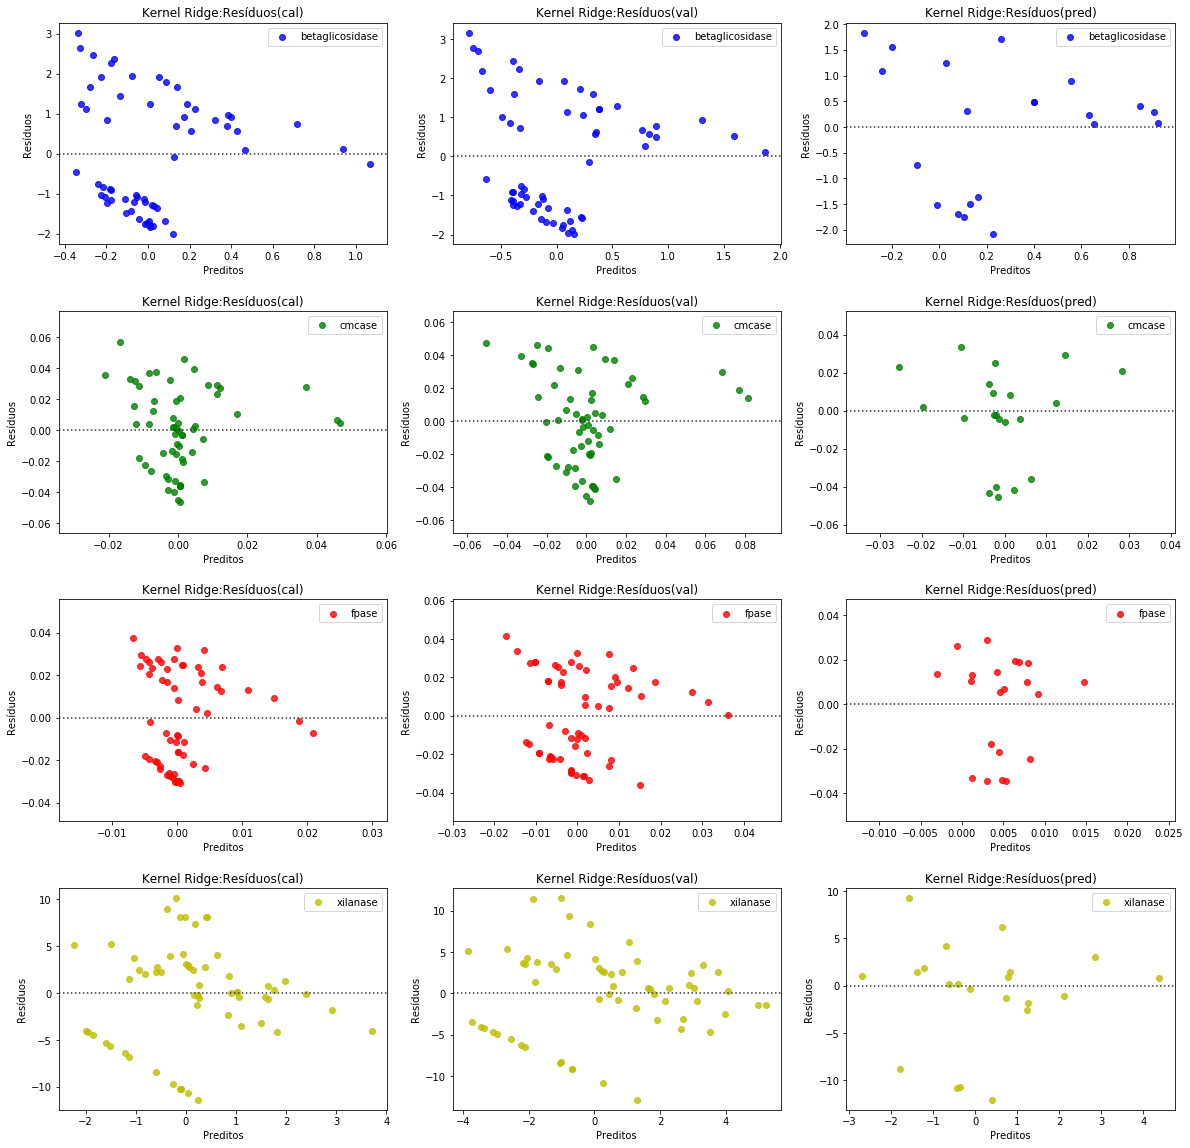

In [456]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

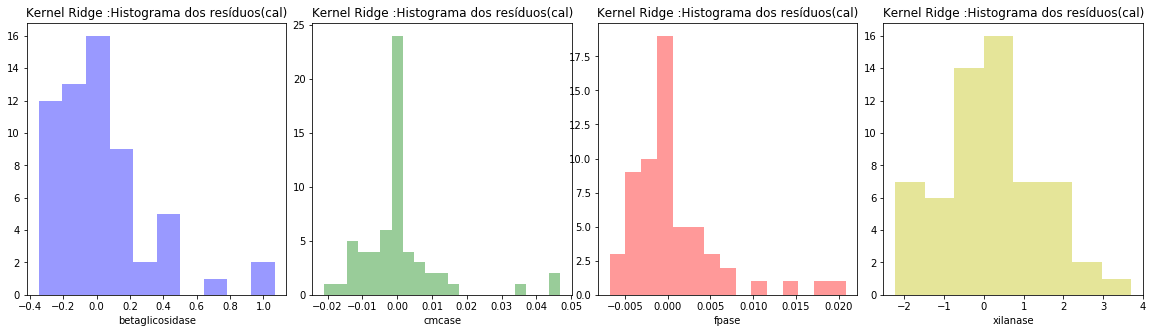

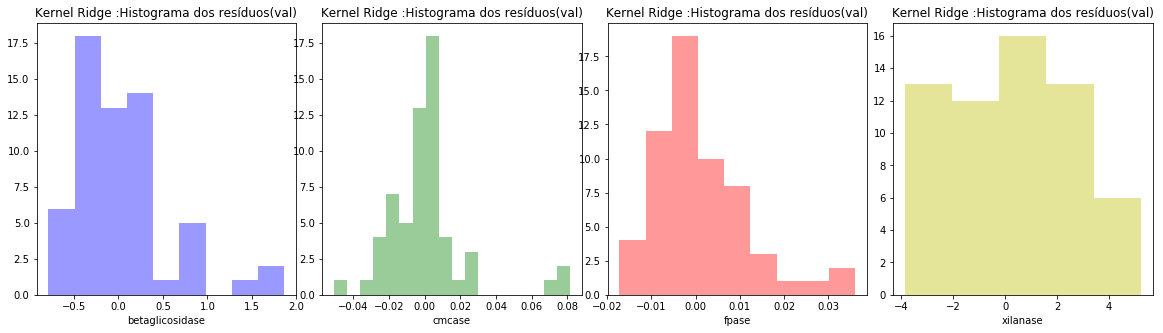

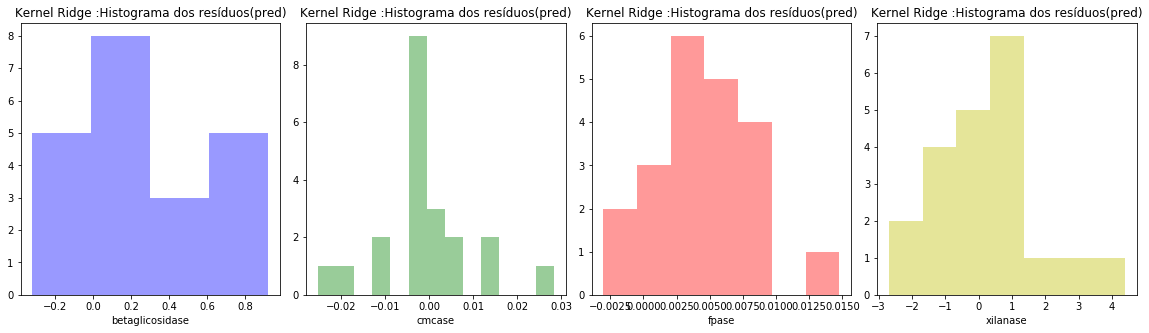

In [457]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

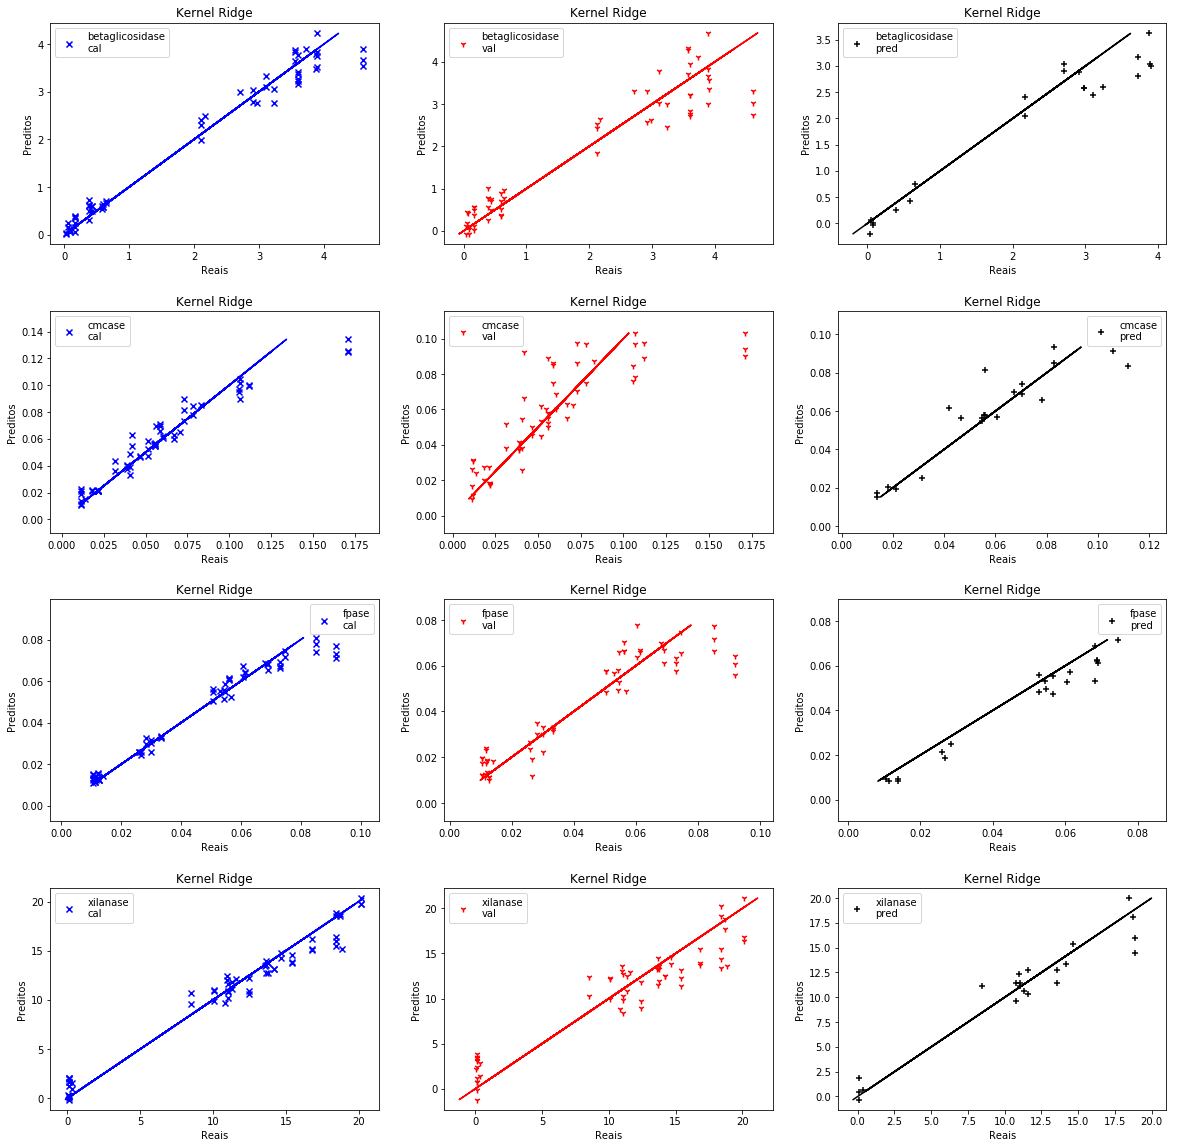

In [458]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

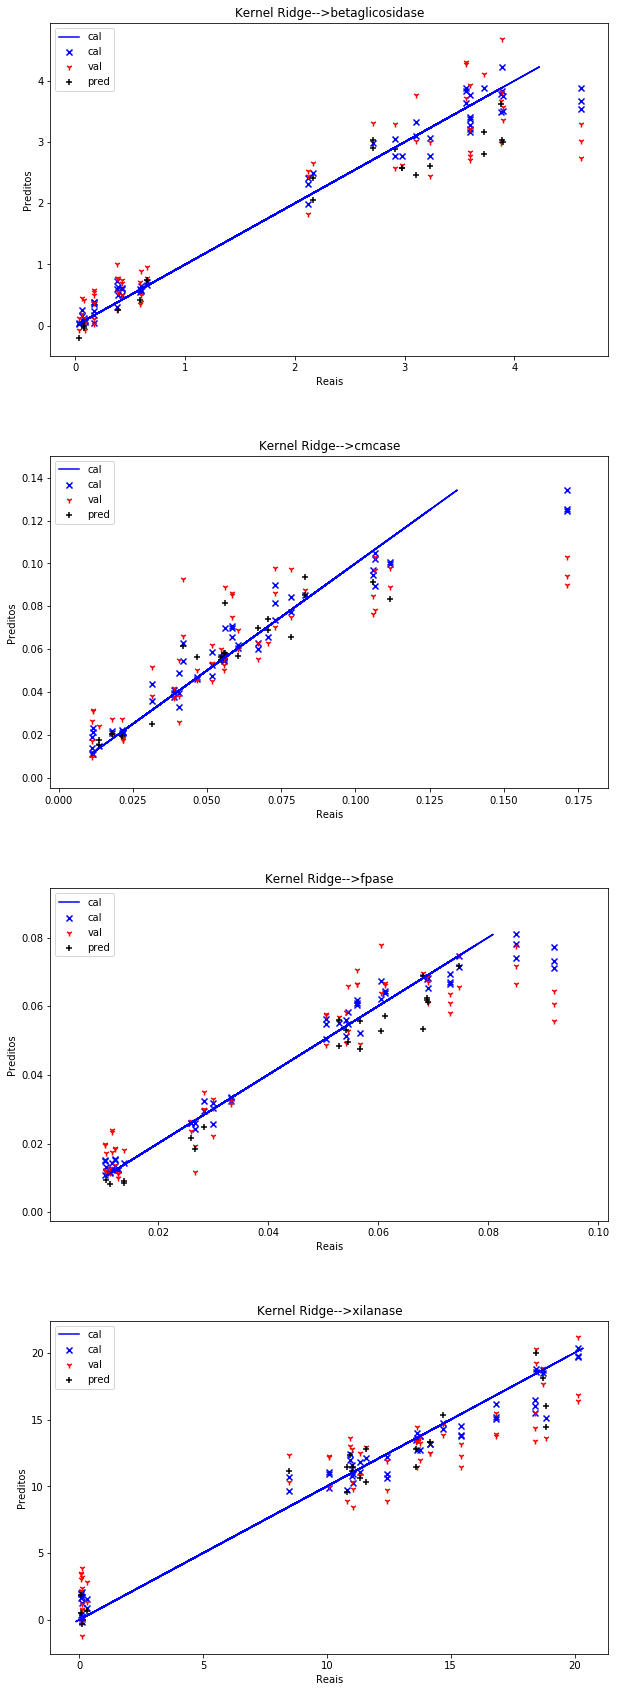

In [459]:
#graico de reais x preditos
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### Kernel Ridge: Gráficos: dados de treino

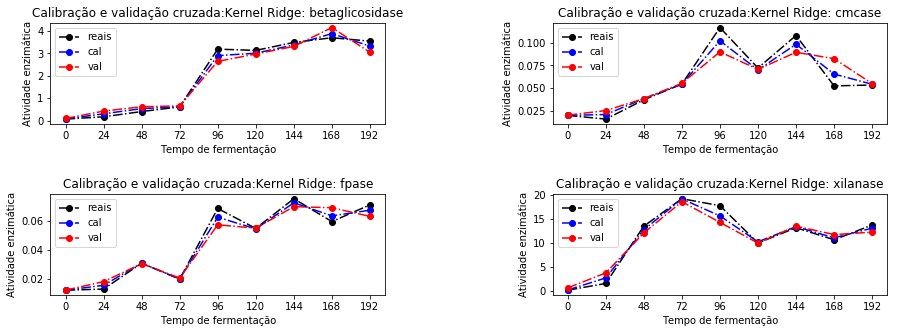

In [460]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### Kernel  Ridge: Gráficos de  teste

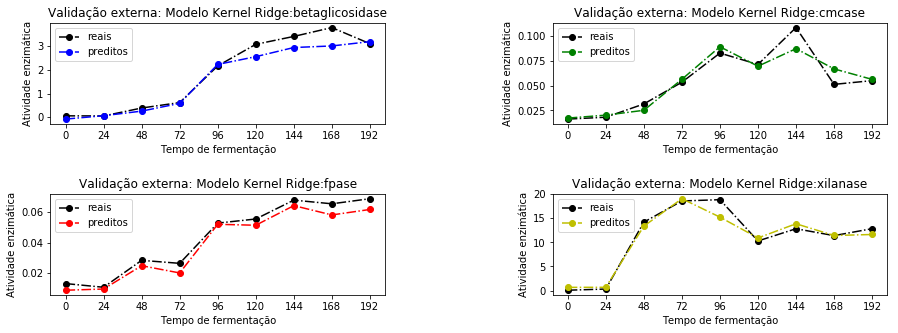

In [461]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## PCR: 

### PCR: função completa

In [350]:
#pcr função completa para execução do PCR:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaPCR(preproc=0, nPC=3, padroniza=False,IC=0):
    #separando o conjunto de dados em treino e teste
    
    #separando o conjunto de dados em treino e teste
    #x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,True)
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,padroniza, IC)

    
    # Roda o PCA e produz uma vaiável reduzida  e seleciona as primeiras componentes definidas pela variável nPc
    pca = PCA(n_components=nPC)
    x_treino = pca.fit_transform(x_treino)[:,:nPC]
    x_teste = pca.fit_transform(x_teste)[:,:nPC]    
    
    #Passo 2: Aplicar a regressão sobre as componentes selecionadas
    reg = MultiOutputRegressor(LinearRegression())
    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

### PCR: testes

In [374]:
#pcr teste diversificado
for npc in range(2,5):
    for k in [1,10,11]:
        print('\nNº Componentes principais:',npc,'\n',preProc[k])
        result = executaPCR(k,npc)
        print('Parâmetros do modelo:',modelo,'\n',result[0])
        resultados=exibeResultados(result)

        for k,v in zip(resultados.keys(),resultados.values()):
            print(k)
            print(v,'\n-----------------------------------------------------')


Nº Componentes principais: 2 
 Pré-proc: 1--> Padronização
Parâmetros do modelo: PCR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
cal
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0000 -0.0000  0.0000    0.0000
MSE            1.4714  0.0012  0.0004   27.1550
R2             0.4323  0.1969  0.3770    0.3889
RER            3.7383  4.6342  3.9452    3.8181
RMSE           1.2130  0.0342  0.0205    5.2110
RPD            1.3273  1.1159  1.2670    1.2792
RPIQ           2.6634  1.2823  2.4010    1.7190
SEP            1.2233  0.0345  0.0207    5.2550 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0159  0.0003  0.0001    0.0216
MSE            1.5158  0.0012  0.0004   29.0220
R2             0.4152  0.1492  0.3615    0.3469
RER            3.6835  4.5026  3.8970    3.6933
RMSE           1.2312  0.0353  0

cal
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0000 -0.0000  0.0000    0.0000
MSE            0.5024  0.0009  0.0001   19.1423
R2             0.8062  0.3642  0.7886    0.5692
RER            6.3978  5.2082  6.7723    4.5475
RMSE           0.7088  0.0305  0.0119    4.3752
RPD            2.2715  1.2541  2.1748    1.5236
RPIQ           4.5582  1.4411  4.1215    2.0473
SEP            0.7148  0.0307  0.0120    4.4121 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0056  0.0001  0.0000    0.0309
MSE            0.5294  0.0010  0.0002   21.1146
R2             0.7958  0.2949  0.7710    0.5249
RER            6.2327  4.9458  6.5069    4.3300
RMSE           0.7276  0.0321  0.0124    4.5951
RPD            2.2128  1.1909  2.0896    1.4507
RPIQ           4.4405  1.3685  3.9599    1.9494
SEP            0.7337  0.0324  0.0125    4.6337 
-----------------------------------------------------
pred
      betagli

In [384]:
#pcr teste simples
modelo = 'PCR'
result = executaPCR(preproc=10,nPC=4)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)
    
for k,v in zip(resultados.keys(),resultados.values()):
    print(k)
    print(v,'\n-----------------------------------------------------')

Parâmetros do modelo: PCR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
cal
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0000  0.0000  0.0000    0.0000
MSE            0.4549  0.0008  0.0001   18.9031
R2             0.8245  0.4514  0.8287    0.5746
RER            6.7236  5.6070  7.5226    4.5762
RMSE           0.6744  0.0283  0.0107    4.3478
RPD            2.3872  1.3501  2.4158    1.5332
RPIQ           4.7903  1.5514  4.5781    2.0603
SEP            0.6801  0.0285  0.0108    4.3845 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0219  0.0007  0.0002    0.0395
MSE            0.5997  0.0010  0.0001   21.7903
R2             0.7687  0.2955  0.7842    0.5097
RER            5.8581  4.9489  6.7047    4.2624
RMSE           0.7744  0.0321  0.0121    4.6680
RPD            2.0791  1.1914  2.1528    1.4

In [385]:
#pcr otimizando
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaPCR(preproc=10, nPC=4, IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['val'].loc[resultados['val'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.889, 0.5887, 0.9224, 0.6119] 
semente: b c f x [76, 24, 24, 24]


In [408]:
#PCr teste otimizado
modelo = 'PCR:'
result = result = executaPCR(preproc=1,nPC=4,IC=24)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: PCR: 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)


In [409]:
resultados['cal']

betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0000  0.0000  0.0000    0.0000
MSE            0.1920  0.0003  0.0001   16.3422
R2             0.9189  0.5715  0.8987    0.6021
RER            8.7551  5.4434  9.6236    4.9217
RMSE           0.4382  0.0183  0.0077    4.0426
RPD            3.5123  1.5277  3.1412    1.5853
RPIQ           7.2533  2.1218  6.3989    1.5347
SEP            0.4419  0.0185  0.0077    4.0767

In [410]:
resultados['val']

betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0159  0.0002 -0.0000   -0.0163
MSE            0.2300  0.0004  0.0001   19.3822
R2             0.9029  0.5136  0.8804    0.5281
RER            8.0039  5.1093  8.8571    4.5193
RMSE           0.4796  0.0195  0.0083    4.4025
RPD            3.2091  1.4338  2.8910    1.4557
RPIQ           6.6273  1.9914  5.8891    1.4092
SEP            0.4833  0.0197  0.0084    4.4396

In [411]:
resultados['pred']

betaglicosidase  cmcase   fpase  xilanase
BIAS           0.2201  0.0172  0.0038    1.4274
MSE            1.3604  0.0018  0.0002   30.4087
R2             0.5382  0.2525  0.6844    0.2866
RER            3.8752  4.0015  5.1953    3.6725
RMSE           1.1664  0.0427  0.0158    5.5144
RPD            1.4715  1.1566  1.7802    1.1839
RPIQ           2.8587  1.0300  2.6712    1.2175
SEP            1.1737  0.0400  0.0157    5.4580

In [390]:
reg, treino_teste,y_c,y_cv,y_p = result

###  Reais x preditos

In [391]:
#ridge reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5967  0.1065  0.0850   13.6476                 3.9144   
1            0.4280  0.0390  0.0334   13.7624                 0.6673   
2            0.0759  0.0136  0.0139    0.0726                 0.2257   
3            3.8876  0.0418  0.0605   11.0267                 3.8933   
4            0.6010  0.0559  0.0116   20.1368                 0.5951   
5            3.1068  0.0781  0.0545   11.0526                 2.7369   
6            2.1150  0.0730  0.0505   18.4127                 1.7882   
7            2.1643  0.0830  0.0529   18.8324                 1.7528   
8            2.9774  0.0704  0.0567   10.8002                 2.9361   
9            3.8803  0.0557  0.0691   11.3256                 3.1934   
10           3.5974  0.0516  0.0731   15.3973                 2.6009   
11           0.3900  0.0315  0.0283   14.1777                 0.9024   
12           0.6010  0.0559  0.0116   20.1368                 0.5468   
13           0.0874  0.0217  0.0127    0.1071                 0.1108   
14           0.3900  0.0315  0.0283   14.1777                 0.8960   
15           2.9774  0.0704  0.0567   10.8002                 2.6872   
16           2.9774  0.0704  0.0567   10.8002                 3.0056   
17           0.3828  0.0405  0.0301   12.4461                 0.7124   
18           0.0308  0.0213  0.0113    0.0996                -0.0610   
19           3.7243  0.0561  0.0681   11.5736                 3.6104   
20           2.1643  0.0830  0.0529   18.8324                 1.8977   
21           3.2342  0.0672  0.0543    8.4772                 2.5644   
22           2.9123  0.1058  0.0747   14.6813                 3.6457   
23           3.8803  0.0557  0.0691   11.3256                 3.3255   
24           3.5974  0.0516  0.0731   15.3973                 2.4499   
25           3.2342  0.0672  0.0543    8.4772                 2.7236   
26           3.5967  0.1065  0.0850   13.6476                 4.0044   
27           0.6491  0.0605  0.0260   18.4274                 0.7946   
28           3.8876  0.0418  0.0605   11.0267                 4.1390   
29           3.8876  0.0418  0.0605   11.0267                 3.8556   
30           0.0554  0.0181  0.0106    0.3275                 0.3115   
31           3.7243  0.0561  0.0681   11.5736                 3.7439   
32           3.1068  0.0781  0.0545   11.0526                 2.8587   
33           3.8994  0.1118  0.0613   10.9512                 3.4454   
34           3.5610  0.0586  0.0561   10.0978                 4.0652   
35           3.1068  0.0781  0.0545   11.0526                 2.6236   
36           2.9123  0.1058  0.0747   14.6813                 3.7953   
37           2.7110  0.0548  0.0688   13.5829                 3.1525   
38           3.5974  0.0516  0.0731   15.3973                 2.4601   
39           0.0759  0.0136  0.0139    0.0726                -0.0427   
40           3.8994  0.1118  0.0613   10.9512                 3.6364   
41           2.9123  0.1058  0.0747   14.6813                 3.6092   
42           2.7110  0.0548  0.0688   13.5829                 3.2801   
43           0.5905  0.0465  0.0267   18.7095                 0.4155   
44           0.1671  0.0117  0.0104    0.1117                 0.4406   
45           0.0874  0.0217  0.0127    0.1071                 0.0899   
46           0.6491  0.0605  0.0260   18.4274                 0.7626   
47           0.5905  0.0465  0.0267   18.7095                 0.7045   
48           0.4280  0.0390  0.0334   13.7624                 0.4906   
49           0.0759  0.0136  0.0139    0.0726                 0.0485   
50           0.3828  0.0405  0.0301   12.4461                 1.1024   
51           0.1724  0.0112  0.0121    0.0924                 0.2232   
52           0.0554  0.0181  0.0106    0.3275                 0.4861   
53           0.0308  0.0213  0.0113    0.0996                 0.1084   
54           0.0874  0.0217  0.0127    0.107

In [392]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            3.5967  0.1065  0.0850   13.6476                 3.9194   
1            0.4280  0.0390  0.0334   13.7624                 0.6755   
2            0.0759  0.0136  0.0139    0.0726                 0.2414   
3            3.8876  0.0418  0.0605   11.0267                 3.8973   
4            0.6010  0.0559  0.0116   20.1368                 0.5957   
5            3.1068  0.0781  0.0545   11.0526                 2.7439   
6            2.1150  0.0730  0.0505   18.4127                 1.8063   
7            2.1643  0.0830  0.0529   18.8324                 1.7314   
8            2.9774  0.0704  0.0567   10.8002                 2.9511   
9            3.8803  0.0557  0.0691   11.3256                 3.0660   
10           3.5974  0.0516  0.0731   15.3973                 2.4312   
11           0.3900  0.0315  0.0283   14.1777                 0.8987   
12           0.6010  0.0559  0.0116   20.1368                 0.5243   
13           0.0874  0.0217  0.0127    0.1071                 0.1201   
14           0.3900  0.0315  0.0283   14.1777                 0.9519   
15           2.9774  0.0704  0.0567   10.8002                 2.6929   
16           2.9774  0.0704  0.0567   10.8002                 2.9973   
17           0.3828  0.0405  0.0301   12.4461                 0.7767   
18           0.0308  0.0213  0.0113    0.0996                -0.1248   
19           3.7243  0.0561  0.0681   11.5736                 3.5535   
20           2.1643  0.0830  0.0529   18.8324                 1.8317   
21           3.2342  0.0672  0.0543    8.4772                 2.4899   
22           2.9123  0.1058  0.0747   14.6813                 3.7339   
23           3.8803  0.0557  0.0691   11.3256                 3.3671   
24           3.5974  0.0516  0.0731   15.3973                 2.3456   
25           3.2342  0.0672  0.0543    8.4772                 2.7577   
26           3.5967  0.1065  0.0850   13.6476                 4.0194   
27           0.6491  0.0605  0.0260   18.4274                 0.8096   
28           3.8876  0.0418  0.0605   11.0267                 4.1690   
29           3.8876  0.0418  0.0605   11.0267                 3.8889   
30           0.0554  0.0181  0.0106    0.3275                 0.3196   
31           3.7243  0.0561  0.0681   11.5736                 3.7234   
32           3.1068  0.0781  0.0545   11.0526                 2.8362   
33           3.8994  0.1118  0.0613   10.9512                 3.4188   
34           3.5610  0.0586  0.0561   10.0978                 4.0346   
35           3.1068  0.0781  0.0545   11.0526                 2.6053   
36           2.9123  0.1058  0.0747   14.6813                 3.9839   
37           2.7110  0.0548  0.0688   13.5829                 3.2878   
38           3.5974  0.0516  0.0731   15.3973                 2.5795   
39           0.0759  0.0136  0.0139    0.0726                -0.0494   
40           3.8994  0.1118  0.0613   10.9512                 3.6722   
41           2.9123  0.1058  0.0747   14.6813                 3.7832   
42           2.7110  0.0548  0.0688   13.5829                 3.3226   
43           0.5905  0.0465  0.0267   18.7095                 0.4357   
44           0.1671  0.0117  0.0104    0.1117                 0.4732   
45           0.0874  0.0217  0.0127    0.1071                 0.0911   
46           0.6491  0.0605  0.0260   18.4274                 0.7839   
47           0.5905  0.0465  0.0267   18.7095                 0.7144   
48           0.4280  0.0390  0.0334   13.7624                 0.6243   
49           0.0759  0.0136  0.0139    0.0726                 0.0659   
50           0.3828  0.0405  0.0301   12.4461                 1.2022   
51           0.1724  0.0112  0.0121    0.0924                 0.3661   
52           0.0554  0.0181  0.0106    0.3275                 0.6180   
53           0.0308  0.0213  0.0113    0.0996                 0.1181   
54           0.0874  0.0217  0.0127    0.107

In [393]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            2.1643  0.0830  0.0529   18.8324                 2.8688   
1            3.5610  0.0586  0.0561   10.0978                 2.7516   
2            0.1671  0.0117  0.0104    0.1117                 0.5042   
3            3.8994  0.1118  0.0613   10.9512                 3.0944   
4            4.6037  0.1713  0.0919   16.8115                 3.9320   
5            0.4280  0.0390  0.0334   13.7624                 0.9046   
6            0.3900  0.0315  0.0283   14.1777                 1.6797   
7            3.5967  0.1065  0.0850   13.6476                 3.4253   
8            0.6010  0.0559  0.0116   20.1368                -1.4185   
9            0.1671  0.0117  0.0104    0.1117                 0.9426   
10           3.8803  0.0557  0.0691   11.3256                 3.4190   
11           0.6491  0.0605  0.0260   18.4274                -0.5173   
12           2.1150  0.0730  0.0505   18.4127                 2.1520   
13           3.7243  0.0561  0.0681   11.5736                 1.4824   
14           0.1724  0.0112  0.0121    0.0924                 0.5743   
15           4.6037  0.1713  0.0919   16.8115                 3.4638   
16           3.2342  0.0672  0.0543    8.4772                 1.4197   
17           0.3828  0.0405  0.0301   12.4461                 2.3244   
18           4.6037  0.1713  0.0919   16.8115                 3.4534   
19           2.1150  0.0730  0.0505   18.4127                 2.2057   
20           0.0554  0.0181  0.0106    0.3275                 1.8299   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0620       0.0627         11.2042  
1         0.0678       0.0493         13.6731  
2         0.0290       0.0224          6.0890  
3         0.0716       0.0587         14.5006  
4         0.0815       0.0726         12.4542  
5         0.0343       0.0294          7.1377  
6         0.0465       0.0388          7.8813  
7         0.0762       0.0654         14.8739  
8         0.0185      -0.0028         11.1867  
9         0.0377       0.0238          5.5414  
10        0.0803       0.0565         13.3037  
11        0.0355       0.0046         12.0289  
12        0.0496       0.0578         11.4825  
13        0.0489       0.0384         14.7737  
14        0.0312       0.0213          5.1490  
15        0.0718       0.0699         12.0975  
16        0.0440       0.0408         12.6059  
17        0.0573       0.0448          7.1027  
18        0.0715       0.0698         11.8626  
19        0.0509       0.0569         11.0232  
20        0.0513       0.0352          5.8110

###  PCR: Gráficos de resíduos - histograma - reais x preditos

In [412]:
#título para os gráficos
modelo = 'PCR'

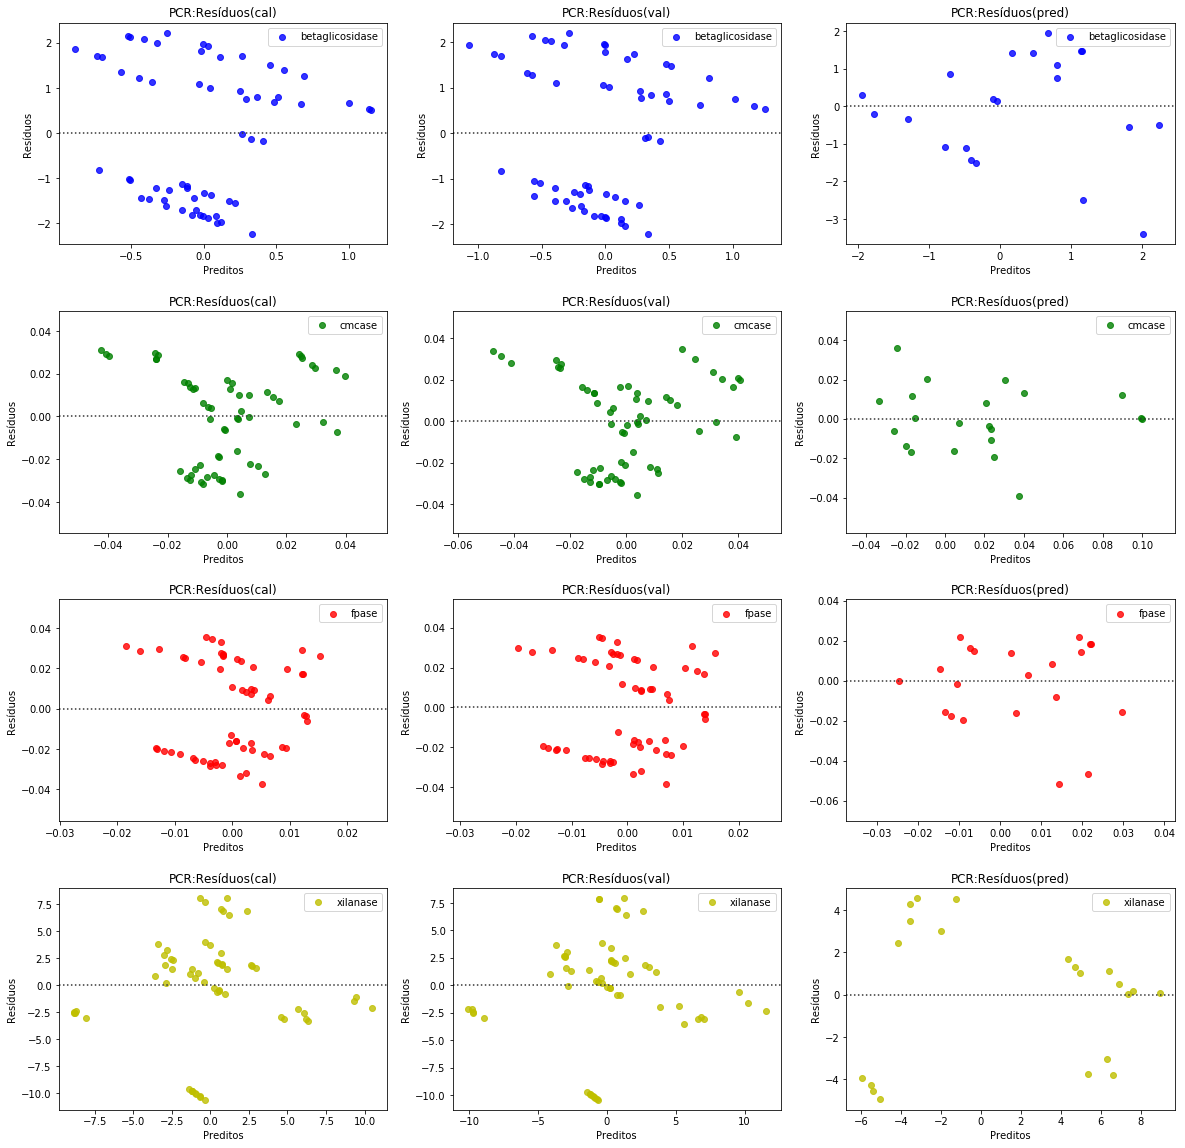

In [395]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

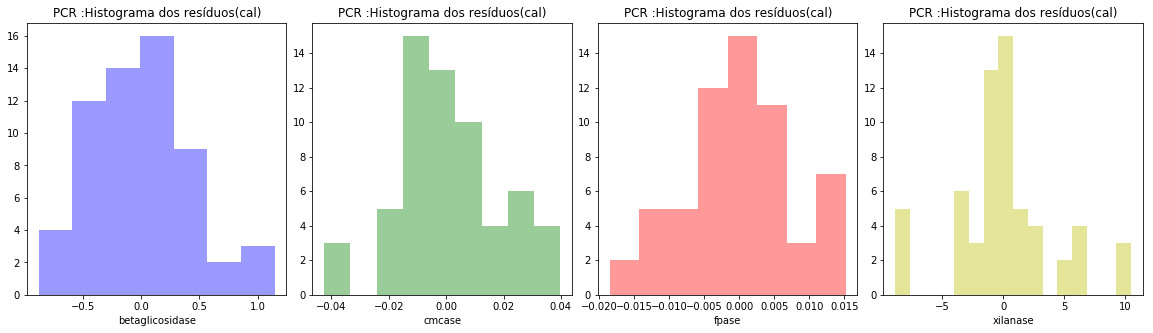

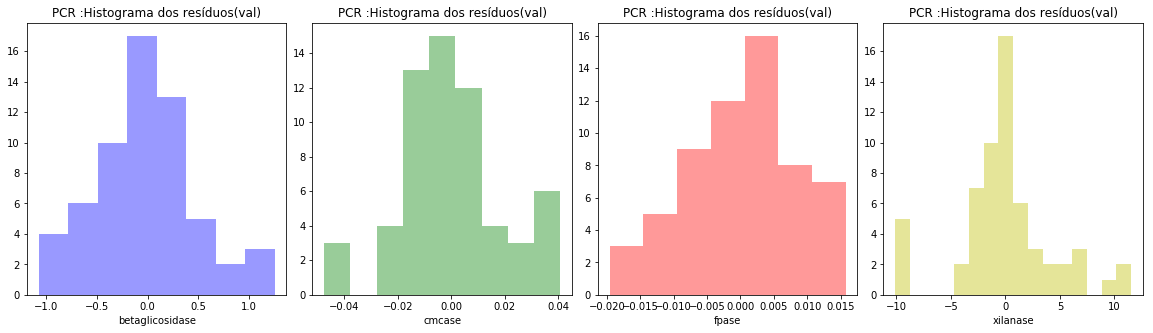

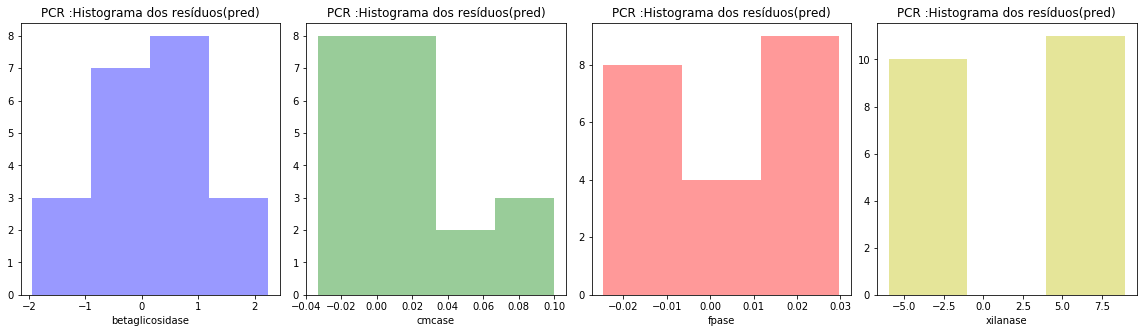

In [396]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

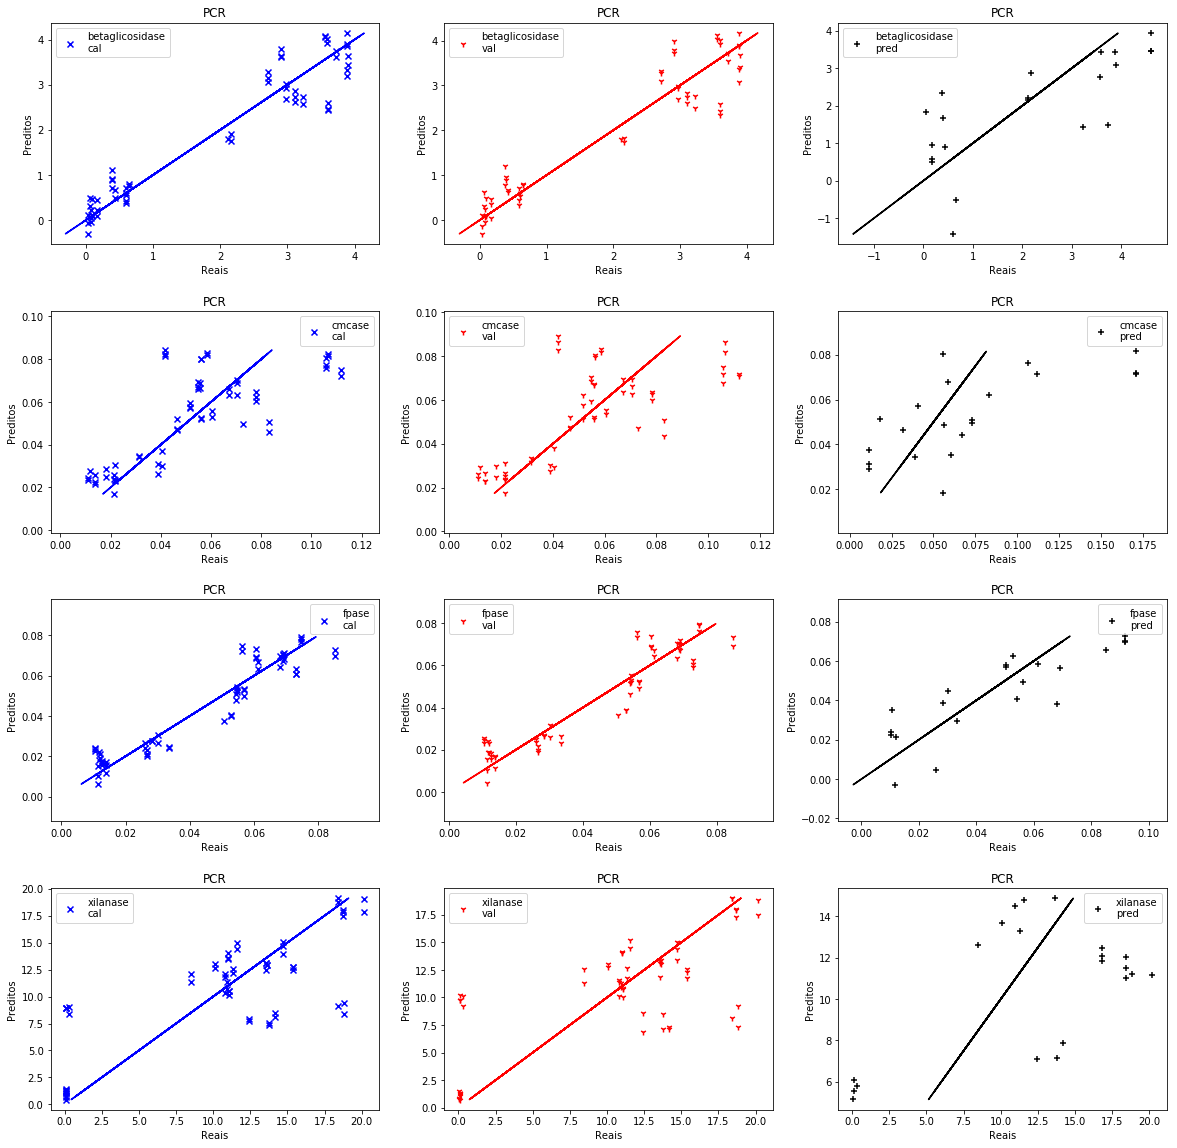

In [397]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

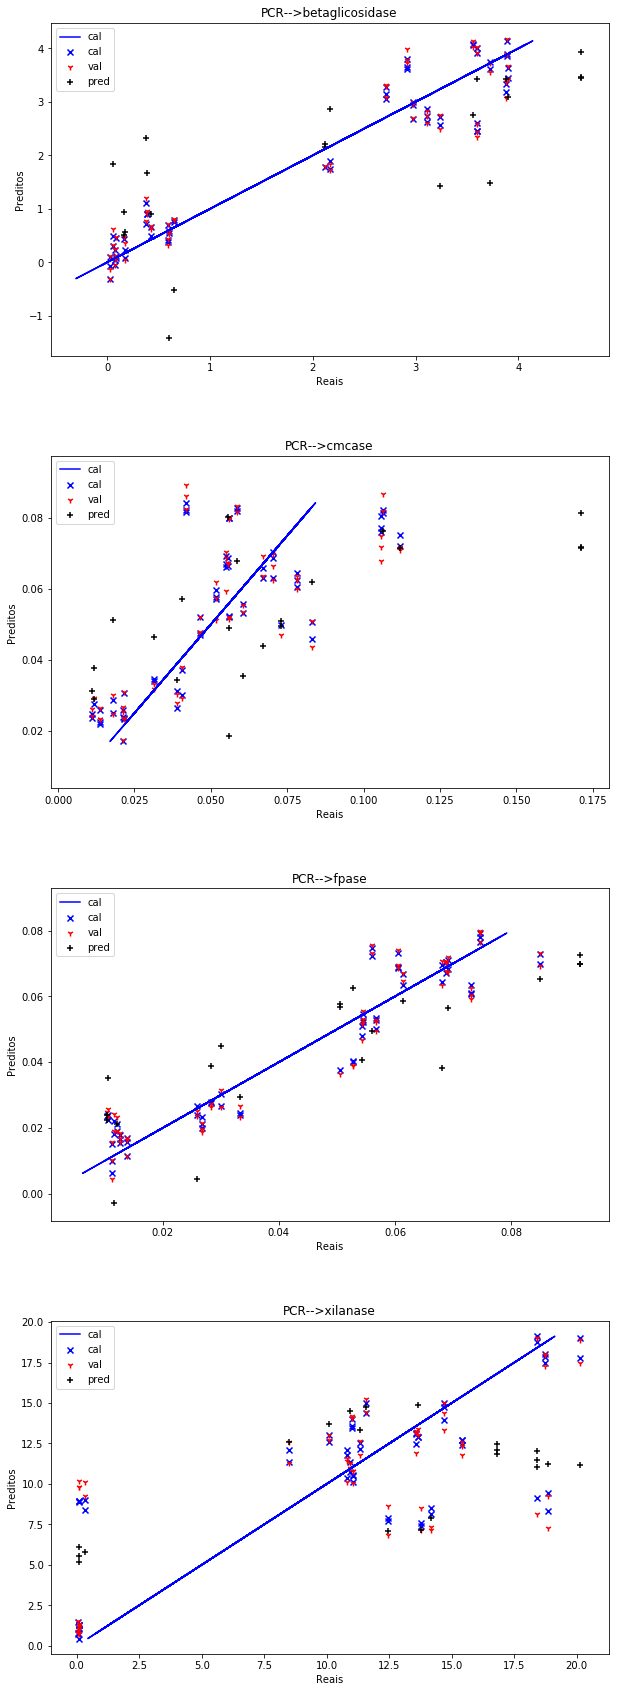

In [398]:
#graico de reais x preditos
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### PCR: Gráficos: dados de treino

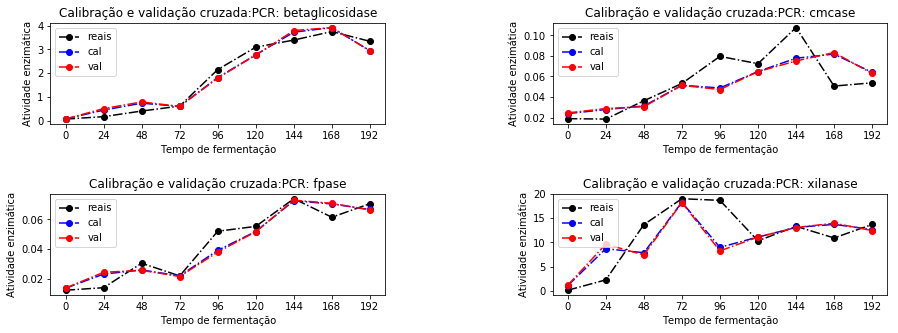

In [399]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### PCR: Gráficos de  teste

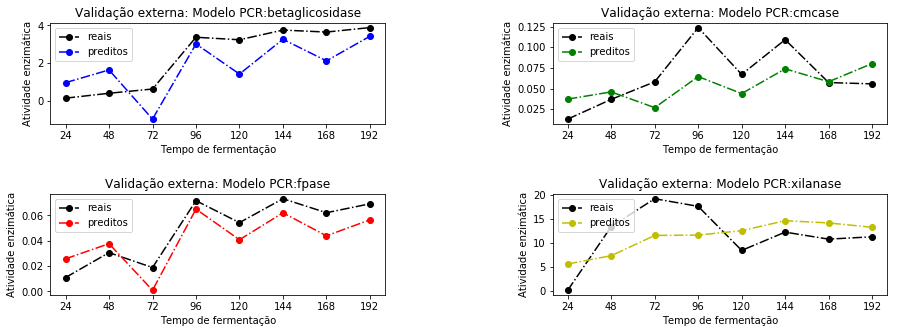

In [400]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

## Kernel PCA: 

### Kernel PCA: função completa

In [463]:
#kernelpca
#função completa para execução do Kernel PCA:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3,4)
def executaKPCA(preproc=1, nPC=3, tk='linear', ic=0):
    #separando o conjunto de dados em treino e teste
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,False,ic)

    
    # Define um objeto Kernel PCA
    kpca = KernelPCA(n_components=nPC, kernel =tk)
       
    x_treino = kpca.fit_transform(x_treino)[:,:nPC]
    x_teste = kpca.fit_transform(x_teste)[:,:nPC]    
    
    #Passo 2: Aplicar a regressão sobre as componentes selecionadas

    # Cria um objeto de regressão linear
    reg = LinearRegression()

    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result

    

###  Kernel PCA: testes

In [472]:
list(np.arange(1,10))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [477]:
#kernelpca otimização parte 1
varKernel = ['linear','poly','rbf','sigmoid','cosine', 'precomputed']
for pre, valor in zip(preProc.keys(), preProc.values()):
    maior=[-100,-100,-100,-100]
    #maiorGerado=[0,0,0,0]
    componentes=[0,0,0,0]
    tipokernel=['0','0','0','0']
    print(valor)
    for cp, k in zip(list(np.arange(2,7)),varKernel):
        result = executaKPCA(pre,cp,k)
        resultados=exibeResultados(result)
        r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
        r = []
        for j in range(4):
            r.append(r2.iloc[:,j][0])
            if r[j]>maior[j]:
                maior[j] = r[j]
                componentes[j]=cp
                tipokernel[j]=k
        print('\r%d%% completos'%(i+1), end='')
    print('\n','r2 ( b c f x ):',maior,'\ncomponentes:',componentes,'\nKernel:',tipokernel)
    print('------------------------')

Pré-proc: 0--> Sem pré-processamento
100% completos
 r2 ( b c f x ): [-1.0111, -0.3975, -1.0074, 0.4296] 
componentes: [6, 3, 3, 6] 
Kernel: ['cosine', 'poly', 'poly', 'cosine']
------------------------
Pré-proc: 1--> Padronização
100% completos
 r2 ( b c f x ): [-0.1511, -0.118, -0.5021, 0.4803] 
componentes: [5, 3, 3, 2] 
Kernel: ['sigmoid', 'poly', 'poly', 'linear']
------------------------
Pré-proc: 2--> Suavização(SavGol) - Par:3,1,1
100% completos
 r2 ( b c f x ): [-0.9054, -0.2866, -0.8782, 0.5751] 
componentes: [4, 2, 3, 3] 
Kernel: ['rbf', 'linear', 'poly', 'poly']
------------------------
Pré-proc: 3--> Suavização(SavGol) - Par:3,2,1
100% completos
 r2 ( b c f x ): [-0.9508, -0.2835, -0.8917, 0.1019] 
componentes: [2, 2, 2, 2] 
Kernel: ['linear', 'linear', 'linear', 'linear']
------------------------
Pré-proc: 4--> Suavização(SavGol) - Par:5,1,1
100% completos
 r2 ( b c f x ): [-0.9255, -0.2854, -0.8937, 0.5553] 
componentes: [3, 3, 2, 5] 
Kernel: ['poly', 'poly', 'linear', '

In [485]:
#kernelpca otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
componentes=[0,0,0,0]
tipokernel=[0,0,0,0]
for i in range(100):
    result = executaKPCA(8,6,'cosine',ic=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.8357, 0.4321, 0.812, 0.6554] 
semente: b c f x [3, 3, 0, 99]


## MLR: função completa

In [488]:
#mlr
#função completa para execução do MLR:
#A variável preproc determinará o tipo de processamento que será executado (0,1,2,3)
def executaMLR(preproc=1, param=False,IC=0):
    
    x_treino, x_teste, y_treino, y_teste = executaPreproc(preproc,param, IC)
        
      
    # Cria um objeto de regressão linear
    reg = MultiOutputRegressor(LinearRegression())
    #reg = LinearRegression()


    result = executaCVP([x_treino, x_teste, y_treino, y_teste], reg)
    
    return result


### MLR: testes

In [492]:
#mlr teste variando o tipo de préprocessamento
modelo = 'MLR'
for k in range(12):
    
    result = executaMLR(k)
    print('Parâmetros do modelo:',modelo,'\n',result[0])
    print(preProc[k])

    resultados=exibeResultados(result)
    
    for k,v in zip(resultados.keys(),resultados.values()):
        print(k)
        print(v,'\n-----------------------------------------------------')

 

Parâmetros do modelo: MLR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
Pré-proc: 0--> Sem pré-processamento
cal
      betaglicosidase        cmcase         fpase      xilanase
BIAS    -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
MSE      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
R2       1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
RER      1.202202e+13  2.121951e+13  2.319521e+13  1.322362e+13
RMSE     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
RPD      4.102941e+12  3.515776e+12  3.693259e+12  2.942458e+12
RPIQ     8.233336e+12  4.039945e+12  6.999012e+12  3.953850e+12
SEP      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.1185 -0.0062 -0.0021   -0.2357
MSE            2.1371  0.0024  0.0005   26.0872
R2     

Parâmetros do modelo: MLR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
Pré-proc: 5--> Suavização(SavGol) - Par:5,2,1
cal
      betaglicosidase        cmcase         fpase      xilanase
BIAS    -0.000000e+00  0.000000e+00 -0.000000e+00  0.000000e+00
MSE      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
R2       1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
RER      1.046809e+14  9.442676e+13  1.075018e+14  8.139318e+13
RMSE     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
RPD      3.557583e+13  2.177382e+13  3.081820e+13  2.219513e+13
RPIQ     7.138972e+13  2.502009e+13  5.840288e+13  2.982412e+13
SEP      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0091 -0.0020 -0.0002    0.0632
MSE            1.6209  0.0023  0.0003   15.140

Parâmetros do modelo: MLR 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)
Pré-proc: 10--> MSC
cal
      betaglicosidase        cmcase         fpase      xilanase
BIAS    -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
MSE      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
R2       1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
RER      2.276586e+13  2.454436e+13  3.431683e+13  1.742426e+13
RMSE     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
RPD      4.834615e+12  5.424839e+12  6.283970e+12  5.301441e+12
RPIQ     9.701580e+12  6.233631e+12  1.190861e+13  7.123671e+12
SEP      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
-----------------------------------------------------
val
      betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0724 -0.0044 -0.0013   -0.0570
MSE            1.9601  0.0026  0.0004   26.6340
R2             0.2438 -0

In [510]:
#MLR otimizado
maior=[-1,-1,-1,-1]
maiorGerado=[0,0,0,0]
for i in range(100):
    result = executaMLR(preproc=10,IC=i)
    resultados=exibeResultados(result)
    r2 = resultados['pred'].loc[resultados['pred'].index=='R2']
    r = []
    for j in range(4):
        r.append(r2.iloc[:,j][0])
        if r[j]>maior[j]:
            maior[j] = r[j]
            maiorGerado[j]=i
    print('\r%d%% completos'%(i+1), end='')
print('\n','r2:',maior,'\nsemente: b c f x',maiorGerado)

100% completos
 r2: [0.8007, 0.2856, 0.7779, 0.8061] 
semente: b c f x [60, 84, 60, 58]


In [511]:
#MLR teste otimizado
modelo = 'MLR:'
result = executaMLR(preproc=10,IC=60)
print('Parâmetros do modelo:',modelo,'\n',result[0])

resultados=exibeResultados(result)

Parâmetros do modelo: MLR: 
 MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
           n_jobs=None)


In [512]:
resultados['cal']

betaglicosidase        cmcase         fpase      xilanase
BIAS    -0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
MSE      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
R2       1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
RER      3.393416e+13  2.812467e+13  3.794781e+13  4.552278e+13
RMSE     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
RPD      9.934017e+12  5.236136e+12  1.192271e+13  7.192764e+12
RPIQ     2.024224e+13  4.882883e+12  1.964092e+13  7.031981e+12
SEP      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00

In [513]:
resultados['val']

betaglicosidase  cmcase   fpase  xilanase
BIAS           0.0128 -0.0002 -0.0005   -0.1889
MSE            0.9650  0.0021  0.0004   10.5681
R2             0.6010 -0.6036  0.4440    0.7205
RER            4.6166  3.4236  4.2674    6.1307
RMSE           0.9823  0.0464  0.0189    3.2509
RPD            1.5831  0.7897  1.3412    1.8914
RPIQ           3.2258  0.7364  2.2094    1.8492
SEP            0.9905  0.0468  0.0191    3.2728

In [514]:
resultados['pred']

betaglicosidase  cmcase   fpase  xilanase
BIAS          -0.0148 -0.0033  0.0012    0.7844
MSE            0.5523  0.0012  0.0001   19.1697
R2             0.8007 -0.3268  0.7779    0.5015
RER            5.0810  2.8679  5.4943    4.1585
RMSE           0.7432  0.0342  0.0112    4.3783
RPD            2.2401  0.8682  2.1218    1.4163
RPIQ           4.5667  1.1446  4.2755    2.5612
SEP            0.7614  0.0349  0.0114    4.4138

In [515]:
reg, treino_teste,y_c,y_cv,y_p = result

### Reais x preditos

In [516]:
#pls reaisxpreditos
#calibração
pred=pd.DataFrame(y_c, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('CALIBRAÇÃO:\n')
round(reais_pred,4)

CALIBRAÇÃO:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0308  0.0213  0.0113    0.0996                 0.0308   
1            0.4280  0.0390  0.0334   13.7624                 0.4280   
2            2.9774  0.0704  0.0567   10.8002                 2.9774   
3            3.8876  0.0418  0.0605   11.0267                 3.8876   
4            3.2342  0.0672  0.0543    8.4772                 3.2342   
5            0.4280  0.0390  0.0334   13.7624                 0.4280   
6            0.5905  0.0465  0.0267   18.7095                 0.5905   
7            2.1643  0.0830  0.0529   18.8324                 2.1643   
8            2.9123  0.1058  0.0747   14.6813                 2.9123   
9            0.0759  0.0136  0.0139    0.0726                 0.0759   
10           3.5967  0.1065  0.0850   13.6476                 3.5967   
11           3.8803  0.0557  0.0691   11.3256                 3.8803   
12           0.4280  0.0390  0.0334   13.7624                 0.4280   
13           3.5967  0.1065  0.0850   13.6476                 3.5967   
14           0.0554  0.0181  0.0106    0.3275                 0.0554   
15           0.3828  0.0405  0.0301   12.4461                 0.3828   
16           2.9774  0.0704  0.0567   10.8002                 2.9774   
17           0.1724  0.0112  0.0121    0.0924                 0.1724   
18           3.2342  0.0672  0.0543    8.4772                 3.2342   
19           0.3828  0.0405  0.0301   12.4461                 0.3828   
20           0.0554  0.0181  0.0106    0.3275                 0.0554   
21           0.6010  0.0559  0.0116   20.1368                 0.6010   
22           0.0759  0.0136  0.0139    0.0726                 0.0759   
23           3.7243  0.0561  0.0681   11.5736                 3.7243   
24           4.6037  0.1713  0.0919   16.8115                 4.6037   
25           0.0874  0.0217  0.0127    0.1071                 0.0874   
26           3.5974  0.0516  0.0731   15.3973                 3.5974   
27           0.6491  0.0605  0.0260   18.4274                 0.6491   
28           2.9123  0.1058  0.0747   14.6813                 2.9123   
29           2.1643  0.0830  0.0529   18.8324                 2.1643   
30           0.6491  0.0605  0.0260   18.4274                 0.6491   
31           0.3900  0.0315  0.0283   14.1777                 0.3900   
32           3.5610  0.0586  0.0561   10.0978                 3.5610   
33           0.6010  0.0559  0.0116   20.1368                 0.6010   
34           2.7110  0.0548  0.0688   13.5829                 2.7110   
35           4.6037  0.1713  0.0919   16.8115                 4.6037   
36           3.1068  0.0781  0.0545   11.0526                 3.1068   
37           3.5967  0.1065  0.0850   13.6476                 3.5967   
38           0.3900  0.0315  0.0283   14.1777                 0.3900   
39           2.1150  0.0730  0.0505   18.4127                 2.1150   
40           3.5974  0.0516  0.0731   15.3973                 3.5974   
41           4.6037  0.1713  0.0919   16.8115                 4.6037   
42           2.1150  0.0730  0.0505   18.4127                 2.1150   
43           3.1068  0.0781  0.0545   11.0526                 3.1068   
44           0.6010  0.0559  0.0116   20.1368                 0.6010   
45           2.9123  0.1058  0.0747   14.6813                 2.9123   
46           3.8876  0.0418  0.0605   11.0267                 3.8876   
47           3.8994  0.1118  0.0613   10.9512                 3.8994   
48           3.7243  0.0561  0.0681   11.5736                 3.7243   
49           2.1150  0.0730  0.0505   18.4127                 2.1150   
50           2.1643  0.0830  0.0529   18.8324                 2.1643   
51           0.5905  0.0465  0.0267   18.7095                 0.5905   
52           0.5905  0.0465  0.0267   18.7095                 0.5905   
53           0.1724  0.0112  0.0121    0.0924                 0.1724   
54           3.8803  0.0557  0.0691   11.325

In [517]:
#validação
pred=pd.DataFrame(y_cv, columns=var_ae)
reais = treino_teste[2]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('VALIDAÇÃO CRUZADA:\n')
round(reais_pred,4)


VALIDAÇÃO CRUZADA:



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.0308  0.0213  0.0113    0.0996                -1.5392   
1            0.4280  0.0390  0.0334   13.7624                 0.2104   
2            2.9774  0.0704  0.0567   10.8002                 2.6949   
3            3.8876  0.0418  0.0605   11.0267                 4.7097   
4            3.2342  0.0672  0.0543    8.4772                 3.0431   
5            0.4280  0.0390  0.0334   13.7624                 0.0316   
6            0.5905  0.0465  0.0267   18.7095                 0.6350   
7            2.1643  0.0830  0.0529   18.8324                 2.3328   
8            2.9123  0.1058  0.0747   14.6813                 4.8602   
9            0.0759  0.0136  0.0139    0.0726                 1.1080   
10           3.5967  0.1065  0.0850   13.6476                 3.8294   
11           3.8803  0.0557  0.0691   11.3256                 3.8496   
12           0.4280  0.0390  0.0334   13.7624                -0.3343   
13           3.5967  0.1065  0.0850   13.6476                 3.3986   
14           0.0554  0.0181  0.0106    0.3275                 0.6942   
15           0.3828  0.0405  0.0301   12.4461                 1.3775   
16           2.9774  0.0704  0.0567   10.8002                 3.4682   
17           0.1724  0.0112  0.0121    0.0924                 0.7942   
18           3.2342  0.0672  0.0543    8.4772                 3.1599   
19           0.3828  0.0405  0.0301   12.4461                 2.4283   
20           0.0554  0.0181  0.0106    0.3275                 0.7261   
21           0.6010  0.0559  0.0116   20.1368                -0.1234   
22           0.0759  0.0136  0.0139    0.0726                -0.5575   
23           3.7243  0.0561  0.0681   11.5736                 4.5961   
24           4.6037  0.1713  0.0919   16.8115                 3.6170   
25           0.0874  0.0217  0.0127    0.1071                 0.7436   
26           3.5974  0.0516  0.0731   15.3973                 2.8426   
27           0.6491  0.0605  0.0260   18.4274                 1.1814   
28           2.9123  0.1058  0.0747   14.6813                 0.9617   
29           2.1643  0.0830  0.0529   18.8324                 2.9507   
30           0.6491  0.0605  0.0260   18.4274                 0.9715   
31           0.3900  0.0315  0.0283   14.1777                 0.9101   
32           3.5610  0.0586  0.0561   10.0978                 5.7842   
33           0.6010  0.0559  0.0116   20.1368                -0.7111   
34           2.7110  0.0548  0.0688   13.5829                 2.7305   
35           4.6037  0.1713  0.0919   16.8115                 3.0005   
36           3.1068  0.0781  0.0545   11.0526                 2.6007   
37           3.5967  0.1065  0.0850   13.6476                 2.7718   
38           0.3900  0.0315  0.0283   14.1777                 0.8109   
39           2.1150  0.0730  0.0505   18.4127                 2.1791   
40           3.5974  0.0516  0.0731   15.3973                 1.8483   
41           4.6037  0.1713  0.0919   16.8115                 3.3998   
42           2.1150  0.0730  0.0505   18.4127                 3.0887   
43           3.1068  0.0781  0.0545   11.0526                 2.9226   
44           0.6010  0.0559  0.0116   20.1368                 0.9911   
45           2.9123  0.1058  0.0747   14.6813                 4.2881   
46           3.8876  0.0418  0.0605   11.0267                 4.0625   
47           3.8994  0.1118  0.0613   10.9512                 2.1067   
48           3.7243  0.0561  0.0681   11.5736                 4.0639   
49           2.1150  0.0730  0.0505   18.4127                 2.8273   
50           2.1643  0.0830  0.0529   18.8324                 2.4900   
51           0.5905  0.0465  0.0267   18.7095                 2.1122   
52           0.5905  0.0465  0.0267   18.7095                -0.2673   
53           0.1724  0.0112  0.0121    0.0924                -1.5336   
54           3.8803  0.0557  0.0691   11.325

In [518]:
#predição
pred=pd.DataFrame(y_p, columns=var_ae)
reais = treino_teste[3]
reais=reais.reset_index(drop=True)
reais_pred=reais.copy()
for var in var_ae:
    reais_pred['pred: '+var]=pred.loc[:,var]
print('Predição (validação externa):\n')
round(reais_pred,4)

Predição (validação externa):



betaglicosidase  cmcase   fpase  xilanase  pred: betaglicosidase  \
0            0.1671  0.0117  0.0104    0.1117                -0.6753   
1            2.9774  0.0704  0.0567   10.8002                 3.6595   
2            3.5610  0.0586  0.0561   10.0978                 4.5673   
3            0.1671  0.0117  0.0104    0.1117                 0.7090   
4            3.2342  0.0672  0.0543    8.4772                 2.1132   
5            0.0308  0.0213  0.0113    0.0996                -0.3576   
6            3.8803  0.0557  0.0691   11.3256                 4.2026   
7            0.3900  0.0315  0.0283   14.1777                 0.6878   
8            0.6491  0.0605  0.0260   18.4274                 0.9045   
9            2.7110  0.0548  0.0688   13.5829                 3.9102   
10           3.5974  0.0516  0.0731   15.3973                 2.7498   
11           0.0874  0.0217  0.0127    0.1071                -0.2337   
12           3.1068  0.0781  0.0545   11.0526                 2.0880   
13           3.8876  0.0418  0.0605   11.0267                 3.8741   
14           3.8994  0.1118  0.0613   10.9512                 3.9079   
15           0.0308  0.0213  0.0113    0.0996                -0.9366   
16           0.0759  0.0136  0.0139    0.0726                 0.9339   
17           0.1671  0.0117  0.0104    0.1117                 0.1183   
18           3.8994  0.1118  0.0613   10.9512                 3.0880   
19           0.0874  0.0217  0.0127    0.1071                 1.4245   
20           0.3828  0.0405  0.0301   12.4461                 0.5657   

    pred: cmcase  pred: fpase  pred: xilanase  
0         0.0390       0.0084         -3.2716  
1         0.1491       0.0544          7.3234  
2         0.0342       0.0602          8.2259  
3         0.0491       0.0271         -1.1774  
4         0.0213       0.0421         12.2540  
5        -0.0008       0.0145          0.8137  
6         0.0865       0.0863         18.9238  
7         0.0313       0.0115          8.1411  
8         0.0808       0.0267         22.8094  
9         0.0336       0.0737         14.4259  
10        0.0636       0.0651         12.2027  
11       -0.0083       0.0054         -1.7303  
12        0.0595       0.0397          3.9879  
13        0.0440       0.0580          9.9002  
14        0.1320       0.0718          7.0167  
15       -0.0330      -0.0089          1.3154  
16        0.0254       0.0139         -8.1283  
17       -0.0120       0.0071          2.9564  
18        0.1317       0.0731         14.5338  
19        0.0921       0.0271          6.2279  
20        0.0190       0.0115          6.3112

###  MLR: Gráficos de resíduos - histograma - reais x preditos

In [519]:
#título para os gráficos
modelo = 'MLR'

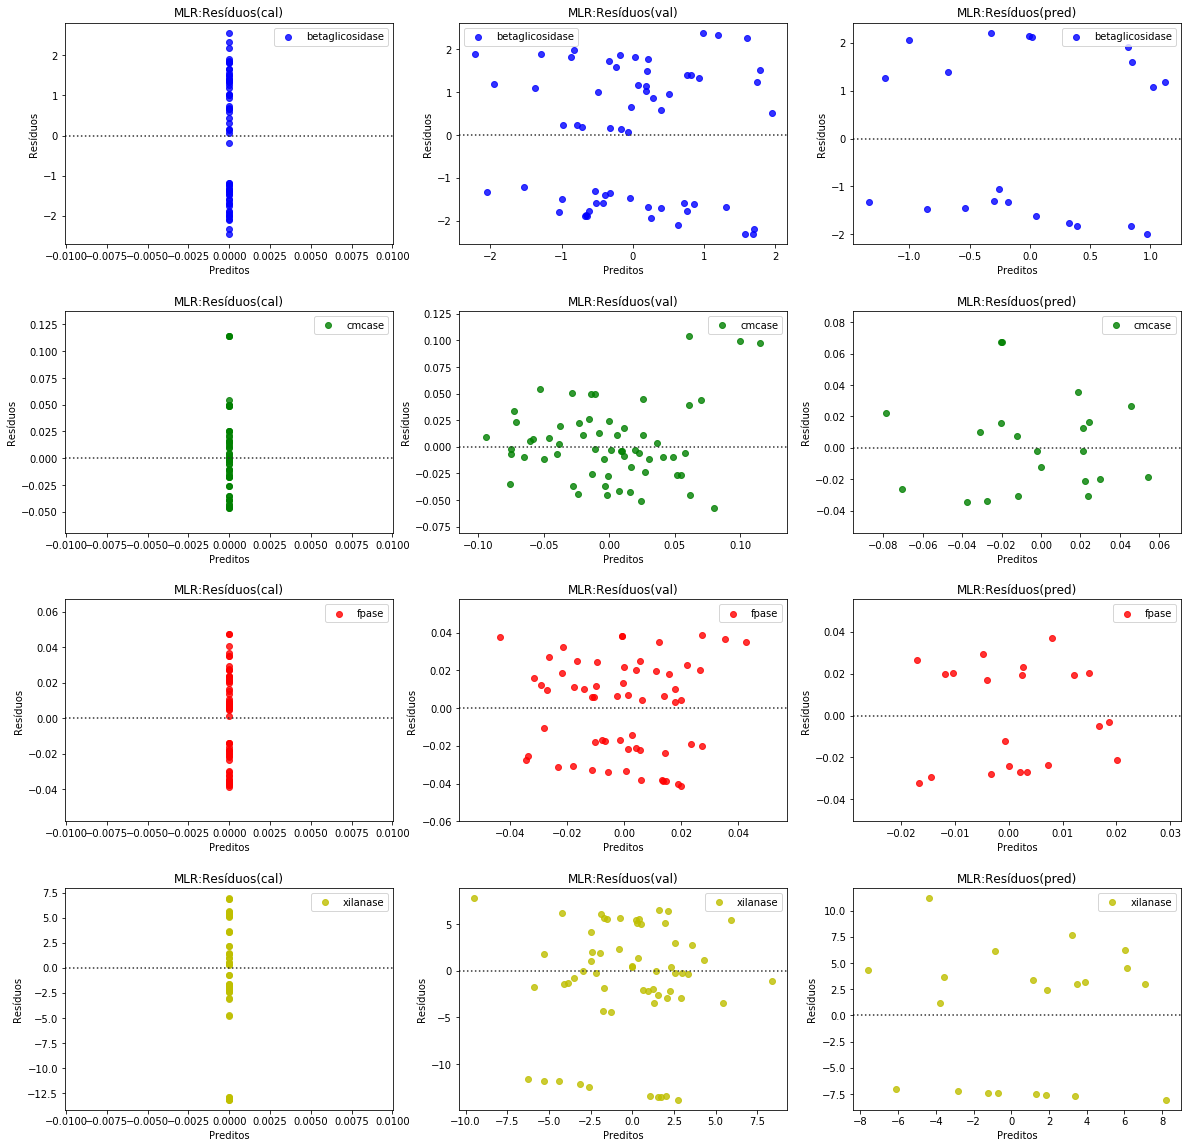

In [520]:
#gráfico dos resíduos
graficoResiduos(modelo, treino_teste, y_c,y_cv,y_p)

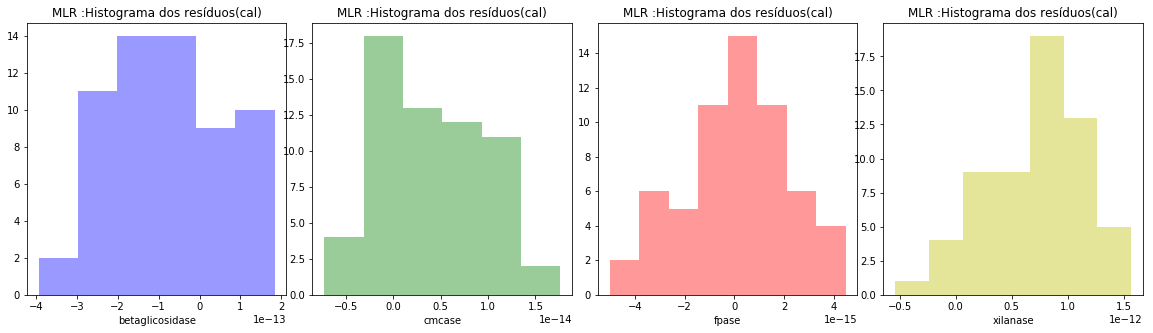

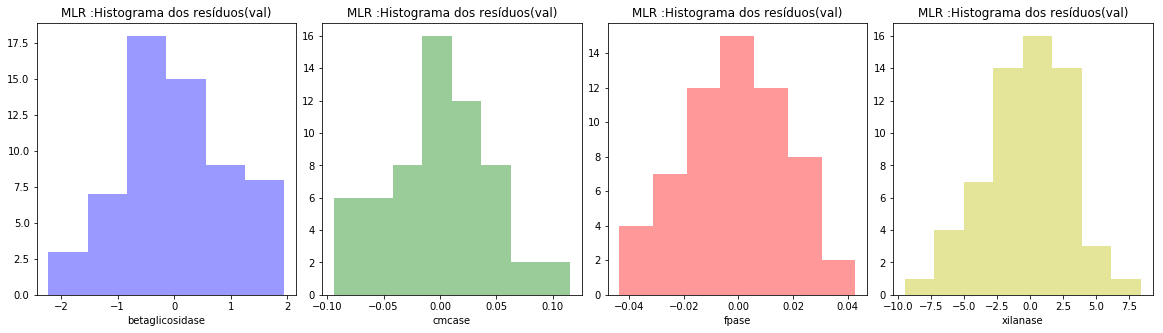

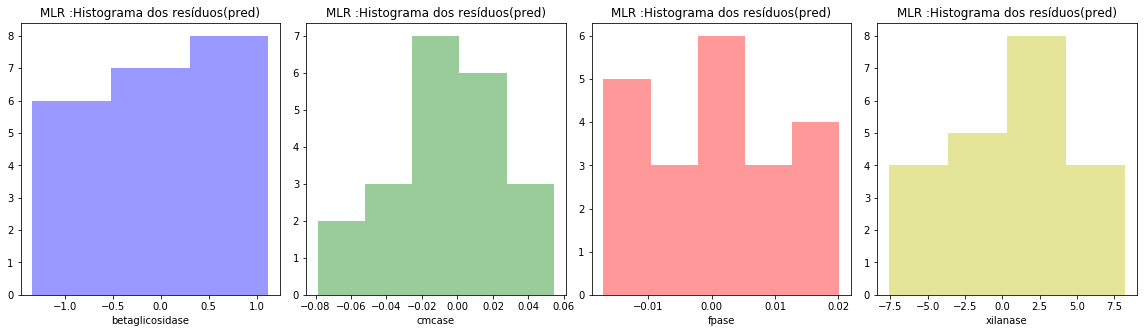

In [521]:
#histograma dos resíduos
graficoHist(modelo, treino_teste, y_c,y_cv,y_p)

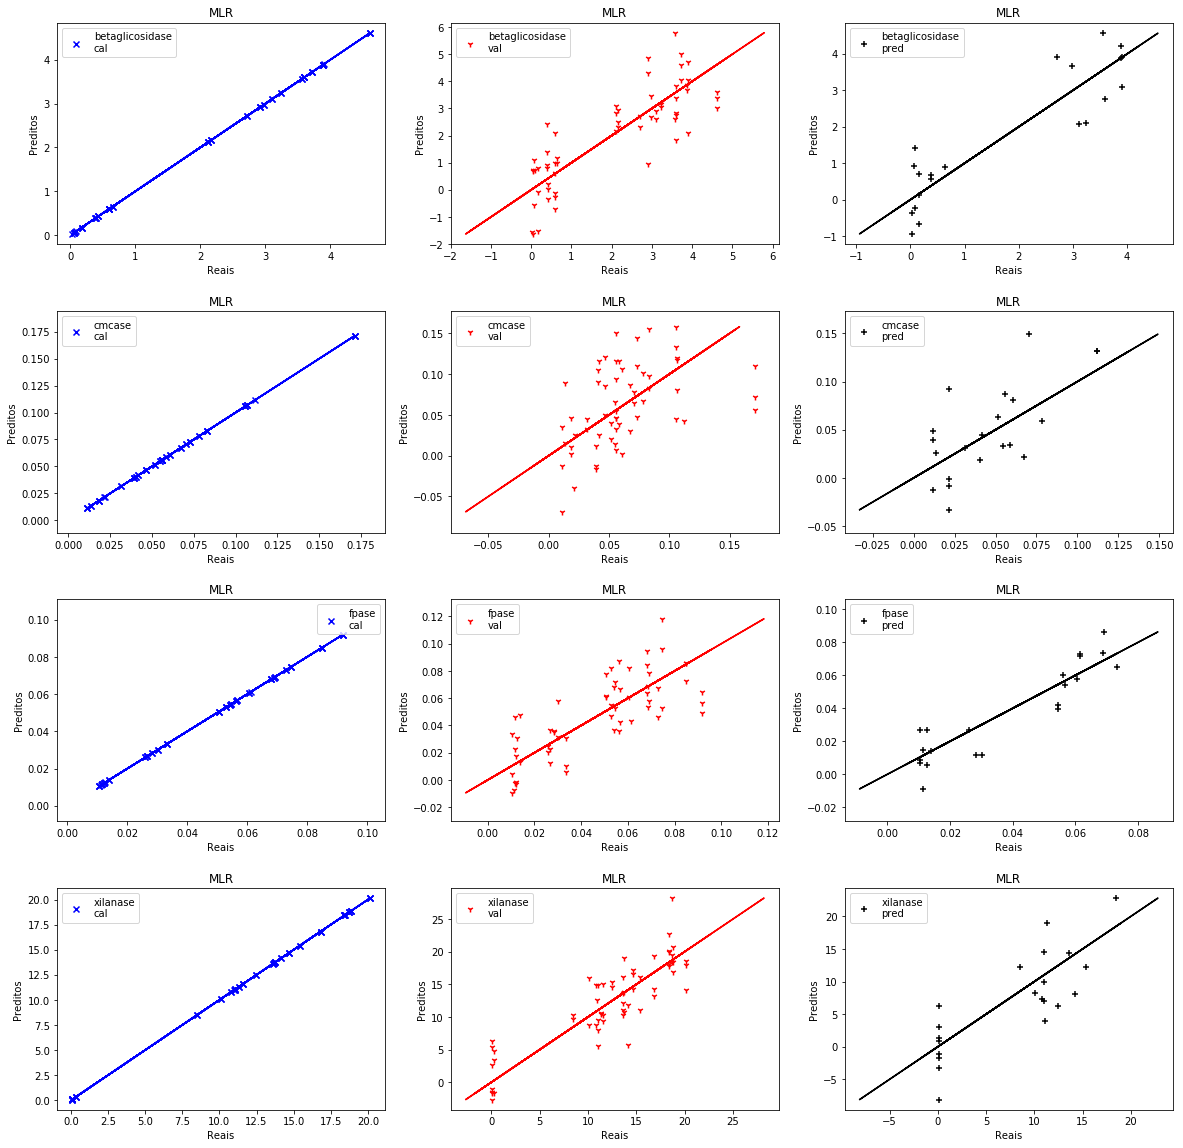

In [522]:
#graico de reais x preditos
graficoReaisPreditosSep(modelo, treino_teste, y_c,y_cv,y_p)

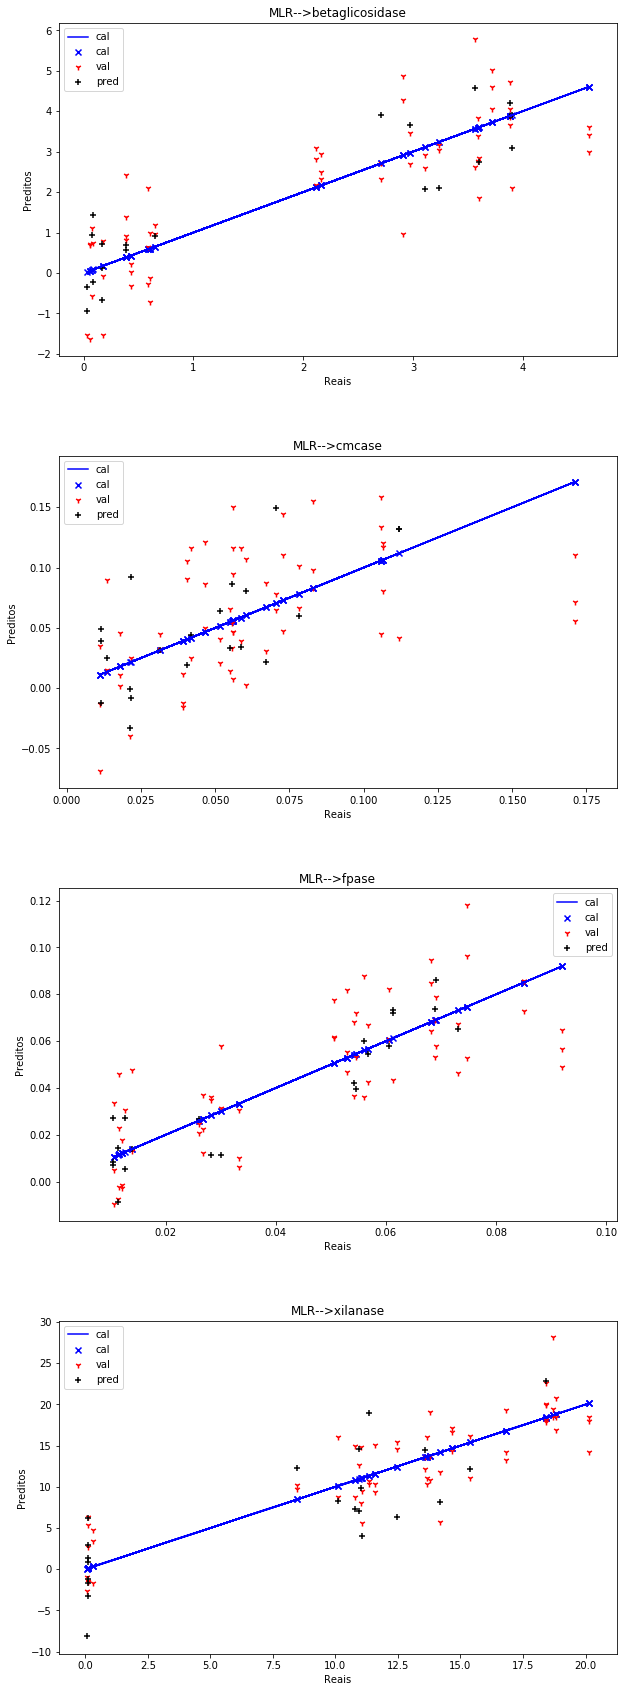

In [523]:
#graico de reais x preditos conjuntamente
graficoReaisPreditos(modelo, treino_teste, y_c,y_cv,y_p)

### MLR: Gráficos: dados de treino

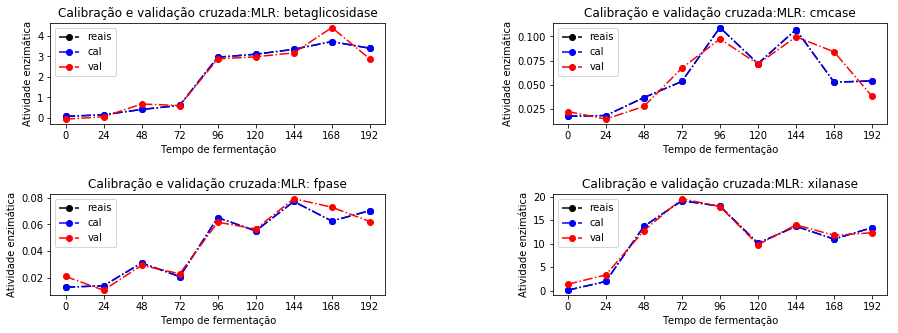

In [524]:
y_treino = treino_teste[2]
graficoTreinamento(modelo, y_treino, y_c,y_cv)

### MLR: Gráficos de  teste

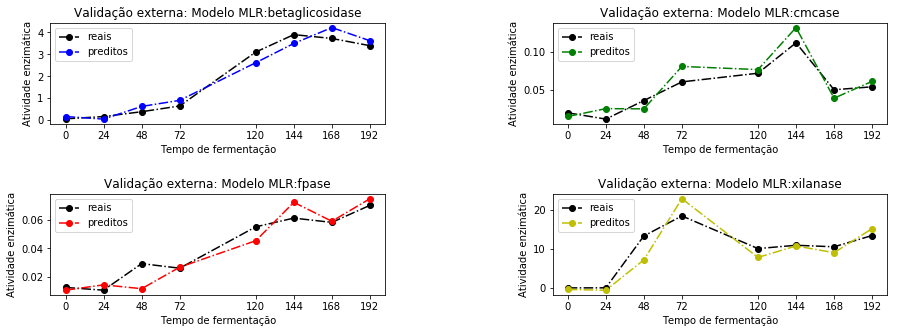

In [525]:
y_teste = treino_teste[3]
graficoTeste(modelo, y_teste, y_p)

In [67]:

for i in range(1,11):
    print('Tabuada de ',i,':')
    for a in range(1,11):
        print('%3d x %3d = %4d '%(i, a, i*a))
    print('--------------------------------')
    

Tabuada de  1 :
  1 x   1 =    1 
  1 x   2 =    2 
  1 x   3 =    3 
  1 x   4 =    4 
  1 x   5 =    5 
  1 x   6 =    6 
  1 x   7 =    7 
  1 x   8 =    8 
  1 x   9 =    9 
  1 x  10 =   10 
--------------------------------
Tabuada de  2 :
  2 x   1 =    2 
  2 x   2 =    4 
  2 x   3 =    6 
  2 x   4 =    8 
  2 x   5 =   10 
  2 x   6 =   12 
  2 x   7 =   14 
  2 x   8 =   16 
  2 x   9 =   18 
  2 x  10 =   20 
--------------------------------
Tabuada de  3 :
  3 x   1 =    3 
  3 x   2 =    6 
  3 x   3 =    9 
  3 x   4 =   12 
  3 x   5 =   15 
  3 x   6 =   18 
  3 x   7 =   21 
  3 x   8 =   24 
  3 x   9 =   27 
  3 x  10 =   30 
--------------------------------
Tabuada de  4 :
  4 x   1 =    4 
  4 x   2 =    8 
  4 x   3 =   12 
  4 x   4 =   16 
  4 x   5 =   20 
  4 x   6 =   24 
  4 x   7 =   28 
  4 x   8 =   32 
  4 x   9 =   36 
  4 x  10 =   40 
--------------------------------
Tabuada de  5 :
  5 x   1 =    5 
  5 x   2 =   10 
  5 x   3 =   15 
  5 x   4 =   

In [59]:
print(a)

14


# CONFIGURAÇÕES GERAIS:

In [725]:
#@config

#Formatação de fonte nos gráficos
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#fig.tight_layout() #melhorando a visualziação dos gráficos sobrepostos mas muda a fonte
#plt.subplots_adjust(hspace = .5)#ajusta altura entre um gráfico e outro

# Referências

......inlcuir ref
#### Referência para cálculo das medidas: RMSE, RPD e RPIQ
- Prediction of Soil-Available Potassium Content with Visible Near-Infrared Ray Spectroscopy of Different Pretreatment Transformations by the Boosting Algorithms

#### Referência para cálculo de todas as medidas estatísticas : RMSEP, precisão, bias
- ESTADO DA ARTE DE FIGURAS DE MÉRITO EM CALIBRAÇÃO MULTIVARIADA (Quim. Nova, Vol. 32, No. 5, 1278-1287, 2009)

#### RMSEP, SEP, bias, RPD:
- ANÁLISE MULTIVARIADA DE IMAGENS NA QUÍMICA: UM EXPERIMENTO PARA DETERMINAÇÃO DO pH DE ÁGUAS POTÁVEIS
